In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import pandas as pd
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [187]:

ds_acapex_1mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc');
ds_acapex_1mom_2 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc');

data_acapex_1mom = xr.concat([ds_acapex_1mom_1, ds_acapex_1mom_2], dim="time")


ds_acapex_2mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc');
ds_acapex_2mom_2 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc');

data_acapex_2mom = xr.concat([ds_acapex_2mom_1, ds_acapex_2mom_2], dim="time")


In [188]:
grid_acapex = xr.open_dataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/domain4_DOM04.nc');


In [189]:
clon_deg = np.degrees(grid_acapex.clon)
clat_deg = np.degrees(grid_acapex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

-123.03757532533088
-118.96268122787579
36.96696314757046
41.03470838875033


In [190]:
okla_x, okla_y = np.array([-120.5, 39.5])
#print(okla_x), print(okla_y)
dx_deg = 1.5; dy_deg = 1.5
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

-122.0
-119.0
41.0
38.0


(None, None)

In [191]:
window_cell = (
    (grid_acapex.clat >= np.deg2rad(bottom_bound))
    & (grid_acapex.clat <= np.deg2rad(top_bound))
    & (grid_acapex.clon >= np.deg2rad(left_bound))
    & (grid_acapex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)


In [192]:
# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_acapex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_acapex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)


window_vertex_indices :: [    2     4     5 ... 29355 29356 29360]
window_edge_indices :: [   20    21    22 ... 87011 87012 87022]


In [193]:
selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}




In [194]:
def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

In [195]:
new_grid_acapex = reindex_grid(grid_acapex, selected_indices, vars_to_renumber)


In [196]:
mask=np.isin(data_acapex_1mom['ncells'], selected_indices.cell)
mask_cell = mask

In [197]:


#start_time = '2011-05-11T09:00:00.000000000'
#end_time = '2011-05-12T02:00:00.000000000'
#data_sgp_subset = data_sgp_obs.sel(time=slice(start_time, end_time))

aircraft_starttime='2015-02-07T18:00:00.000000000'
aircraft_endtime='2015-02-08T01:00:00.000000000'

data_acapex_1mom_new = data_acapex_1mom.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
data_acapex_2mom_new = data_acapex_2mom.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))

In [198]:

time_1mom = data_acapex_1mom_new['time'];
qv_1mom = data_acapex_1mom_new['qv'];
qc_1mom = data_acapex_1mom_new['qc'];
qi_1mom = data_acapex_1mom_new['qi'];
qs_1mom = data_acapex_1mom_new['qs'];
qr_1mom = data_acapex_1mom_new['qr'];
prec_1mom = data_acapex_1mom_new['tot_prec'];
temp_1mom = data_acapex_1mom_new['temp'];
tempc_1mom = temp_1mom-273.16;

dbz_1mom = data_acapex_1mom_new['dbz'];
ht_1mom = data_acapex_1mom_new['z_mc'];
rho_1mom = data_acapex_1mom_new['rho'];
pres_1mom = data_acapex_1mom_new['pres'];
omega_1mom = data_acapex_1mom_new['omega'];
vert_vel_1mom = -1.*omega_1mom/(9.8*rho_1mom);

# 2 moment
time_2mom = data_acapex_2mom_new['time'];
qv_2mom = data_acapex_2mom_new['qv'];
qc_2mom = data_acapex_2mom_new['qc'];
qi_2mom = data_acapex_2mom_new['qi'];
qs_2mom = data_acapex_2mom_new['qs'];
qg_2mom = data_acapex_2mom_new['qg'];
qh_2mom = data_acapex_2mom_new['qh'];
qr_2mom = data_acapex_2mom_new['qr'];

nc_2mom = data_acapex_2mom_new['qnc'];
ni_2mom = data_acapex_2mom_new['qni'];
ns_2mom = data_acapex_2mom_new['qns'];
ng_2mom = data_acapex_2mom_new['qng'];
nh_2mom = data_acapex_2mom_new['qnh'];
nr_2mom = data_acapex_2mom_new['qnr'];

prec_2mom = data_acapex_2mom_new['tot_prec'];
temp_2mom = data_acapex_2mom_new['temp'];
tempc_2mom = temp_2mom-273.16;
dbz_2mom = data_acapex_2mom_new['dbz'];
ht_2mom = data_acapex_2mom_new['z_mc'];
rho_2mom = data_acapex_2mom_new['rho'];
pres_2mom = data_acapex_2mom_new['pres'];
omega_2mom = data_acapex_2mom_new['omega'];
vert_vel_2mom = -1.*omega_2mom/(9.8*rho_2mom);


#rho_water = 1000.; # density of water (kg/m3)
#pie  = 3.1416; 
#drop_conc_2mom_perm3 = nc_2mom*rho_2mom;
#drop_eff_rad_2mom_um = (qc_2mom/(rho_water*pie*drop_conc_2mom_perm3))**(1./3.)


thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.

rho_water = 1000.; # density of water (kg/m3)
pie  = 3.1416; 

filt_drop_num_2mom = xr.where((qc_2mom > thres_q) & (nc_2mom > 0.), nc_2mom, np.nan)
drop_conc_2mom_perm3 = filt_drop_num_2mom*rho_2mom;
drop_eff_rad_2mom_um = 1.e6*(qc_2mom/(rho_water*pie*drop_conc_2mom_perm3))**(1./3.)
#print(drop_eff_rad_2mom_um.min().values)
#print(drop_eff_rad_2mom_um.max().values)


In [29]:
#==================================== calculating the effective radius =============================================#

cld_liq_mix_ratio = 2.e-4; rho_water = 1000.; pie = 3.14; drop_num_conc_perm3 = 1149409545.8984375
# Marshall-Palmar distribution formula
#drop_num_conc_perm3 = cld_liq_mix_ratio/(rho_water*pie*drop_eff_rad**3)

#==================================== droplet effective radius

drop_eff_rad = (cld_liq_mix_ratio/(rho_water*pie*drop_num_conc_perm3))**(1/3)

print(drop_eff_rad*1.e6)


3.812488268518277


In [199]:
thres_q = 1.e-9;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 1.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_1mom = xr.where((qv_1mom > thres_q), qv_1mom, np.nan)
filt_qc_1mom = xr.where((qc_1mom > thres_q) & (vert_vel_1mom > thres_w), qc_1mom, np.nan)
filt_qi_1mom = xr.where((qi_1mom > thres_q) & (vert_vel_1mom > thres_w), qi_1mom, np.nan)
filt_qs_1mom = xr.where((qs_1mom > thres_q) & (vert_vel_1mom > thres_w), qs_1mom, np.nan)
filt_qr_1mom = xr.where((qr_1mom > thres_q) & (vert_vel_1mom > thres_w), qr_1mom, np.nan)
filt_dbz_1mom = xr.where((dbz_1mom > -10.), dbz_1mom, np.nan)

avg_qv_1mom = filt_qv_1mom.mean(dim=('time','ncells'))
avg_qc_1mom = filt_qc_1mom.mean(dim=('time','ncells'))
avg_qi_1mom = filt_qi_1mom.mean(dim=('time','ncells'))
avg_qs_1mom = filt_qs_1mom.mean(dim=('time','ncells'))
avg_qr_1mom = filt_qr_1mom.mean(dim=('time','ncells'))

avg_dbz_1mom = filt_dbz_1mom.mean(dim=('time','ncells'))
avg_temp_1mom = temp_1mom.mean(dim=('time','ncells'))
avg_ht_1mom = ht_1mom.mean(dim=('time','ncells'))
avg_pres_1mom = pres_1mom.mean(dim=('time','ncells'))

lwc_1mom = filt_qc_1mom*rho_1mom*1.e3 # kgperm3 to gperm3
iwc_1mom = (filt_qi_1mom+filt_qs_1mom)*rho_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_1mom = lwc_1mom.mean(dim=('time','ncells'))
avg_iwc_1mom = iwc_1mom.mean(dim=('time','ncells'))
avg_tempc_1mom = avg_temp_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_2mom = xr.where((qv_2mom > thres_q), qv_2mom, np.nan)
filt_qc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom > thres_w), qc_2mom, np.nan)
filt_qi_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom > thres_w), qi_2mom, np.nan)
filt_qs_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom > thres_w), qs_2mom, np.nan)
filt_qg_2mom = xr.where((qg_2mom > thres_q) & (vert_vel_2mom > thres_w), qg_2mom, np.nan)
filt_qh_2mom = xr.where((qh_2mom > thres_q) & (vert_vel_2mom > thres_w), qh_2mom, np.nan)
filt_qr_2mom = xr.where((qr_2mom > thres_q) & (vert_vel_2mom > thres_w), qr_2mom, np.nan)
filt_dbz_2mom = xr.where((dbz_2mom > -10.), dbz_2mom, np.nan)

avg_qv_2mom = filt_qv_2mom.mean(dim=('time','ncells'))
avg_qc_2mom = filt_qc_2mom.mean(dim=('time','ncells'))
avg_qi_2mom = filt_qi_2mom.mean(dim=('time','ncells'))
avg_qs_2mom = filt_qs_2mom.mean(dim=('time','ncells'))
avg_qr_2mom = filt_qr_2mom.mean(dim=('time','ncells'))

avg_dbz_2mom = filt_dbz_2mom.mean(dim=('time','ncells'))
avg_temp_2mom = temp_2mom.mean(dim=('time','ncells'))
avg_ht_2mom = ht_2mom.mean(dim=('time','ncells'))
avg_pres_2mom = pres_2mom.mean(dim=('time','ncells'))

lwc_2mom = filt_qc_2mom*rho_2mom*1.e3 # kgperm3 to gperm3
iwc_2mom = (filt_qi_2mom+filt_qs_2mom+filt_qg_2mom+filt_qh_2mom)*rho_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_2mom = lwc_2mom.mean(dim=('time','ncells'))
avg_iwc_2mom = iwc_2mom.mean(dim=('time','ncells'))
avg_tempc_2mom = avg_temp_2mom-273.16; 


filt_nc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom > thres_w), nc_2mom, np.nan) 


filt_ni_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom > thres_w), ni_2mom, np.nan) 
filt_ns_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom > thres_w), ns_2mom, np.nan) 
filt_ng_2mom = xr.where((qg_2mom > thres_q) & (vert_vel_2mom > thres_w), ng_2mom, np.nan)
filt_nh_2mom = xr.where((qh_2mom > thres_q) & (vert_vel_2mom > thres_w), nh_2mom, np.nan)


nc_2mom_percm3 = filt_nc_2mom*rho_2mom/1.e6;
ni_2mom_percm3 = filt_ni_2mom*rho_2mom/1.e6;
ns_2mom_percm3 = filt_ns_2mom*rho_2mom/1.e6;
ng_2mom_percm3 = filt_ng_2mom*rho_2mom/1.e6;
nh_2mom_percm3 = filt_nh_2mom*rho_2mom/1.e6;

nc_2mom_perm3 = nc_2mom_percm3*1.e6;

nc_2mom_perl = nc_2mom_percm3*1.e3;
ni_2mom_perl = ni_2mom_percm3*1.e3;
ns_2mom_perl = ns_2mom_percm3*1.e3;
ng_2mom_perl = ng_2mom_percm3*1.e3;
nh_2mom_perl = nh_2mom_percm3*1.e3;


#filt_drop_eff_rad_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom > thres_w), drop_eff_rad_2mom, np.nan); 
#avg_drop_eff_rad_um = 1.e6*filt_drop_eff_rad_2mom.mean(dim=('time','ncells'))
#avg_drop_eff_rad_um = np.nan_to_num(avg_drop_eff_rad_um, nan=0.0, posinf=0.0, neginf=0.0)


#avg_drop_eff_rad_m = (avg_qc_2mom/(rho_water*pie*nc_2mom_perm3))**(1/3)
#avg_drop_eff_rad_m = np.nan_to_num(avg_drop_eff_rad_m, nan=0.0, posinf=0.0, neginf=0.0)

avg_nc_2mom_percm3 = nc_2mom_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_percm3 = ni_2mom_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_percm3 = ns_2mom_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_percm3 = ng_2mom_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_percm3 = nh_2mom_percm3.mean(dim=('time','ncells'))


avg_nc_2mom_perl = nc_2mom_perl.mean(dim=('time','ncells'))
avg_ni_2mom_perl = ni_2mom_perl.mean(dim=('time','ncells'))
avg_ns_2mom_perl = ns_2mom_perl.mean(dim=('time','ncells'))
avg_ng_2mom_perl = ng_2mom_perl.mean(dim=('time','ncells'))
avg_nh_2mom_perl = nh_2mom_perl.mean(dim=('time','ncells'))


avg_totice_2mom_perl = avg_ni_2mom_perl+avg_ns_2mom_perl+avg_ng_2mom_perl+avg_nh_2mom_perl


#================== Droplet effective radius
nc_2mom_perm3 = avg_nc_2mom_percm3*1.e6;
nc_1mom_perm3 = 100.*1.e6;
rho_water = 1000.; # density of water (kg/m3)
pie  = 3.1416; 

avg_drop_eff_rad_1mom_m = ((3.*avg_qc_1mom)/(4.*rho_water*pie*nc_1mom_perm3))**(1./3.) # Marchell-Palmar eqn
avg_drop_eff_rad_1mom_um = avg_drop_eff_rad_1mom_m*1.e6;

avg_drop_eff_rad_2mom_m = ((3.*avg_qc_2mom)/(4.*rho_water*pie*nc_2mom_perm3))**(1./3.) # Marchell-Palmar eqn
avg_drop_eff_rad_2mom_um = avg_drop_eff_rad_2mom_m*1.e6;
#############################################


#================== Droplet mean diameter
#n_aerosol_perm3 = 1500.*1.e6;
#drop_mean_diam_1mom_m = 2.*((3.*avg_qc_1mom)/(4.*pie*rho_water*n_aerosol_perm3))**(1./3.)
#drop_mean_diam_1mom_um = drop_mean_diam_1mom_m*1.e6;

#drop_mean_diam_2mom_m = 2.*((3.*avg_qc_2mom)/(4.*pie*rho_water*n_aerosol_perm3))**(1./3.)
#drop_mean_diam_2mom_um = drop_mean_diam_2mom_m*1.e6;

In [22]:
#print(nc_2mom_percm3)
print(nc_2mom_percm3.max().values)


100.0


In [200]:
# Observations
# Initialize empty lists for each column for droplet mean diameter

temp_obs_conc_cdp = []
num_drop_cdp = []
std_dev_num_drop_cdp = []
std_err_num_drop_cdp = []

temp_obs_lwc_cdp = []
lwc_cdp = []
std_dev_lwc_cdp = []
std_err_lwc_cdp = []

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/cld_drop_num_conc_cdp_acapex_updraft_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_conc_cdp.append(float(columns[0]))
        num_drop_cdp.append(float(columns[1]))
        std_dev_num_drop_cdp.append(float(columns[2]))
        std_err_num_drop_cdp.append(float(columns[3]))

#### CDP CDNC
temp_obs_conc_cdp = np.array(temp_obs_conc_cdp)
num_drop_cdp = np.array(num_drop_cdp)
std_dev_num_drop_cdp = np.array(std_dev_num_drop_cdp)
std_err_num_drop_cdp = np.array(std_err_num_drop_cdp)

num_drop_cdp[(num_drop_cdp <= 0)] = np.nan

print(len(temp_obs_conc_cdp))

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/LWC_gperm3_T_updraft', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_lwc_cdp.append(float(columns[0]))
        lwc_cdp.append(float(columns[1]))
        std_dev_lwc_cdp.append(float(columns[2]))
        std_err_lwc_cdp.append(float(columns[3]))

#### CDP LWC
temp_obs_lwc_cdp = np.array(temp_obs_lwc_cdp)
lwc_cdp = np.array(lwc_cdp)
std_dev_lwc_cdp = np.array(std_dev_lwc_cdp)
std_err_lwc_cdp = np.array(std_err_lwc_cdp)

lwc_cdp[(lwc_cdp <= 0)] = np.nan

print(len(temp_obs_lwc_cdp))


#####################################################################
temp_ni_obs = []
num_ice_2ds = []
std_dev_num_ice_2ds = []
std_err_num_ice_2ds = []


# Open the text file
with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/ni200um_acapex_updraft_perl', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_ni_obs.append(float(columns[0]))
        num_ice_2ds.append(float(columns[1]))
        std_dev_num_ice_2ds.append(float(columns[2]))
        std_err_num_ice_2ds.append(float(columns[3]))

#### CIP
temp_ni_obs = np.array(temp_ni_obs)
num_ice_2ds = np.array(num_ice_2ds)
std_dev_num_ice_2ds = np.array(std_dev_num_ice_2ds)
std_err_num_ice_2ds = np.array(std_err_num_ice_2ds)

#std_dev_num_ice_2ds = std_dev_num_ice_2ds*1.e3;
#std_err_num_ice_2ds = std_err_num_ice_2ds*1.e3;

num_ice_2ds[(num_ice_2ds <= 0)] = np.nan


temp_obs_iwc_2ds = []
iwc_2ds = []
std_dev_iwc_2ds = []
std_err_iwc_2ds = []

# Open the text file
with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/iwc_acapex_updraft_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_iwc_2ds.append(float(columns[0]))
        iwc_2ds.append(float(columns[1]))
        std_dev_iwc_2ds.append(float(columns[2]))
        std_err_iwc_2ds.append(float(columns[3]))

#### CIP
temp_obs_iwc_2ds = np.array(temp_obs_iwc_2ds)
iwc_2ds = np.array(iwc_2ds)
std_dev_iwc_2ds = np.array(std_dev_iwc_2ds)
std_err_iwc_2ds = np.array(std_err_iwc_2ds)

#std_dev_num_ice_2ds = std_dev_num_ice_2ds*1.e3;
#std_err_num_ice_2ds = std_err_num_ice_2ds*1.e3;

iwc_2ds[(iwc_2ds <= 0)] = np.nan


16
20


In [26]:
print(avg_lwc_1mom.values)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.01319048 0.01016972 0.03779084
 0.07228282 0.09868962 0.10439014 0.09401274 0.10126284 0.11783693
 0.13461775 0.15308881 0.17513625 0.21042821 0.24349597 0.2708992
 0.2947476  0.31192788 0.32335004 0.32946447 0.33378586 0.33299264
 0.3351413  0.33757323 0.33788323 0.3393176  0.34306335 0.3441377
 0.3489094  0.35227248 0.3556763  0.3544406  0.35490215 0.35599586
 0.35720918 0.3606556  0.3715363  0.38435546 0.39583823 0.40443552
 0.4051577  0.4053171  0.40720025 0.42055055 0.44639215]


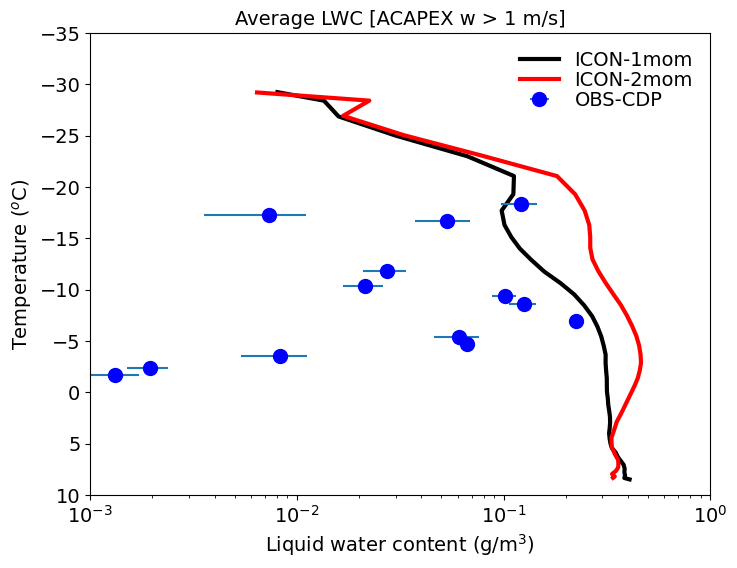

In [77]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_lwc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_lwc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.errorbar(lwc_cdp, temp_obs_lwc_cdp, xerr=std_err_lwc_cdp, fmt='o' , label='OBS-CDP', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e0)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e0], fontsize=fontsize)
plt.ylim(10, -35)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Liquid water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average LWC [ACAPEX w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_lwc_validation_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

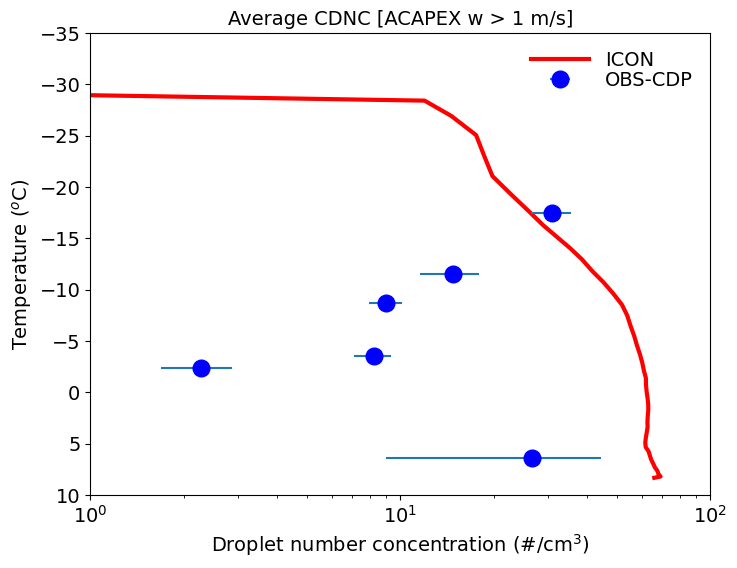

In [78]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_nc_2mom_percm3,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
plt.errorbar(num_drop_cdp, temp_obs_conc_cdp, xerr=1.e-5*std_err_num_drop_cdp, fmt='o' , label='OBS-CDP', markersize=12,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e0, 1.e2)
plt.xticks([1.e0,1.e1,1.e2], fontsize=fontsize)
plt.ylim(10, -35)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Droplet number concentration (#/cm$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average CDNC [ACAPEX w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_cdnc_validation_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

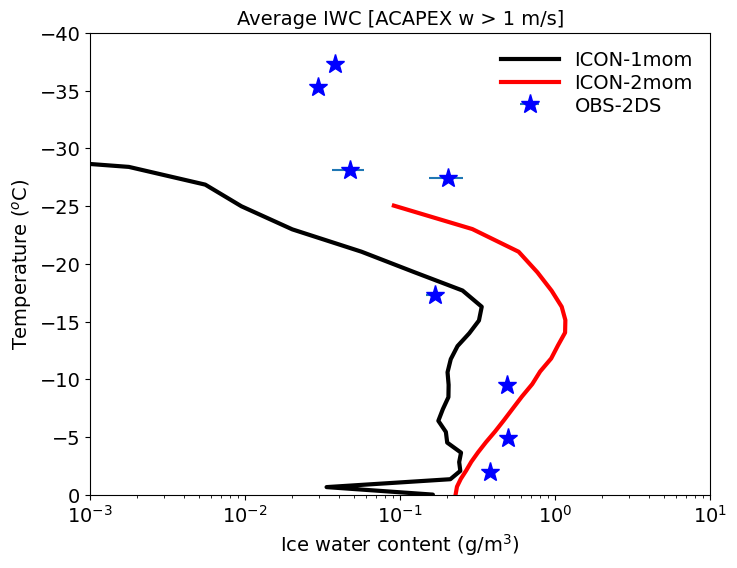

In [79]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_iwc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_iwc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.errorbar(iwc_2ds, temp_obs_iwc_2ds, xerr=std_err_iwc_2ds, fmt='*' , label='OBS-2DS', markersize=14,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average IWC [ACAPEX w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_iwc_validation_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

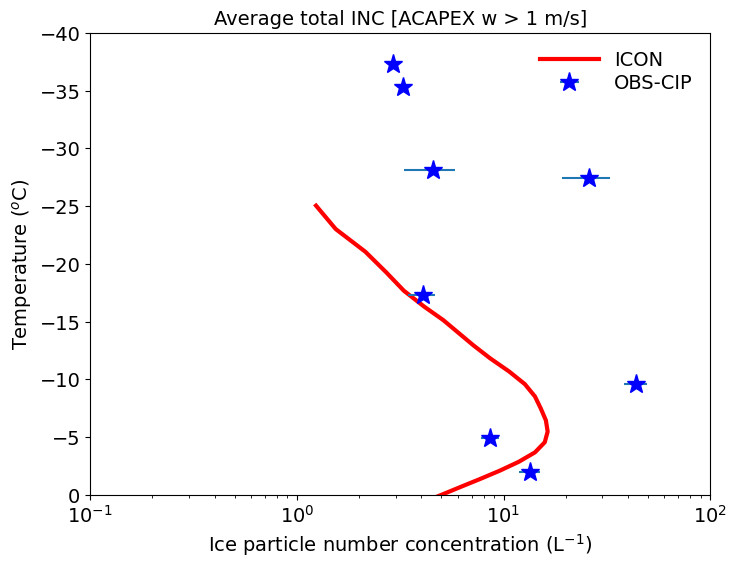

In [201]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_totice_2mom_perl,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
plt.errorbar(num_ice_2ds, temp_ni_obs, xerr=std_err_num_ice_2ds, fmt='*' , label='OBS-CIP', markersize=14,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-1, 1.e2)
plt.xticks([1.e-1,1.e0,1.e1,1.e2], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice particle number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average total INC [ACAPEX w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_icnc_validation_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

In [68]:
print(refl_kazr_obs.shape)
print(alt_kazr_obs.shape)

(40,)
(40,)


In [81]:

time_citation_obs = []
lat_citation_obs = []
lon_citation_obs = []
alt_citation_obs = []

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/flight_track_time_lat_lon_acapex', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        time_citation_obs.append(float(columns[0]))
        lat_citation_obs.append(float(columns[1]))
        lon_citation_obs.append(float(columns[2]))
        alt_citation_obs.append(float(columns[3]))

In [82]:
import netCDF4 as nc


#============================================================================#
#================================= 1-moment =================================#
#============================================================================#

ds_acapex_1mom_1 = xr.open_mfdataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc")
ds_acapex_1mom_2 = xr.open_mfdataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/domain4_DOM04.nc")

data_mc3e_1mom = xr.concat([ds_acapex_1mom_1, ds_acapex_1mom_2], dim="time")

mask_cell=np.isin(data_acapex_1mom['ncells'], selected_indices.cell)
ds_new_1mom = data_acapex_1mom.sel(ncells=mask_cell)
grid_new = grid.sel(cell=mask_cell)

filtered_dbz_1mom = xr.where((ds_new_1mom.dbz > -10.), ds_new_1mom.dbz, np.nan)

time_new_1mom = ds_new_1mom["time"];
dbz_new_1mom = ds_new_1mom["dbz"];
ht_new_1mom = ds_new_1mom["z_mc"];
temp_new_1mom = ds_new_1mom["temp"];
tempc_new_1mom = temp_new_1mom-273.16;

avg_dbz_new_1mom = filtered_dbz_1mom.mean("ncells")
avg_ht_new_1mom = 1.e-3*ht_new_1mom.mean(dim=('time','ncells'))
avg_tempc_new_1mom = tempc_new_1mom.mean(dim=('time','ncells'))

#============================================================================#
#================================= 2-moment =================================#
#============================================================================#

ds_acapex_2mom_1 = xr.open_mfdataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc")
ds_acapex_2mom_2 = xr.open_mfdataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/domain4_DOM04.nc")

data_mc3e_2mom = xr.concat([ds_acapex_2mom_1, ds_acapex_2mom_1], dim="time")

mask_cell=np.isin(data_acapex_2mom['ncells'], selected_indices.cell)
ds_new_2mom = data_acapex_2mom.sel(ncells=mask_cell)
grid_new = grid.sel(cell=mask_cell)

filtered_dbz_2mom = xr.where((ds_new_2mom.dbz > -10.), ds_new_2mom.dbz, np.nan)

time_new_2mom = ds_new_2mom["time"];
dbz_new_2mom = ds_new_2mom["dbz"];
ht_new_2mom = ds_new_2mom["z_mc"];
temp_new_2mom = ds_new_2mom["temp"];
tempc_new_2mom = temp_new_2mom-273.16;

print(ht_new_2mom.shape)
avg_dbz_new_2mom = filtered_dbz_2mom.mean("ncells")
avg_ht_new_2mom = 1.e-3*ht_new_2mom.mean(dim=('time','ncells'))
avg_tempc_new_2mom = tempc_new_2mom.mean(dim=('time','ncells'))

print(filtered_dbz_2mom.dims)
print(avg_dbz_new_2mom.dims)


(41, 65, 32100)
('time', 'height', 'ncells')
('time', 'height')


/tmp/ipykernel_741116/3983773935.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour = plt.pcolormesh(time_new_1mom, avg_tempc_new_1mom, avg_dbz_new_1mom.T, cmap='jet', vmin=-10, vmax=30)
/tmp/ipykernel_741116/3983773935.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  contour=plt.pcolormesh(time_new_2mom, avg_tempc_new_2mom, avg_dbz_new_2mom.T, cmap='jet', vmin=-10, vmax=30)


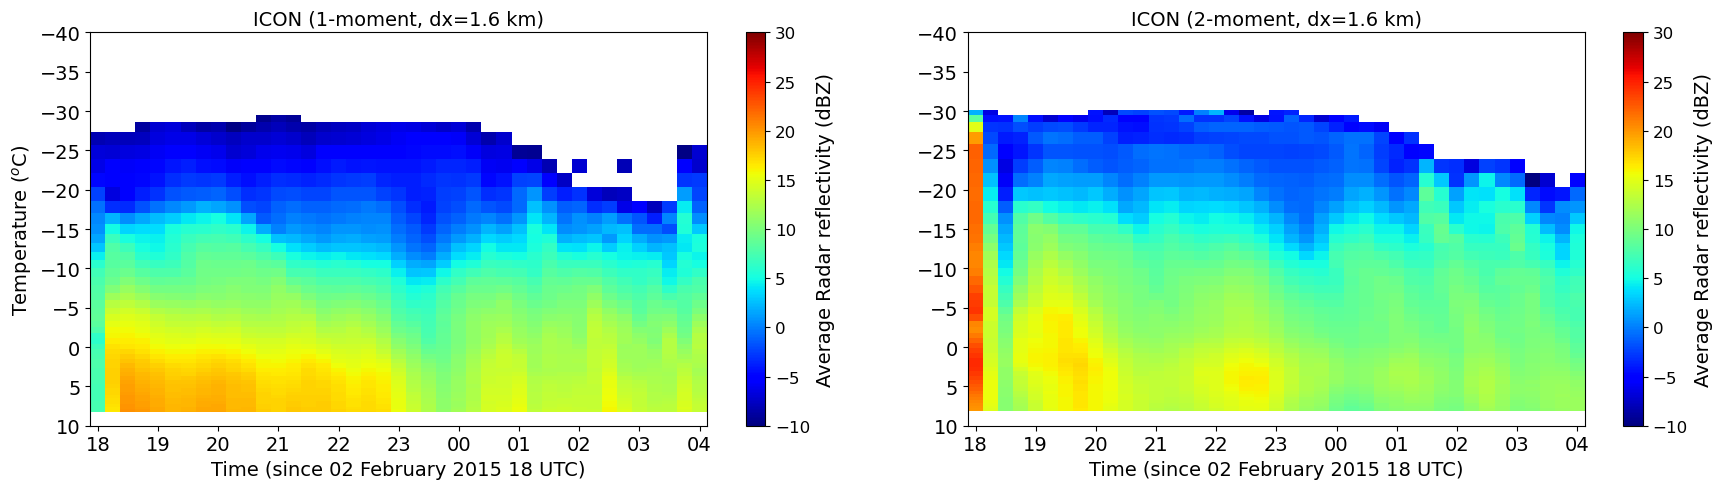

In [83]:
plt.figure(figsize=(18, 5))

# First subplot
plt.subplot(1, 2, 1)
contour = plt.pcolormesh(time_new_1mom, avg_ht_new_1mom, avg_dbz_new_1mom.T, cmap='jet', vmin=-10, vmax=30)
contour = plt.pcolormesh(time_new_1mom, avg_tempc_new_1mom, avg_dbz_new_1mom.T, cmap='jet', vmin=-10, vmax=30)

plt.xlabel('Time (since 02 February 2015 18 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
#plt.ylim([0, 14])
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14], fontsize=14)
plt.ylim([10, -40])
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)

#plt.ylabel('Altitude (km)', fontsize=14)
plt.ylabel('Temperature ($^{o}$C)', fontsize=14)

plt.title('ICON (1-moment, dx=1.6 km)', fontsize=14)
# Create a colorbar
cbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Average Radar reflectivity (dBZ)', orientation='vertical')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)

# Third subplot
plt.subplot(1, 2, 2)
contour=plt.pcolormesh(time_new_2mom, avg_tempc_new_2mom, avg_dbz_new_2mom.T, cmap='jet', vmin=-10, vmax=30)
plt.xlabel('Time (since 02 February 2015 18 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
#plt.ylim([0, 14]); 
#plt.yticks([0,2,4,6,8,10,12,14], fontsize=14)
plt.ylim([10, -40])
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)

#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (2-moment, dx=1.6 km)', fontsize=14)

# Create a colorbar
cbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Average Radar reflectivity (dBZ)', orientation='vertical')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)

# Adjust colorbar position
plt.subplots_adjust(bottom=0.2, right=0.5, top=0.9)  # Adjust the position of the colorbar

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_refl_time_ht.jpg', dpi=600, bbox_inches='tight')

plt.show()


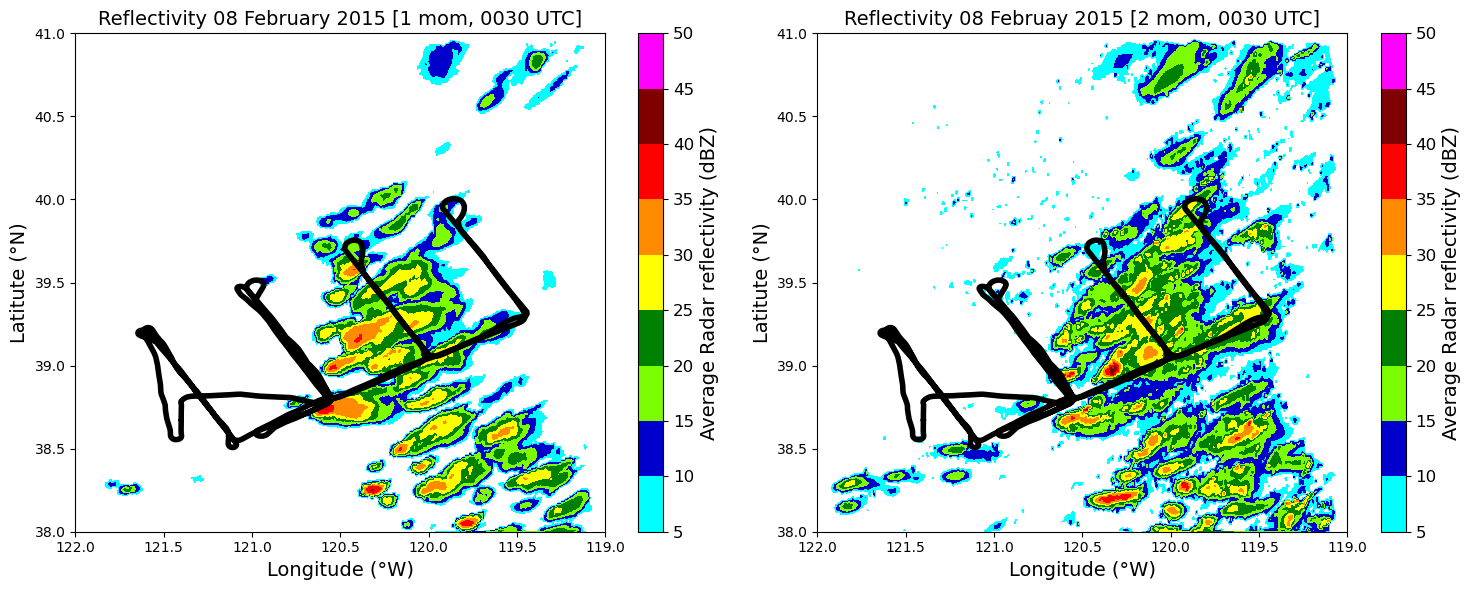

In [176]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

ds_acapex_1mom_1 = xr.open_mfdataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150208T003000Z.nc")
ds_acapex_2mom_1 = xr.open_mfdataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150208T003000Z.nc")
grid = xr.open_dataset("/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/domain4_DOM04.nc")

data_mc3e_1mom = ds_acapex_1mom_1
data_mc3e_2mom = ds_acapex_2mom_1


mask_cell=np.isin(data_mc3e_1mom['ncells'], selected_indices.cell)
ds_new_1mom = data_mc3e_1mom.sel(ncells=mask_cell)
ds_new_2mom = data_mc3e_2mom.sel(ncells=mask_cell)

grid_new = grid.sel(cell=mask_cell)

filtered_dbz_1mom = xr.where((ds_new_1mom.dbz > 4.9), ds_new_1mom.dbz, np.nan)
filtered_dbz_2mom = xr.where((ds_new_2mom.dbz > 4.9), ds_new_2mom.dbz, np.nan)

# Calculate the mean: time and height dimensions
avg_dbz_1mom = filtered_dbz_1mom.mean(dim=('time', 'height'))
avg_dbz_2mom = filtered_dbz_2mom.mean(dim=('time', 'height'))

# Extract longitude and latitude
clon_deg = -1.*np.degrees(grid_new.clon)
clat_deg = np.degrees(grid_new.clat)

# Set NaN values to a value outside the range of the colormap
masked_dbz_1mom = np.where(np.isnan(avg_dbz_1mom), 0., avg_dbz_1mom)
masked_dbz_2mom = np.where(np.isnan(avg_dbz_2mom), 0., avg_dbz_2mom)

# Define the colors
#colors = ['cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'goldenrod', 
#          'darkorange', 'red', 'firebrick', 'maroon', 'magenta', 'darkorchid', 'pink']

colors = ['cyan', 'mediumblue', 'lawngreen', 'green', 'yellow', 
          'darkorange', 'red', 'maroon', 'magenta']
cmap = ListedColormap(colors)

# Plot the contour

lon_citation_obs = np.array(lon_citation_obs)
lat_citation_obs = np.array(lat_citation_obs)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(-1.*lon_citation_obs,lat_citation_obs, 'k-', label='Citation aircraft', linewidth = 4)
contour = plt.tricontourf(clon_deg, clat_deg, masked_dbz_1mom, cmap=cmap, levels=np.linspace(5, 50, 100))
colorbar = plt.colorbar(contour, ticks=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50], label='Average Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlim([122, 119]); 
plt.ylim([38, 41]); 
#plt.xticks([99,98.5,98,97.5,97], fontsize=14)
#plt.yticks([36,36.5,37,37.5,38], fontsize=14)
plt.xlabel('Longitude (°W)',fontsize=14)
plt.ylabel('Latitute (°N)',fontsize=14)
plt.title('Reflectivity 08 February 2015 [1 mom, 0030 UTC]',fontsize=14)  

plt.subplot(1, 2, 2)
plt.plot(-1.*lon_citation_obs,lat_citation_obs, 'k-', label='Citation aircraft', linewidth = 4)
contour = plt.tricontourf(clon_deg, clat_deg, masked_dbz_2mom, cmap=cmap, levels=np.linspace(5, 50, 100))
colorbar = plt.colorbar(contour, ticks=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50], label='Average Radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlim([122, 119]); 
plt.ylim([38, 41]); 
#plt.xticks([99,98.5,98,97.5,97], fontsize=14)
#plt.yticks([36,36.5,37,37.5,38], fontsize=14)
plt.xlabel('Longitude (°W)',fontsize=14)
plt.ylabel('Latitute (°N)',fontsize=14)
plt.title('Reflectivity 08 Februay 2015 [2 mom, 0030 UTC]',fontsize=14)  


plt.tight_layout()
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/radar_refl_lat_lon/2015-02-08_00-30-00_acapex-icon.jpg', dpi=600, bbox_inches='tight')
plt.show()



In [177]:
import os
import datetime
import imageio

# Define the path to the directory containing the images
image_dir = '/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/radar_refl_lat_lon/'
out_dir = '/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/radar_refl_lat_lon/'
# Define the start and end times for the animation
start_time = datetime.datetime(2015, 2, 7, 18, 0, 0)
end_time = datetime.datetime(2015, 2, 8, 3, 0, 0)

# Get the list of image files within the specified time range
image_files = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_time = datetime.datetime.strptime(file[:19], '%Y-%m-%d_%H-%M-%S')
            if start_time <= file_time <= end_time:
                image_files.append(os.path.join(root, file))

# Sort the image files based on their timestamps
image_files.sort()

# Create the output directory if it doesn't exist
output_dir = os.path.join(out_dir, 'acapex_icon_refl_gifs')
os.makedirs(output_dir, exist_ok=True)

# Create an animated GIF with adjusted playback speed
output_file = os.path.join(output_dir, 'acapex_icon_refl_07Feb_180000_000000.gif')
fps = 1  # Frames per second (adjust this value to change playback speed)
with imageio.get_writer(output_file, mode='I', fps=fps) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Animated GIF created successfully at: {output_file}")


/tmp/ipykernel_741116/572006510.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animated GIF created successfully at: /work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/radar_refl_lat_lon/acapex_icon_refl_gifs/acapex_icon_refl_07Feb_180000_000000.gif


In [202]:

time_1mom = data_acapex_1mom_new['time'];
qv_1mom = data_acapex_1mom_new['qv'];
qc_1mom = data_acapex_1mom_new['qc'];
qi_1mom = data_acapex_1mom_new['qi'];
qs_1mom = data_acapex_1mom_new['qs'];
qr_1mom = data_acapex_1mom_new['qr'];
prec_1mom = data_acapex_1mom_new['tot_prec'];
temp_1mom = data_acapex_1mom_new['temp'];
dbz_1mom = data_acapex_1mom_new['dbz'];
ht_1mom = data_acapex_1mom_new['z_mc'];
rho_1mom = data_acapex_1mom_new['rho'];
pres_1mom = data_acapex_1mom_new['pres'];
omega_1mom = data_acapex_1mom_new['omega'];
vert_vel_1mom = -1.*omega_1mom/(9.8*rho_1mom);

# 2 moment
time_2mom = data_acapex_2mom_new['time'];
qv_2mom = data_acapex_2mom_new['qv'];
qc_2mom = data_acapex_2mom_new['qc'];
qi_2mom = data_acapex_2mom_new['qi'];
qs_2mom = data_acapex_2mom_new['qs'];
qg_2mom = data_acapex_2mom_new['qg'];
qh_2mom = data_acapex_2mom_new['qh'];
qr_2mom = data_acapex_2mom_new['qr'];

nc_2mom = data_acapex_2mom_new['qnc'];
ni_2mom = data_acapex_2mom_new['qni'];
ns_2mom = data_acapex_2mom_new['qns'];
ng_2mom = data_acapex_2mom_new['qng'];
nh_2mom = data_acapex_2mom_new['qnh'];
nr_2mom = data_acapex_2mom_new['qnr'];

prec_2mom = data_acapex_2mom_new['tot_prec'];
temp_2mom = data_acapex_2mom_new['temp'];
dbz_2mom = data_acapex_2mom_new['dbz'];
ht_2mom = data_acapex_2mom_new['z_mc'];
rho_2mom = data_acapex_2mom_new['rho'];
pres_2mom = data_acapex_2mom_new['pres'];
omega_2mom = data_acapex_2mom_new['omega'];
vert_vel_2mom = -1.*omega_2mom/(9.8*rho_2mom);


#rho_water = 1000.; # density of water (kg/m3)
#pie  = 3.1416; 
#drop_conc_2mom_perm3 = nc_2mom*rho_2mom;
#drop_eff_rad_2mom = (qc_2mom/(rho_water*pie*drop_conc_2mom_perm3))**(1/3)



In [203]:

#====================================================================================================================#
#========================================= Downdraft validation =====================================================#
#====================================================================================================================#



thres_q = 1.e-9;
thres_w_min = 2.
thres_w_max = 15.
thres_w = -1.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_1mom = xr.where((qv_1mom > thres_q), qv_1mom, np.nan)
filt_qc_1mom = xr.where((qc_1mom > thres_q) & (vert_vel_1mom < thres_w), qc_1mom, np.nan)
filt_qi_1mom = xr.where((qi_1mom > thres_q) & (vert_vel_1mom < thres_w), qi_1mom, np.nan)
filt_qs_1mom = xr.where((qs_1mom > thres_q) & (vert_vel_1mom < thres_w), qs_1mom, np.nan)
filt_qr_1mom = xr.where((qr_1mom > thres_q) & (vert_vel_1mom < thres_w), qr_1mom, np.nan)
filt_dbz_1mom = xr.where((dbz_1mom > -10.), dbz_1mom, np.nan)

avg_qv_1mom = filt_qv_1mom.mean(dim=('time','ncells'))
avg_qc_1mom = filt_qc_1mom.mean(dim=('time','ncells'))
avg_qi_1mom = filt_qi_1mom.mean(dim=('time','ncells'))
avg_qs_1mom = filt_qs_1mom.mean(dim=('time','ncells'))
avg_qr_1mom = filt_qr_1mom.mean(dim=('time','ncells'))

avg_dbz_1mom = filt_dbz_1mom.mean(dim=('time','ncells'))
avg_temp_1mom = temp_1mom.mean(dim=('time','ncells'))
avg_ht_1mom = ht_1mom.mean(dim=('time','ncells'))
avg_pres_1mom = pres_1mom.mean(dim=('time','ncells'))

lwc_1mom = filt_qc_1mom*rho_1mom*1.e3 # kgperm3 to gperm3
iwc_1mom = (filt_qi_1mom+filt_qs_1mom)*rho_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_1mom = lwc_1mom.mean(dim=('time','ncells'))
avg_iwc_1mom = iwc_1mom.mean(dim=('time','ncells'))
avg_tempc_1mom = avg_temp_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_2mom = xr.where((qv_2mom > thres_q), qv_2mom, np.nan)
filt_qc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom < thres_w), qc_2mom, np.nan)
filt_qi_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom < thres_w), qi_2mom, np.nan)
filt_qs_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom < thres_w), qs_2mom, np.nan)
filt_qg_2mom = xr.where((qg_2mom > thres_q) & (vert_vel_2mom < thres_w), qg_2mom, np.nan)
filt_qh_2mom = xr.where((qh_2mom > thres_q) & (vert_vel_2mom < thres_w), qh_2mom, np.nan)
filt_qr_2mom = xr.where((qr_2mom > thres_q) & (vert_vel_2mom < thres_w), qr_2mom, np.nan)
filt_dbz_2mom = xr.where((dbz_2mom > -10.), dbz_2mom, np.nan)

avg_qv_2mom = filt_qv_2mom.mean(dim=('time','ncells'))
avg_qc_2mom = filt_qc_2mom.mean(dim=('time','ncells'))
avg_qi_2mom = filt_qi_2mom.mean(dim=('time','ncells'))
avg_qs_2mom = filt_qs_2mom.mean(dim=('time','ncells'))
avg_qr_2mom = filt_qr_2mom.mean(dim=('time','ncells'))

avg_dbz_2mom = filt_dbz_2mom.mean(dim=('time','ncells'))
avg_temp_2mom = temp_2mom.mean(dim=('time','ncells'))
avg_ht_2mom = ht_2mom.mean(dim=('time','ncells'))
avg_pres_2mom = pres_2mom.mean(dim=('time','ncells'))

lwc_2mom = filt_qc_2mom*rho_2mom*1.e3 # kgperm3 to gperm3
iwc_2mom = (filt_qi_2mom+filt_qs_2mom+filt_qg_2mom+filt_qh_2mom)*rho_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_2mom = lwc_2mom.mean(dim=('time','ncells'))
avg_iwc_2mom = iwc_2mom.mean(dim=('time','ncells'))
avg_tempc_2mom = avg_temp_2mom-273.16; 

#filt_drop_eff_rad_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom < thres_w), drop_eff_rad_2mom, np.nan); 
#avg_drop_eff_rad_um = 1.e6*filt_drop_eff_rad_2mom.mean(dim=('time','ncells'))
#avg_drop_eff_rad_um = np.nan_to_num(avg_drop_eff_rad_um, nan=0.0, posinf=0.0, neginf=0.0) 

filt_nc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom < thres_w), nc_2mom, np.nan) 

filt_ni_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom < thres_w), ni_2mom, np.nan) 
filt_ns_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom < thres_w), ns_2mom, np.nan) 
filt_ng_2mom = xr.where((qg_2mom > thres_q) & (vert_vel_2mom < thres_w), ng_2mom, np.nan)
filt_nh_2mom = xr.where((qh_2mom > thres_q) & (vert_vel_2mom < thres_w), nh_2mom, np.nan)

#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



#avg_drop_eff_rad_um = 1.e6*filt_drop_eff_rad_2mom.mean(dim=('time','ncells'))
#avg_drop_eff_rad_um = np.nan_to_num(avg_drop_eff_rad_um, nan=0.0, posinf=0.0, neginf=0.0)


nc_2mom_percm3 = filt_nc_2mom*rho_2mom/1.e6;
ni_2mom_percm3 = filt_ni_2mom*rho_2mom/1.e6;
ns_2mom_percm3 = filt_ns_2mom*rho_2mom/1.e6;
ng_2mom_percm3 = filt_ng_2mom*rho_2mom/1.e6;
nh_2mom_percm3 = filt_nh_2mom*rho_2mom/1.e6;

nc_2mom_perl = nc_2mom_percm3*1.e3;
ni_2mom_perl = ni_2mom_percm3*1.e3;
ns_2mom_perl = ns_2mom_percm3*1.e3;
ng_2mom_perl = ng_2mom_percm3*1.e3;
nh_2mom_perl = nh_2mom_percm3*1.e3;

avg_nc_2mom_percm3 = nc_2mom_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_percm3 = ni_2mom_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_percm3 = ns_2mom_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_percm3 = ng_2mom_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_percm3 = nh_2mom_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_perl = nc_2mom_perl.mean(dim=('time','ncells'))
avg_ni_2mom_perl = ni_2mom_perl.mean(dim=('time','ncells'))
avg_ns_2mom_perl = ns_2mom_perl.mean(dim=('time','ncells'))
avg_ng_2mom_perl = ng_2mom_perl.mean(dim=('time','ncells'))
avg_nh_2mom_perl = nh_2mom_perl.mean(dim=('time','ncells'))

avg_totice_2mom_perl = avg_ni_2mom_perl+avg_ns_2mom_perl+avg_ng_2mom_perl+avg_nh_2mom_perl


#================== Droplet effective radius
nc_2mom_perm3 = avg_nc_2mom_percm3*1.e6;

rho_water = 1000.; # density of water (kg/m3)
pie  = 3.1416; 

avg_drop_eff_rad_1mom_m = ((3.*avg_qc_1mom)/(4.*rho_water*pie*nc_1mom_perm3))**(1./3.) # Marchell-Palmar eqn
avg_drop_eff_rad_1mom_um = avg_drop_eff_rad_1mom_m*1.e6;

avg_drop_eff_rad_2mom_m = ((3.*avg_qc_2mom)/(4.*rho_water*pie*nc_2mom_perm3))**(1./3.) # Marchell-Palmar eqn
avg_drop_eff_rad_2mom_um = avg_drop_eff_rad_2mom_m*1.e6;


In [181]:
# Observations
# Initialize empty lists for each column for droplet mean diameter

temp_obs_conc_cdp = []
num_drop_cdp = []
std_dev_num_drop_cdp = []
std_err_num_drop_cdp = []

temp_obs_lwc_cdp = []
lwc_cdp = []
std_dev_lwc_cdp = []
std_err_lwc_cdp = []

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/cld_drop_num_conc_cdp_acapex_downdraft_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_conc_cdp.append(float(columns[0]))
        num_drop_cdp.append(float(columns[1]))
        std_dev_num_drop_cdp.append(float(columns[2]))
        std_err_num_drop_cdp.append(float(columns[3]))

#### CDP CDNC
temp_obs_conc_cdp = np.array(temp_obs_conc_cdp)
num_drop_cdp = np.array(num_drop_cdp)
std_dev_num_drop_cdp = np.array(std_dev_num_drop_cdp)
std_err_num_drop_cdp = np.array(std_err_num_drop_cdp)

num_drop_cdp[(num_drop_cdp <= 0)] = np.nan

print(len(temp_obs_conc_cdp))

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/LWC_gperm3_T_downdraft', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_lwc_cdp.append(float(columns[0]))
        lwc_cdp.append(float(columns[1]))
        std_dev_lwc_cdp.append(float(columns[2]))
        std_err_lwc_cdp.append(float(columns[3]))

#### CDP LWC
temp_obs_lwc_cdp = np.array(temp_obs_lwc_cdp)
lwc_cdp = np.array(lwc_cdp)
std_dev_lwc_cdp = np.array(std_dev_lwc_cdp)
std_err_lwc_cdp = np.array(std_err_lwc_cdp)

lwc_cdp[(lwc_cdp <= 0)] = np.nan

print(len(temp_obs_lwc_cdp))


#####################################################################
temp_ni_obs = []
num_ice_2ds = []
std_dev_num_ice_2ds = []
std_err_num_ice_2ds = []


# Open the text file
with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/ni200um_acapex_downdraft_perl', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_ni_obs.append(float(columns[0]))
        num_ice_2ds.append(float(columns[1]))
        std_dev_num_ice_2ds.append(float(columns[2]))
        std_err_num_ice_2ds.append(float(columns[3]))

#### CIP
temp_ni_obs = np.array(temp_ni_obs)
num_ice_2ds = np.array(num_ice_2ds)
std_dev_num_ice_2ds = np.array(std_dev_num_ice_2ds)
std_err_num_ice_2ds = np.array(std_err_num_ice_2ds)

#std_dev_num_ice_2ds = std_dev_num_ice_2ds*1.e3;
#std_err_num_ice_2ds = std_err_num_ice_2ds*1.e3;

num_ice_2ds[(num_ice_2ds <= 0)] = np.nan


temp_obs_iwc_2ds = []
iwc_2ds = []
std_dev_iwc_2ds = []
std_err_iwc_2ds = []

# Open the text file
with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/iwc_acapex_downdraft_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_iwc_2ds.append(float(columns[0]))
        iwc_2ds.append(float(columns[1]))
        std_dev_iwc_2ds.append(float(columns[2]))
        std_err_iwc_2ds.append(float(columns[3]))

#### CIP
temp_obs_iwc_2ds = np.array(temp_obs_iwc_2ds)
iwc_2ds = np.array(iwc_2ds)
std_dev_iwc_2ds = np.array(std_dev_iwc_2ds)
std_err_iwc_2ds = np.array(std_err_iwc_2ds)

#std_dev_num_ice_2ds = std_dev_num_ice_2ds*1.e3;
#std_err_num_ice_2ds = std_err_num_ice_2ds*1.e3;

iwc_2ds[(iwc_2ds <= 0)] = np.nan


16
20


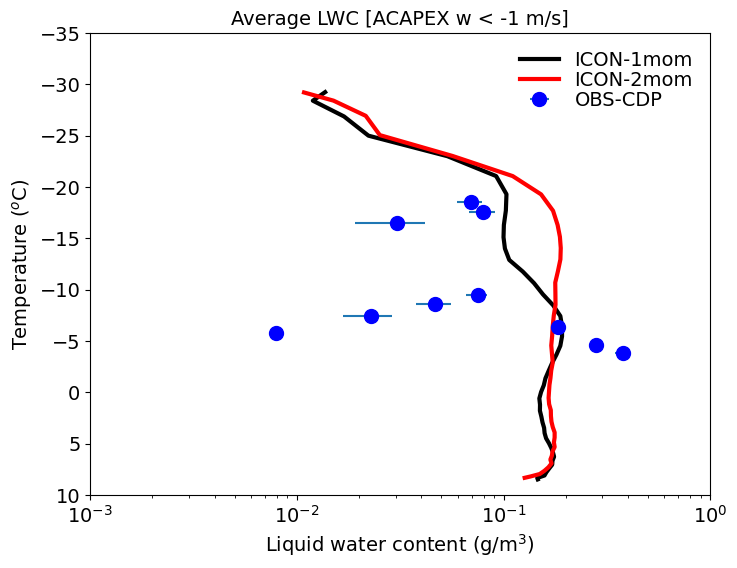

In [182]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_lwc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_lwc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.errorbar(lwc_cdp, temp_obs_lwc_cdp, xerr=std_err_lwc_cdp, fmt='o' , label='OBS-CDP', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e0)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e0], fontsize=fontsize)
plt.ylim(10, -35)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Liquid water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average LWC [ACAPEX w < -1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_lwc_validation_downdraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

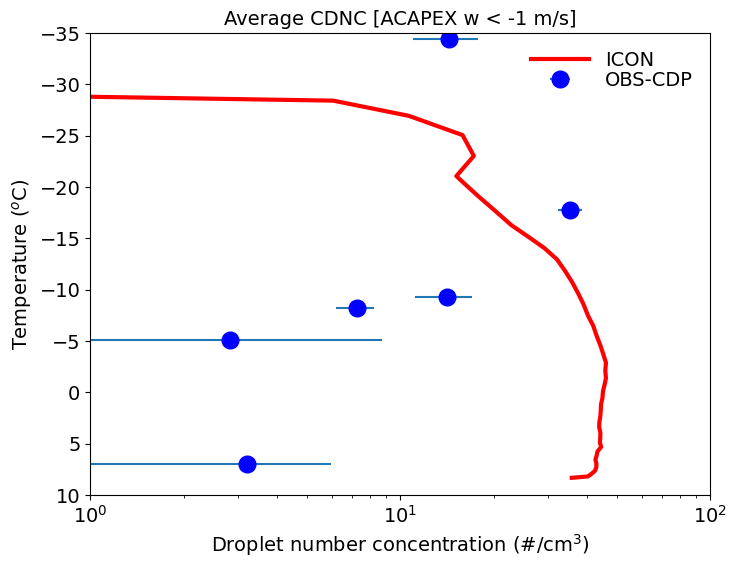

In [183]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_nc_2mom_percm3,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
plt.errorbar(num_drop_cdp, temp_obs_conc_cdp, xerr=1.e-5*std_err_num_drop_cdp, fmt='o' , label='OBS-CDP', markersize=12,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e0, 1.e2)
plt.xticks([1.e0,1.e1,1.e2], fontsize=fontsize)
plt.ylim(10, -35)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Droplet number concentration (#/cm$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average CDNC [ACAPEX w < -1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_cdnc_validation_downdraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

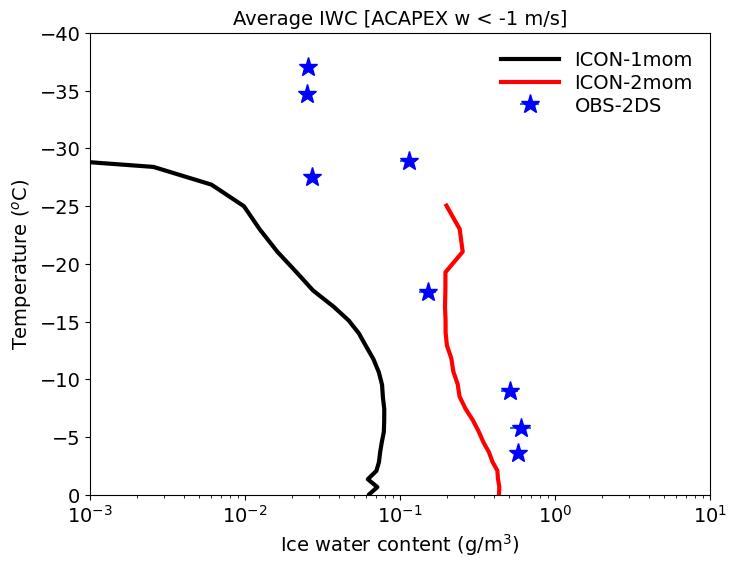

In [184]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_iwc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_iwc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.errorbar(iwc_2ds, temp_obs_iwc_2ds, xerr=std_err_iwc_2ds, fmt='*' , label='OBS-2DS', markersize=14,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average IWC [ACAPEX w < -1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_iwc_validation_downdraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

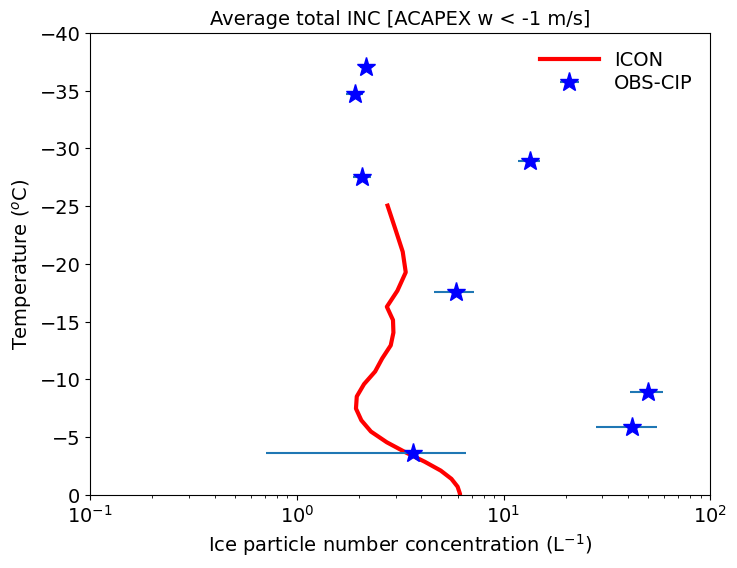

In [186]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_totice_2mom_perl,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
plt.errorbar(num_ice_2ds, temp_ni_obs, xerr=std_err_num_ice_2ds, fmt='*' , label='OBS-CIP', markersize=14,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-1, 1.e2)
plt.xticks([1.e-1,1.e0,1.e1,1.e2], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice particle number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average total INC [ACAPEX w < -1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_icnc_validation_downdraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

In [210]:

#====================================================================================================================#
#========================================= stratiform validation ====================================================#
#====================================================================================================================#

ds_acapex_1mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc');
ds_acapex_1mom_2 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc');

data_acapex_1mom = xr.concat([ds_acapex_1mom_1, ds_acapex_1mom_2], dim="time")


ds_acapex_2mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc');
ds_acapex_2mom_2 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc');

data_acapex_2mom = xr.concat([ds_acapex_2mom_1, ds_acapex_2mom_2], dim="time")

grid_acapex = xr.open_dataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/domain4_DOM04.nc');

clon_grid = -1.*np.degrees(grid_acapex.clon)
clat_grid = np.degrees(grid_acapex.clat)

time_1mom = data_acapex_1mom['time'];
qv_1mom = data_acapex_1mom['qv'];
qc_1mom = data_acapex_1mom['qc'];
qi_1mom = data_acapex_1mom['qi'];
qs_1mom = data_acapex_1mom['qs'];
qr_1mom = data_acapex_1mom['qr'];
prec_1mom = data_acapex_1mom['tot_prec'];
temp_1mom = data_acapex_1mom['temp'];
tempc_1mom = temp_1mom-273.16;

dbz_1mom = data_acapex_1mom['dbz'];
ht_1mom = data_acapex_1mom['z_mc'];
rho_1mom = data_acapex_1mom['rho'];
pres_1mom = data_acapex_1mom['pres'];
omega_1mom = data_acapex_1mom['omega'];
vert_vel_1mom = -1.*omega_1mom/(9.8*rho_1mom);

# 2 moment
time_2mom = data_acapex_2mom['time'];
qv_2mom = data_acapex_2mom['qv'];
qc_2mom = data_acapex_2mom['qc'];
qi_2mom = data_acapex_2mom['qi'];
qs_2mom = data_acapex_2mom['qs'];
qg_2mom = data_acapex_2mom['qg'];
qh_2mom = data_acapex_2mom['qh'];
qr_2mom = data_acapex_2mom['qr'];

nc_2mom = data_acapex_2mom['qnc'];
ni_2mom = data_acapex_2mom['qni'];
ns_2mom = data_acapex_2mom['qns'];
ng_2mom = data_acapex_2mom['qng'];
nh_2mom = data_acapex_2mom['qnh'];
nr_2mom = data_acapex_2mom['qnr'];

prec_2mom = data_acapex_2mom['tot_prec'];
temp_2mom = data_acapex_2mom['temp'];
tempc_2mom = temp_2mom-273.16;

dbz_2mom = data_acapex_2mom['dbz'];
ht_2mom = data_acapex_2mom['z_mc'];
rho_2mom = data_acapex_2mom['rho'];
pres_2mom = data_acapex_2mom['pres'];
omega_2mom = data_acapex_2mom['omega'];
vert_vel_2mom = -1.*omega_2mom/(9.8*rho_2mom);

filt_precip_1mom = xr.where(prec_1mom > 0., prec_1mom, np.nan)
filt_precip_2mom = xr.where(prec_2mom > 0., prec_2mom, np.nan)

avg_precip_1mom = filt_precip_1mom.mean("time")
avg_precip_2mom = filt_precip_2mom.mean("time")

masked_precip_1mom = np.where(np.isnan(avg_precip_1mom), 0., avg_precip_1mom)
masked_precip_2mom = np.where(np.isnan(avg_precip_2mom), 0., avg_precip_2mom)

#filt_precip_1mom = xr.where((ds_mc3e_1mom.tot_prec > 0.), ds_mc3e_1mom.tot_prec, np.nan)
#avg_precip_1mom = filt_precip_1mom.mean(dim=('time'))
#masked_precip_1mom = np.where(np.isnan(avg_precip_1mom), 0., avg_precip_1mom)

#filt_precip_2mom = xr.where((ds_mc3e_2mom.tot_prec > 0.), ds_mc3e_2mom.tot_prec, np.nan)
#avg_precip_2mom = filt_precip_2mom.mean(dim=('time'))
#masked_precip_2mom = np.where(np.isnan(avg_precip_2mom), 0., avg_precip_2mom)

#rho_water = 1000.; # density of water (kg/m3)
#pie  = 3.1416; 
#drop_conc_2mom_perm3 = nc_2mom*rho_2mom;
#drop_eff_rad_2mom = (qc_2mom/(rho_water*pie*drop_conc_2mom_perm3))**(1/3) # Marchell-Palmar eqn

thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.

rho_water = 1000.; # density of water (kg/m3)
pie  = 3.1416; 

filt_drop_num_2mom = xr.where((qc_2mom > 1.e-12) & (nc_2mom > 0.), nc_2mom, np.nan)
drop_conc_2mom_perm3 = filt_drop_num_2mom*rho_2mom;
drop_eff_rad_2mom_um = 1.e6*(qc_2mom/(rho_water*pie*drop_conc_2mom_perm3))**(1./3.)




In [ ]:
print(masked_precip_1mom.min())
print(masked_precip_1mom.max())

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
contour = plt.tricontourf(clon_grid, clat_grid, masked_precip_1mom, cmap='jet', levels=np.linspace(0, 50, 100))
#colorbar = plt.colorbar(contour, ticks=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70], label='Surface precipitation (mm)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Surface precipitation (mm)', size=14)
plt.xlim([100, 94]); 
plt.ylim([32, 38]); 
plt.xticks([100,99,98,97,96,95,94], fontsize=14)
plt.yticks([32,33,34,35,36,37,38], fontsize=14)
plt.xlabel('Longitude (°W)',fontsize=14)
plt.ylabel('Latitute (°N)',fontsize=14)
plt.title('Surface precipitation 11 May 2011 [1 mom]',fontsize=14) 


plt.subplot(1, 2, 2)
contour = plt.tricontourf(clon_grid, clat_grid, masked_precip_2mom, cmap='jet', levels=np.linspace(0, 50, 100))
colorbar = plt.colorbar(contour, ticks=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], label='Surface precipitation (mm)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Surface precipitation (mm)', size=14)
plt.xlim([100, 94]); 
plt.ylim([32, 38]); 
plt.xticks([100,99,98,97,96,95,94], fontsize=14)
plt.yticks([32,33,34,35,36,37,38], fontsize=14)
plt.xlabel('Longitude (°W)',fontsize=14)
plt.ylabel('Latitute (°N)',fontsize=14)
plt.title('Surface precipitation 11 May 2011 [2 mom]',fontsize=14)  

In [29]:
num_temp_bin = 30;
num_w_bin = 30;

temp_bin = np.linspace(tempc_1mom.min(), tempc_1mom.max(), num_temp_bin+1)
wvel_bin = np.linspace(vert_vel_1mom.min(), vert_vel_1mom.max(), num_w_bin+1)

print(temp_bin)

print(wvel_bin)

[-75.81462097 -72.19115346 -68.56768595 -64.94421844 -61.32075094
 -57.69728343 -54.07381592 -50.45034841 -46.8268809  -43.20341339
 -39.57994588 -35.95647837 -32.33301086 -28.70954336 -25.08607585
 -21.46260834 -17.83914083 -14.21567332 -10.59220581  -6.9687383
  -3.34527079   0.27819672   3.90166423   7.52513173  11.14859924
  14.77206675  18.39553426  22.01900177  25.64246928  29.26593679
  32.8894043 ]
[-14.58665752 -12.93823862 -11.28981972  -9.64140081  -7.99298191
  -6.34456301  -4.6961441   -3.0477252   -1.3993063    0.24911261
   1.89753151   3.54595041   5.19436932   6.84278822   8.49120712
  10.13962603  11.78804493  13.43646383  15.08488274  16.73330164
  18.38172054  20.03013945  21.67855835  23.32697725  24.97539616
  26.62381506  28.27223396  29.92065287  31.56907177  33.21749067
  34.86590958]


/tmp/ipykernel_741116/966151749.py:16: RuntimeWarning: invalid value encountered in divide
  avg_cldliq_temp_w_1mom = cldliq_sum_1mom/hist_1mom
/tmp/ipykernel_741116/966151749.py:27: RuntimeWarning: invalid value encountered in divide
  avg_cldliq_temp_w_2mom = cldliq_sum_2mom/hist_2mom


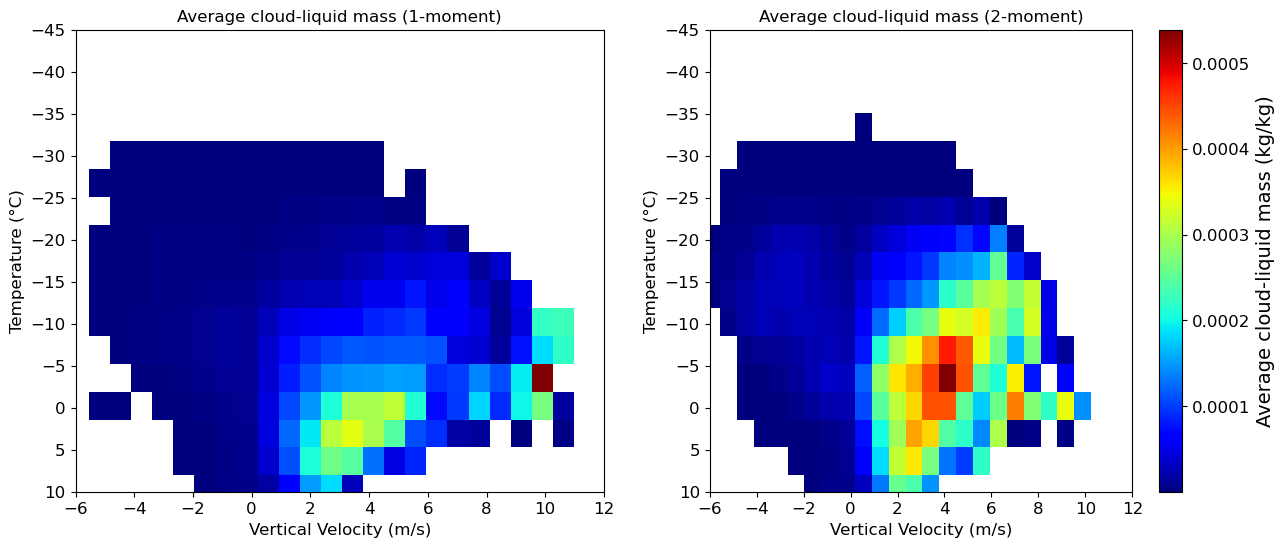

In [212]:
num_temp_bin = 30;
num_w_bin = 30;

temp_bin = np.linspace(tempc_1mom.min(), tempc_1mom.max(), num_temp_bin+1)
wvel_bin = np.linspace(vert_vel_1mom.min(), vert_vel_1mom.max(), num_w_bin+1)

#============== 1-moment
hist_1mom, temp_edges_1mom, vert_vel_edges_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin))

filt_qc_1mom = xr.where(qc_1mom > 1.e-9, qc_1mom, np.nan)

filt_cldliq_1mom = qc_1mom; #filt_qc_1mom

cldliq_sum_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_cldliq_1mom.values.flatten())[0]

avg_cldliq_temp_w_1mom = cldliq_sum_1mom/hist_1mom
avg_cldliq_temp_w_1mom[avg_cldliq_temp_w_1mom < 1.e-9] = np.nan

#============== 2-moment
hist_2mom, temp_edges_2mom, vert_vel_edges_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin))
filt_qc_2mom = xr.where(qc_2mom > 1.e-9, qc_2mom, np.nan)

filt_cldliq_2mom = qc_2mom; #filt_qc_2mom

cldliq_sum_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_cldliq_2mom.values.flatten())[0]

avg_cldliq_temp_w_2mom = cldliq_sum_2mom/hist_2mom
avg_cldliq_temp_w_2mom[avg_cldliq_temp_w_2mom < 1.e-9] = np.nan

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
contour=plt.imshow(avg_cldliq_temp_w_1mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')

#colorbar = plt.colorbar(contour, ticks=[1.e-4,1.e-3,1.e-2], label='Average snow mass (kg/kg)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Average snow mass (kg/kg)', size=14)

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
#colorbar=plt.colorbar(label='Average cloud-liquid mass (kg/kg)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Average cloud-liquid mass (kg/kg)', size=14)
plt.title('Average cloud-liquid mass (1-moment)', fontsize=12)


plt.subplot(1,2,2)
plt.imshow(avg_cldliq_temp_w_2mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')
#plt.imshow(avg_qc_temp_w.T, extent=[wvel_bin[0], wvel_bin[-1], temp_bin[-1], temp_bin[0]], aspect='auto', origin='lower',cmap='jet')

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
colorbar=plt.colorbar(label='Average cloud-liquid mass (kg/kg)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average cloud-liquid mass (kg/kg)', size=14)
plt.title('Average cloud-liquid mass (2-moment)', fontsize=12)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/other_analysis/acapex_cldliq_mass_temp_w.jpg', dpi=600, bbox_inches='tight')

plt.show()


/tmp/ipykernel_741116/2864004493.py:18: RuntimeWarning: invalid value encountered in divide
  avg_cldice_temp_w_1mom = cldice_sum_1mom/hist_1mom
/tmp/ipykernel_741116/2864004493.py:32: RuntimeWarning: invalid value encountered in divide
  avg_cldice_temp_w_2mom = cldice_sum_2mom/hist_2mom


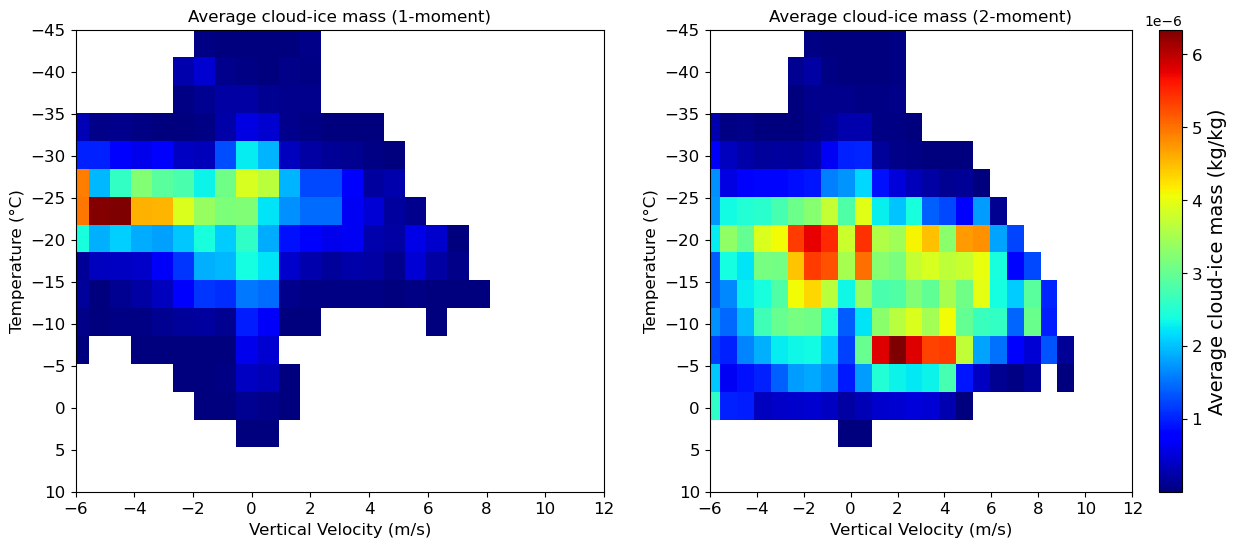

In [207]:
num_temp_bin = 30;
num_w_bin = 30;

temp_bin = np.linspace(tempc_1mom.min(), tempc_1mom.max(), num_temp_bin+1)
wvel_bin = np.linspace(vert_vel_1mom.min(), vert_vel_1mom.max(), num_w_bin+1)

#============== 1-moment
hist_1mom, temp_edges_1mom, vert_vel_edges_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin))

filt_qi_1mom = xr.where(qi_1mom > 1.e-9, qi_1mom, np.nan)
filt_qs_1mom = xr.where(qs_1mom > 1.e-9, qs_1mom, np.nan)

filt_cldice_1mom = qi_1mom; #filt_qi_1mom
filt_snow_1mom = qs_1mom; #filt_qs_1mom

cldice_sum_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_cldice_1mom.values.flatten())[0]

avg_cldice_temp_w_1mom = cldice_sum_1mom/hist_1mom
avg_cldice_temp_w_1mom[avg_cldice_temp_w_1mom < 1.e-9] = np.nan

#============== 2-moment
hist_2mom, temp_edges_2mom, vert_vel_edges_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin))
filt_qi_2mom = xr.where(qi_2mom > 1.e-9, qi_2mom, np.nan)
filt_qs_2mom = xr.where(qs_2mom > 1.e-9, qs_2mom, np.nan)


filt_cldice_2mom = qi_2mom; #filt_qi_2mom
filt_snow_2mom = qs_2mom; #filt_qs_2mom

cldice_sum_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_cldice_2mom.values.flatten())[0]

avg_cldice_temp_w_2mom = cldice_sum_2mom/hist_2mom
avg_cldice_temp_w_2mom[avg_cldice_temp_w_2mom < 1.e-9] = np.nan

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
contour=plt.imshow(avg_cldice_temp_w_1mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')

#colorbar = plt.colorbar(contour, ticks=[1.e-4,1.e-3,1.e-2], label='Average snow mass (kg/kg)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Average snow mass (kg/kg)', size=14)

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
#colorbar=plt.colorbar(label='Average snow mass (kg/kg)')
plt.title('Average cloud-ice mass (1-moment)', fontsize=12)


plt.subplot(1,2,2)
plt.imshow(avg_cldice_temp_w_2mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')
#plt.imshow(avg_qc_temp_w.T, extent=[wvel_bin[0], wvel_bin[-1], temp_bin[-1], temp_bin[0]], aspect='auto', origin='lower',cmap='jet')

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
colorbar=plt.colorbar(label='Average cloud-ice mass (kg/kg)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average cloud-ice mass (kg/kg)', size=14)
plt.title('Average cloud-ice mass (2-moment)', fontsize=12)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/other_analysis/acapex_cldice_mass_temp_w.jpg', dpi=600, bbox_inches='tight')

plt.show()


/tmp/ipykernel_741116/522885672.py:17: RuntimeWarning: invalid value encountered in divide
  avg_snow_temp_w_1mom = snow_sum_1mom/hist_1mom
/tmp/ipykernel_741116/522885672.py:31: RuntimeWarning: invalid value encountered in divide
  avg_snow_temp_w_2mom = snow_sum_2mom/hist_2mom


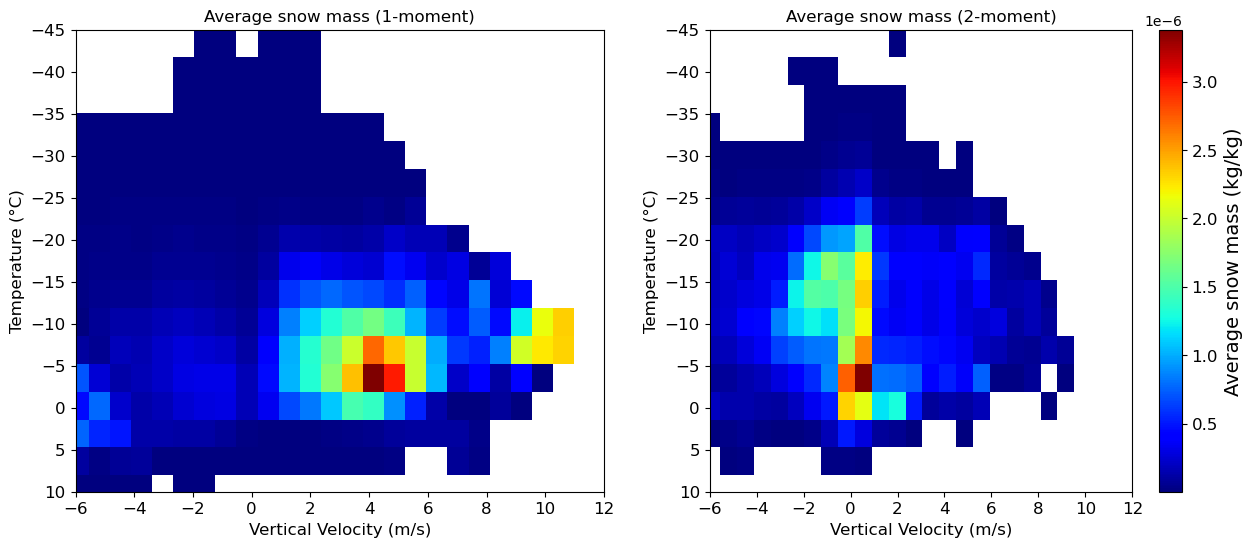

In [208]:
num_temp_bin = 30;
num_w_bin = 30;

temp_bin = np.linspace(tempc_1mom.min(), tempc_1mom.max(), num_temp_bin+1)
wvel_bin = np.linspace(vert_vel_1mom.min(), vert_vel_1mom.max(), num_w_bin+1)

#============== 1-moment
hist_1mom, temp_edges_1mom, vert_vel_edges_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin))

filt_qi_1mom = xr.where(qi_1mom > 1.e-9, qi_1mom, np.nan)
filt_qs_1mom = xr.where(qs_1mom > 1.e-9, qs_1mom, np.nan)

filt_snow_1mom = qs_1mom#filt_qs_1mom

snow_sum_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_snow_1mom.values.flatten())[0]

avg_snow_temp_w_1mom = snow_sum_1mom/hist_1mom
avg_snow_temp_w_1mom[avg_snow_temp_w_1mom < 1.e-9] = np.nan

#avg_snow_temp_w_1mom = np.divide(snow_sum_1mom, hist_1mom, out=np.full_like(hist_1mom, np.nan), where=hist_1mom != 0)

#============== 2-moment
hist_2mom, temp_edges_2mom, vert_vel_edges_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin))
filt_qi_2mom = xr.where(qi_2mom > 1.e-9, qi_2mom, np.nan)
filt_qs_2mom = xr.where(qs_2mom > 1.e-9, qs_2mom, np.nan)

filt_snow_2mom = qs_2mom;#filt_qs_2mom

snow_sum_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_snow_2mom.values.flatten())[0]

avg_snow_temp_w_2mom = snow_sum_2mom/hist_2mom
avg_snow_temp_w_2mom[avg_snow_temp_w_2mom < 1.e-9] = np.nan

#avg_snow_temp_w_2mom = np.divide(snow_sum_2mom, hist_2mom, out=np.full_like(hist_2mom, np.nan), where=hist_2mom != 0)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
contour=plt.imshow(avg_snow_temp_w_1mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')

#colorbar = plt.colorbar(contour, ticks=[1.e-4,1.e-3,1.e-2], label='Average snow mass (kg/kg)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Average snow mass (kg/kg)', size=14)

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
#colorbar=plt.colorbar(label='Average snow mass (kg/kg)')
plt.title('Average snow mass (1-moment)', fontsize=12)


plt.subplot(1,2,2)
plt.imshow(avg_snow_temp_w_2mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')
#plt.imshow(avg_qc_temp_w.T, extent=[wvel_bin[0], wvel_bin[-1], temp_bin[-1], temp_bin[0]], aspect='auto', origin='lower',cmap='jet')

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
colorbar=plt.colorbar(label='Average snow mass (kg/kg)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average snow mass (kg/kg)', size=14)
plt.title('Average snow mass (2-moment)', fontsize=12)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/other_analysis/acapex_snow_mass_temp_w.jpg', dpi=600, bbox_inches='tight')

plt.show()


/tmp/ipykernel_741116/2910776570.py:16: RuntimeWarning: invalid value encountered in divide
  avg_dbz_temp_w_1mom = dbz_sum_1mom/hist_1mom
/tmp/ipykernel_741116/2910776570.py:27: RuntimeWarning: invalid value encountered in divide
  avg_dbz_temp_w_2mom = dbz_sum_2mom/hist_2mom


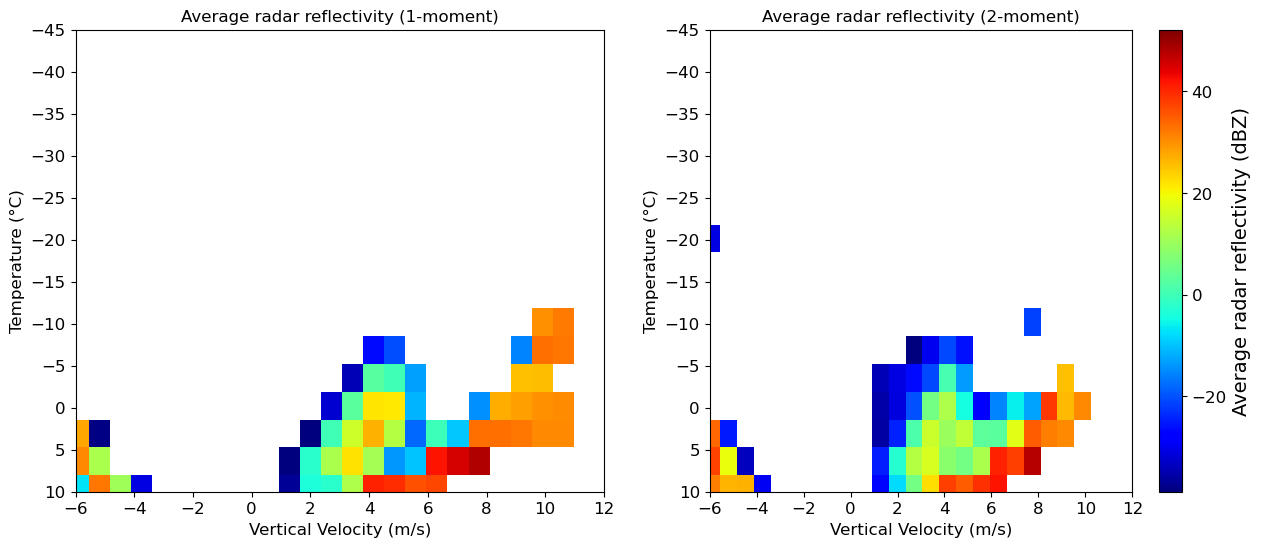

In [209]:
num_temp_bin = 30;
num_w_bin = 30;

temp_bin = np.linspace(tempc_1mom.min(), tempc_1mom.max(), num_temp_bin+1)
wvel_bin = np.linspace(vert_vel_1mom.min(), vert_vel_1mom.max(), num_w_bin+1)

#============== 1-moment
hist_1mom, temp_edges_1mom, vert_vel_edges_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin))

filt_dbz_1mom = xr.where(dbz_1mom > -2000., dbz_1mom, np.nan)

filt_dbz_1mom = filt_dbz_1mom;#filt_dbz_1mom

dbz_sum_1mom = np.histogram2d(tempc_1mom.values.flatten(), vert_vel_1mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_dbz_1mom.values.flatten())[0]

avg_dbz_temp_w_1mom = dbz_sum_1mom/hist_1mom
avg_dbz_temp_w_1mom[avg_dbz_temp_w_1mom < -40.] = np.nan

#============== 2-moment
hist_2mom, temp_edges_2mom, vert_vel_edges_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin))
filt_dbz_2mom = xr.where(dbz_2mom > -2000., dbz_2mom, np.nan)

filt_dbz_2mom = filt_dbz_2mom;#filt_dbz_2mom

dbz_sum_2mom = np.histogram2d(tempc_2mom.values.flatten(), vert_vel_2mom.values.flatten(), bins=(temp_bin, wvel_bin), weights = filt_dbz_2mom.values.flatten())[0]

avg_dbz_temp_w_2mom = dbz_sum_2mom/hist_2mom
avg_dbz_temp_w_2mom[avg_dbz_temp_w_2mom < -40.] = np.nan

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
contour=plt.imshow(avg_dbz_temp_w_1mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')

#colorbar = plt.colorbar(contour, ticks=[1.e-4,1.e-3,1.e-2], label='Average snow mass (kg/kg)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Average snow mass (kg/kg)', size=14)

plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
#colorbar=plt.colorbar(label='Average snow mass (kg/kg)')
plt.title('Average radar reflectivity (1-moment)', fontsize=12)


plt.subplot(1,2,2)

plt.imshow(avg_dbz_temp_w_2mom, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], aspect='auto', origin='lower',cmap='jet')
plt.xlim(-6, 12)
plt.xticks([-6, -4, -2, 0, 2, 4, 6, 8, 10,12], fontsize=12)
plt.ylim(10, -45)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45], fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xlabel('Vertical Velocity (m/s)', fontsize=12)
colorbar=plt.colorbar(ticks=[-40,-20,-0,20,40,60,80],label='Average radar reflectivity (dBZ)')
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label(label='Average radar reflectivity (dBZ)', size=14)
plt.title('Average radar reflectivity (2-moment)', fontsize=12)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/other_analysis/acapex_dbz_temp_w.jpg', dpi=600, bbox_inches='tight')

plt.show()


In [213]:


#====================================================================================================================#
#========================================= Stratiform validation ====================================================#
#====================================================================================================================#

ds_acapex_1mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc');
ds_acapex_1mom_2 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc');

data_acapex_1mom = xr.concat([ds_acapex_1mom_1, ds_acapex_1mom_2], dim="time")


ds_acapex_2mom_1 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150207T*Z.nc');
ds_acapex_2mom_2 = xr.open_mfdataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/2mom/NWP_LAM_icongrid_DOM04_20150208T*Z.nc');

data_acapex_2mom = xr.concat([ds_acapex_2mom_1, ds_acapex_2mom_2], dim="time")

grid_acapex = xr.open_dataset('/work/bb1163/b382718/output/acapex/nested_run/icon_output/marine_ccn/1mom/domain4_DOM04.nc');

clon_grid = -1.*np.degrees(grid_acapex.clon)
clat_grid = np.degrees(grid_acapex.clat)

####
time_1mom = data_acapex_1mom['time'];
qv_1mom = data_acapex_1mom['qv'];
qc_1mom = data_acapex_1mom['qc'];
qi_1mom = data_acapex_1mom['qi'];
qs_1mom = data_acapex_1mom['qs'];
qr_1mom = data_acapex_1mom['qr'];
prec_1mom = data_acapex_1mom['tot_prec'];
temp_1mom = data_acapex_1mom['temp'];
tempc_1mom = temp_1mom-273.16;

dbz_1mom = data_acapex_1mom['dbz'];
ht_1mom = data_acapex_1mom['z_mc'];
rho_1mom = data_acapex_1mom['rho'];
pres_1mom = data_acapex_1mom['pres'];
omega_1mom = data_acapex_1mom['omega'];
vert_vel_1mom = -1.*omega_1mom/(9.8*rho_1mom);

# 2 moment
time_2mom = data_acapex_2mom['time'];
qv_2mom = data_acapex_2mom['qv'];
qc_2mom = data_acapex_2mom['qc'];
qi_2mom = data_acapex_2mom['qi'];
qs_2mom = data_acapex_2mom['qs'];
qg_2mom = data_acapex_2mom['qg'];
qh_2mom = data_acapex_2mom['qh'];
qr_2mom = data_acapex_2mom['qr'];

nc_2mom = data_acapex_2mom['qnc'];
ni_2mom = data_acapex_2mom['qni'];
ns_2mom = data_acapex_2mom['qns'];
ng_2mom = data_acapex_2mom['qng'];
nh_2mom = data_acapex_2mom['qnh'];
nr_2mom = data_acapex_2mom['qnr'];

prec_2mom = data_acapex_2mom['tot_prec'];
temp_2mom = data_acapex_2mom['temp'];
tempc_2mom = temp_2mom-273.16;

dbz_2mom = data_acapex_2mom['dbz'];
ht_2mom = data_acapex_2mom['z_mc'];
rho_2mom = data_acapex_2mom['rho'];
pres_2mom = data_acapex_2mom['pres'];
omega_2mom = data_acapex_2mom['omega'];
vert_vel_2mom = -1.*omega_2mom/(9.8*rho_2mom);
####

#rho_water = 1000.; # density of water (kg/m3)
#pie  = 3.1416; 
#drop_conc_2mom_perm3 = nc_2mom*rho_2mom;
#drop_eff_rad_2mom = (qc_2mom/(rho_water*pie*drop_conc_2mom_perm3))**(1/3)



In [223]:


thres_q = 1.e-9;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 1.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_1mom = xr.where((qv_1mom > thres_q), qv_1mom, np.nan)
filt_qc_1mom = xr.where((qc_1mom > thres_q) & (abs(vert_vel_1mom) < thres_w), qc_1mom, np.nan)
filt_qi_1mom = xr.where((qi_1mom > thres_q) & (abs(vert_vel_1mom) < thres_w), qi_1mom, np.nan)
filt_qs_1mom = xr.where((qs_1mom > thres_q) & (abs(vert_vel_1mom) < thres_w), qs_1mom, np.nan)
filt_qr_1mom = xr.where((qr_1mom > thres_q) & (abs(vert_vel_1mom) < thres_w), qr_1mom, np.nan)
filt_dbz_1mom = xr.where((dbz_1mom > -10.), dbz_1mom, np.nan)

avg_qv_1mom = filt_qv_1mom.mean(dim=('time','ncells'))
avg_qc_1mom = filt_qc_1mom.mean(dim=('time','ncells'))
avg_qi_1mom = filt_qi_1mom.mean(dim=('time','ncells'))
avg_qs_1mom = filt_qs_1mom.mean(dim=('time','ncells'))
avg_qr_1mom = filt_qr_1mom.mean(dim=('time','ncells'))

avg_dbz_1mom = filt_dbz_1mom.mean(dim=('time','ncells'))
avg_temp_1mom = temp_1mom.mean(dim=('time','ncells'))
avg_ht_1mom = ht_1mom.mean(dim=('time','ncells'))
avg_pres_1mom = pres_1mom.mean(dim=('time','ncells'))

lwc_1mom = filt_qc_1mom*rho_1mom*1.e3 # kgperm3 to gperm3
iwc_1mom = (filt_qi_1mom+filt_qs_1mom)*rho_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_1mom = lwc_1mom.mean(dim=('time','ncells'))
avg_iwc_1mom = iwc_1mom.mean(dim=('time','ncells'))
avg_tempc_1mom = avg_temp_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_2mom = xr.where((qv_2mom > thres_q), qv_2mom, np.nan)
filt_qc_2mom = xr.where((qc_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), qc_2mom, np.nan)
filt_qi_2mom = xr.where((qi_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), qi_2mom, np.nan)
filt_qs_2mom = xr.where((qs_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), qs_2mom, np.nan)
filt_qg_2mom = xr.where((qg_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), qg_2mom, np.nan)
filt_qh_2mom = xr.where((qh_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), qh_2mom, np.nan)
filt_qr_2mom = xr.where((qr_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), qr_2mom, np.nan)
filt_dbz_2mom = xr.where((dbz_2mom > -10.), dbz_2mom, np.nan)

avg_qv_2mom = filt_qv_2mom.mean(dim=('time','ncells'))
avg_qc_2mom = filt_qc_2mom.mean(dim=('time','ncells'))
avg_qi_2mom = filt_qi_2mom.mean(dim=('time','ncells'))
avg_qs_2mom = filt_qs_2mom.mean(dim=('time','ncells'))
avg_qr_2mom = filt_qr_2mom.mean(dim=('time','ncells'))

avg_dbz_2mom = filt_dbz_2mom.mean(dim=('time','ncells'))
avg_temp_2mom = temp_2mom.mean(dim=('time','ncells'))
avg_ht_2mom = ht_2mom.mean(dim=('time','ncells'))
avg_pres_2mom = pres_2mom.mean(dim=('time','ncells'))

lwc_2mom = filt_qc_2mom*rho_2mom*1.e3 # kgperm3 to gperm3
iwc_2mom = (filt_qi_2mom+filt_qs_2mom+filt_qg_2mom+filt_qh_2mom)*rho_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_2mom = lwc_2mom.mean(dim=('time','ncells'))
avg_iwc_2mom = iwc_2mom.mean(dim=('time','ncells'))
avg_tempc_2mom = avg_temp_2mom-273.16; 


filt_nc_2mom = xr.where((qc_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), nc_2mom, np.nan) 

filt_ni_2mom = xr.where((qi_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), ni_2mom, np.nan) 
filt_ns_2mom = xr.where((qs_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), ns_2mom, np.nan) 
filt_ng_2mom = xr.where((qg_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), ng_2mom, np.nan)
filt_nh_2mom = xr.where((qh_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), nh_2mom, np.nan)

#ilt_drop_eff_rad_2mom = 0.
#ilt_drop_eff_rad_2mom = xr.where((qc_2mom > thres_q) & (abs(vert_vel_2mom) < thres_w), drop_eff_rad_2mom, np.nan); 
#avg_drop_eff_rad_um = 1.e6*filt_drop_eff_rad_2mom.mean(dim=('time','ncells'))
#avg_drop_eff_rad_um = np.nan_to_num(avg_drop_eff_rad_um, nan=0.0, posinf=0.0, neginf=0.0) 



filt_vel_2mom = xr.where((abs(vert_vel_2mom) < thres_w),vert_vel_2mom,np.nan)
avg_w_vel_2mom = filt_vel_2mom.mean(dim=('time','ncells'))
#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



nc_2mom_percm3 = filt_nc_2mom*rho_2mom/1.e6;
ni_2mom_percm3 = filt_ni_2mom*rho_2mom/1.e6;
ns_2mom_percm3 = filt_ns_2mom*rho_2mom/1.e6;
ng_2mom_percm3 = filt_ng_2mom*rho_2mom/1.e6;
nh_2mom_percm3 = filt_nh_2mom*rho_2mom/1.e6;

nc_2mom_perl = nc_2mom_percm3*1.e3;
ni_2mom_perl = ni_2mom_percm3*1.e3;
ns_2mom_perl = ns_2mom_percm3*1.e3;
ng_2mom_perl = ng_2mom_percm3*1.e3;
nh_2mom_perl = nh_2mom_percm3*1.e3;

avg_nc_2mom_percm3 = nc_2mom_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_percm3 = ni_2mom_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_percm3 = ns_2mom_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_percm3 = ng_2mom_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_percm3 = nh_2mom_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_perl = nc_2mom_perl.mean(dim=('time','ncells'))
avg_ni_2mom_perl = ni_2mom_perl.mean(dim=('time','ncells'))
avg_ns_2mom_perl = ns_2mom_perl.mean(dim=('time','ncells'))
avg_ng_2mom_perl = ng_2mom_perl.mean(dim=('time','ncells'))
avg_nh_2mom_perl = nh_2mom_perl.mean(dim=('time','ncells'))

avg_totice_2mom_perl = avg_ni_2mom_perl+avg_ns_2mom_perl+avg_ng_2mom_perl+avg_nh_2mom_perl


#============ Droplet effective radius
nc_2mom_perm3 = avg_nc_2mom_percm3*1.e6;

rho_water = 1000.; # density of water (kg/m3)
pie  = 3.1416; 

avg_drop_eff_rad_1mom_m = ((3.*avg_qc_1mom)/(4.*rho_water*pie*nc_1mom_perm3))**(1./3.) # Marchell-Palmar eqn
avg_drop_eff_rad_1mom_um = avg_drop_eff_rad_1mom_m*1.e6;

avg_drop_eff_rad_2mom_m = ((3.*avg_qc_2mom)/(4.*rho_water*pie*nc_2mom_perm3))**(1./3.) # Marchell-Palmar eqn
avg_drop_eff_rad_2mom_um = avg_drop_eff_rad_2mom_m*1.e6;


In [ ]:
print(avg_tempc_2mom.values)
print('===============================================')
print(avg_qc_2mom.values)
print('===============================================')
print(avg_nc_2mom_percm3.values)
print('===============================================')
print(avg_w_vel_2mom.values)
print('===============================================')
print(avg_drop_eff_rad_um.values)

In [216]:
# Observations
# Initialize empty lists for each column for droplet mean diameter

temp_obs_conc_cdp = []
num_drop_cdp = []
std_dev_num_drop_cdp = []
std_err_num_drop_cdp = []

temp_obs_lwc_cdp = []
lwc_cdp = []
std_dev_lwc_cdp = []
std_err_lwc_cdp = []

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/cld_drop_num_conc_cdp_acapex_stratiform_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_conc_cdp.append(float(columns[0]))
        num_drop_cdp.append(float(columns[1]))
        std_dev_num_drop_cdp.append(float(columns[2]))
        std_err_num_drop_cdp.append(float(columns[3]))

#### CDP CDNC
temp_obs_conc_cdp = np.array(temp_obs_conc_cdp)
num_drop_cdp = np.array(num_drop_cdp)
std_dev_num_drop_cdp = np.array(std_dev_num_drop_cdp)
std_err_num_drop_cdp = np.array(std_err_num_drop_cdp)

num_drop_cdp[(num_drop_cdp <= 0)] = np.nan

print(len(temp_obs_conc_cdp))

with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/LWC_gperm3_T_stratiform', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_lwc_cdp.append(float(columns[0]))
        lwc_cdp.append(float(columns[1]))
        std_dev_lwc_cdp.append(float(columns[2]))
        std_err_lwc_cdp.append(float(columns[3]))

#### CDP LWC
temp_obs_lwc_cdp = np.array(temp_obs_lwc_cdp)
lwc_cdp = np.array(lwc_cdp)
std_dev_lwc_cdp = np.array(std_dev_lwc_cdp)
std_err_lwc_cdp = np.array(std_err_lwc_cdp)

lwc_cdp[(lwc_cdp <= 0)] = np.nan

print(len(temp_obs_lwc_cdp))


#####################################################################
temp_ni_obs = []
num_ice_2ds = []
std_dev_num_ice_2ds = []
std_err_num_ice_2ds = []


# Open the text file
with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/ni200um_acapex_stratiform_perl', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_ni_obs.append(float(columns[0]))
        num_ice_2ds.append(float(columns[1]))
        std_dev_num_ice_2ds.append(float(columns[2]))
        std_err_num_ice_2ds.append(float(columns[3]))

#### CIP
temp_ni_obs = np.array(temp_ni_obs)
num_ice_2ds = np.array(num_ice_2ds)
std_dev_num_ice_2ds = np.array(std_dev_num_ice_2ds)
std_err_num_ice_2ds = np.array(std_err_num_ice_2ds)

#std_dev_num_ice_2ds = std_dev_num_ice_2ds*1.e3;
#std_err_num_ice_2ds = std_err_num_ice_2ds*1.e3;

num_ice_2ds[(num_ice_2ds <= 0)] = np.nan


temp_obs_iwc_2ds = []
iwc_2ds = []
std_dev_iwc_2ds = []
std_err_iwc_2ds = []

# Open the text file
with open('/work/bb1163/b382718/output/acapex/observations/FORTRAN_CODE/iwc_acapex_stratiform_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_iwc_2ds.append(float(columns[0]))
        iwc_2ds.append(float(columns[1]))
        std_dev_iwc_2ds.append(float(columns[2]))
        std_err_iwc_2ds.append(float(columns[3]))

#### CIP
temp_obs_iwc_2ds = np.array(temp_obs_iwc_2ds)
iwc_2ds = np.array(iwc_2ds)
std_dev_iwc_2ds = np.array(std_dev_iwc_2ds)
std_err_iwc_2ds = np.array(std_err_iwc_2ds)

#std_dev_num_ice_2ds = std_dev_num_ice_2ds*1.e3;
#std_err_num_ice_2ds = std_err_num_ice_2ds*1.e3;

iwc_2ds[(iwc_2ds <= 0)] = np.nan


16
20


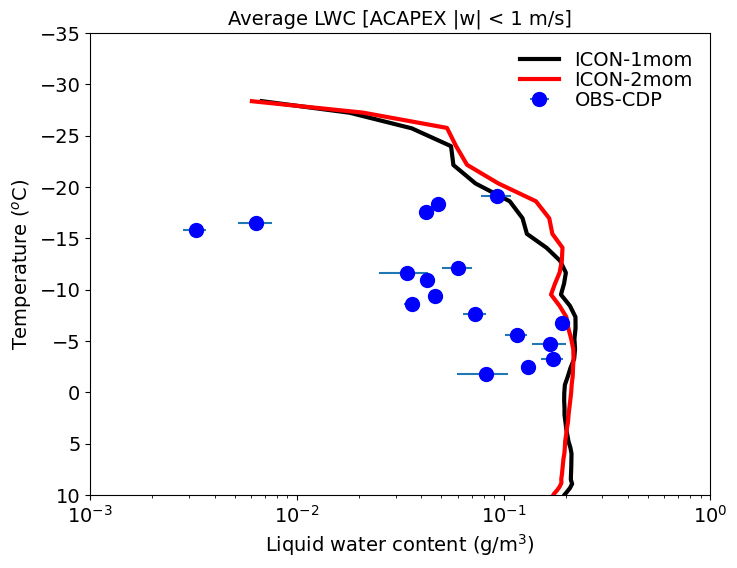

In [217]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_lwc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_lwc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.errorbar(lwc_cdp, temp_obs_lwc_cdp, xerr=std_err_lwc_cdp, fmt='o' , label='OBS-CDP', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e0)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e0], fontsize=fontsize)
plt.ylim(10, -35)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Liquid water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average LWC [ACAPEX |w| < 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_lwc_validation_stratiform.jpg', dpi=600, bbox_inches='tight')

plt.show()

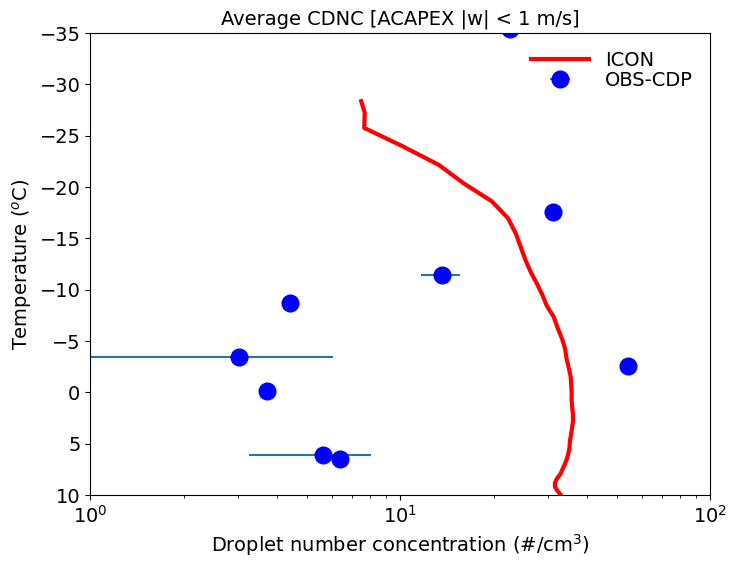

In [218]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_nc_2mom_percm3,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
plt.errorbar(num_drop_cdp, temp_obs_conc_cdp, xerr=1.e-5*std_err_num_drop_cdp, fmt='o' , label='OBS-CDP', markersize=12,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e0, 1.e2)
plt.xticks([1.e0,1.e1,1.e2], fontsize=fontsize)
plt.ylim(10, -35)
plt.yticks([10, 5, 0, -5, -10, -15, -20, -25, -30, -35], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Droplet number concentration (#/cm$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average CDNC [ACAPEX |w| < 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_cdnc_validation_stratiform.jpg', dpi=600, bbox_inches='tight')

plt.show()

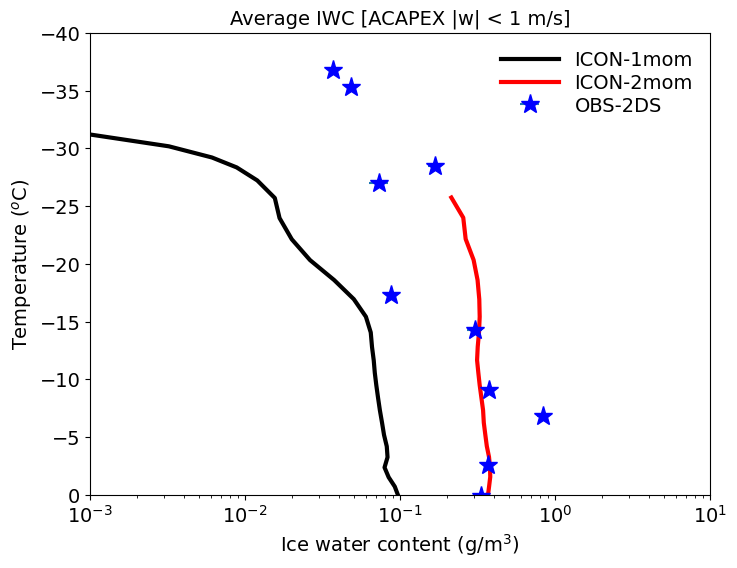

In [219]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_iwc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_iwc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.errorbar(iwc_2ds, temp_obs_iwc_2ds, xerr=std_err_iwc_2ds, fmt='*' , label='OBS-2DS', markersize=14,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average IWC [ACAPEX |w| < 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_iwc_validation_stratiform.jpg', dpi=600, bbox_inches='tight')

plt.show()

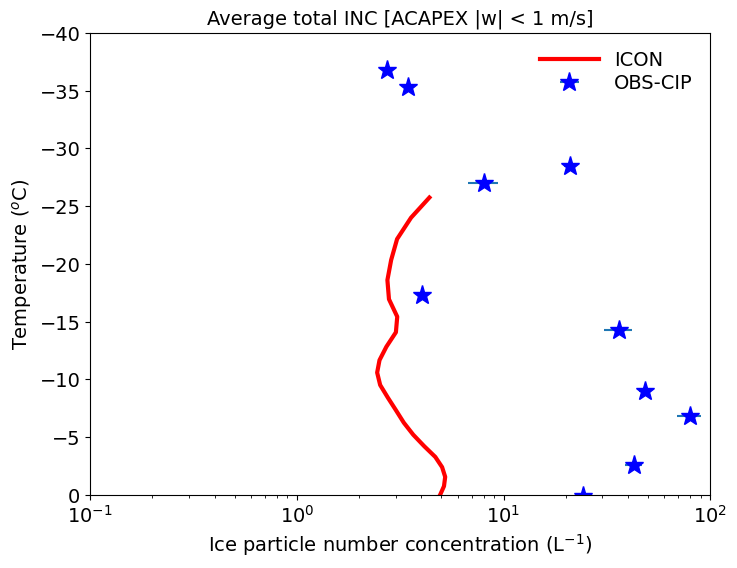

In [224]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_totice_2mom_perl,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
plt.errorbar(num_ice_2ds, temp_ni_obs, xerr=std_err_num_ice_2ds, fmt='*' , label='OBS-CIP', markersize=14,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-1, 1.e2)
plt.xticks([1.e-1,1.e0,1.e1,1.e2], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice particle number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average total INC [ACAPEX |w| < 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/acapex/marine_ccn/plots/acapex_icnc_validation_stratiform.jpg', dpi=600, bbox_inches='tight')

plt.show()

In [164]:
#==============================================================================================#
#================================= Precipitation validation ===================================#
#==============================================================================================#

In [294]:
import numpy as np
from netCDF4 import Dataset

##====================== Rainfall observation
ds_11may_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")


ds_11may_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")

grid_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain4_DOM04.nc")

data_mc3e_1mom = xr.concat([ds_11may_1mom, ds_12may_1mom], dim="time")
data_mc3e_2mom = xr.concat([ds_11may_2mom, ds_12may_2mom], dim="time")





In [295]:
print(data_mc3e_1mom.tot_prec)

<xarray.DataArray 'tot_prec' (time: 37, ncells: 141784)>
dask.array<concatenate, shape=(37, 141784), dtype=float32, chunksize=(1, 141784), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-05-11T12:00:00 ... 2011-05-12T06:00:00
    clon     (ncells) float32 -1.684 -1.684 -1.684 ... -1.671 -1.671 -1.671
    clat     (ncells) float32 0.558 0.5582 0.5583 ... 0.6084 0.6083 0.6083
Dimensions without coordinates: ncells
Attributes:
    standard_name:                tot_prec
    long_name:                    total precip
    units:                        kg m-2
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1


In [296]:
clon_deg = np.degrees(grid_mc3e.clon)
clat_deg = np.degrees(grid_mc3e.clat)

print(clon_deg.min().values); 
print(clon_deg.max().values)
print(clat_deg.min().values); 
print(clat_deg.max().values)

-100.03562402798536
-93.96330271276062
31.965389663179398
38.035332298302436


In [297]:
okla_x, okla_y = np.array([-96.5, 34.5])
#print(okla_x), print(okla_y)
dx_deg = 3.0; dy_deg = 3.0
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg


print(left_bound)
print(right_bound)
print(top_bound)
print(bottom_bound)

-99.5
-93.5
37.5
31.5


In [298]:
window_cell = (
    (grid_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)


# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_mc3e.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_mc3e.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

window_vertex_indices :: [    1     3     7 ... 71436 71437 71438]
window_edge_indices :: [     0      1      2 ... 213219 213220 213221]


In [299]:
selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

In [300]:
def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

In [301]:
new_grid_mc3e = reindex_grid(grid_mc3e, selected_indices, vars_to_renumber)



In [302]:
mask=np.isin(data_mc3e_1mom['ncells'], selected_indices.cell)


In [303]:


start_time = '2011-05-11T12:00:00.000000000'
end_time = '2011-05-12T06:00:00.000000000'

ds_mc3e_1mom_new = data_mc3e_1mom.sel(ncells=mask, time=slice(start_time, end_time))
ds_mc3e_2mom_new = data_mc3e_2mom.sel(ncells=mask, time=slice(start_time, end_time))



In [304]:
time_new_1mom = ds_mc3e_1mom_new['time'];
time_new_2mom = ds_mc3e_2mom_new['time'];

tot_prec_1mom = ds_mc3e_1mom_new['tot_prec'];
tot_prec_2mom = ds_mc3e_2mom_new['tot_prec'];

avg_precip_1mom = tot_prec_1mom.mean("ncells")
avg_precip_2mom = tot_prec_2mom.mean("ncells") 

print(time_new_1mom.shape)
print(avg_precip_1mom.shape)

(37,)
(37,)


In [305]:
data_sgp_obs = xr.open_dataset('/work/bb1163/b382718/output/mc3e/observations/precipitation/sgp180varanaiopsndg150kmv3C1.c1.20110422.000000.cdf')

time_obs = data_sgp_obs["time"];
precip_obs = data_sgp_obs["prec_srf"];

start_time = '2011-05-11T12:00:00.000000000'
end_time = '2011-05-12T06:00:00.000000000'

data_sgp_subset = data_sgp_obs.sel(time=slice(start_time, end_time))

print(data_sgp_subset.time.values)
print(data_sgp_subset.prec_srf.values)

precip_obs_acc = data_sgp_subset["prec_srf"].cumsum(dim="time")

print(precip_obs_acc.values)



['2011-05-11T12:00:00.000000000' '2011-05-11T15:00:00.000000000'
 '2011-05-11T18:00:00.000000000' '2011-05-11T21:00:00.000000000'
 '2011-05-12T00:00:00.000000000' '2011-05-12T03:00:00.000000000'
 '2011-05-12T06:00:00.000000000']
[0.         0.478592   2.40034    4.255      0.00562945 0.
 0.        ]
[0.        0.478592  2.878932  7.133932  7.1395617 7.1395617 7.1395617]


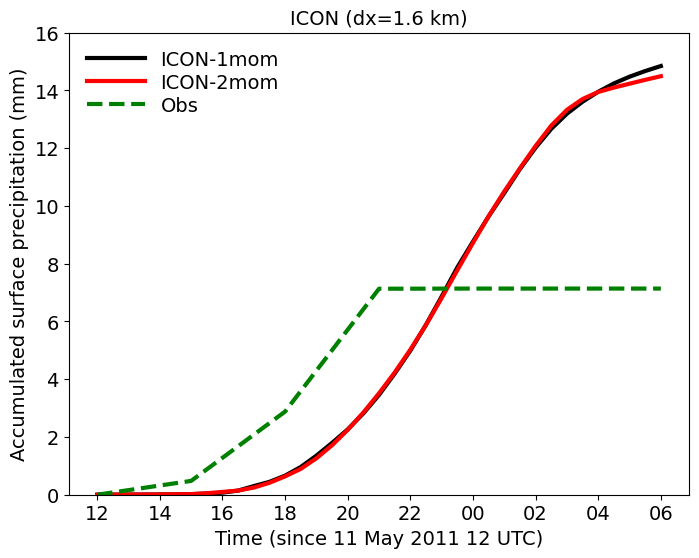

In [309]:
plt.figure(figsize=(8, 6))
#plt.subplot(1,2,1)
plt.plot(time_new_1mom, avg_precip_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(time_new_2mom, avg_precip_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.plot(data_sgp_subset.time, precip_obs_acc, 'g--', label='Obs', linewidth = lnwdth)
plt.xlabel('Time (since 11 May 2011 12 UTC)', fontsize=14)
plt.ylabel('Accumulated surface precipitation (mm)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 16])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16], fontsize=14)
#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (dx=1.6 km)', fontsize=14)
plt.legend()
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_precip_validation_resol_1600m.jpg', dpi=600, bbox_inches='tight')

plt.show()


In [276]:
import numpy as np
from netCDF4 import Dataset

##====================== Rainfall observation
ds_11may_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM03_20110511T*Z.nc")
ds_12may_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM03_20110512T*Z.nc")


ds_11may_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM03_20110511T*Z.nc")
ds_12may_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM03_20110512T*Z.nc")

grid_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain3_DOM03.nc")

data_mc3e_1mom = xr.concat([ds_11may_1mom, ds_12may_1mom], dim="time")
data_mc3e_2mom = xr.concat([ds_11may_2mom, ds_12may_2mom], dim="time")





In [277]:
clon_deg = np.degrees(grid_mc3e.clon)
clat_deg = np.degrees(grid_mc3e.clat)

print(clon_deg.min().values); 
print(clon_deg.max().values)
print(clat_deg.min().values); 
print(clat_deg.max().values)

-102.071362912353
-91.92725520988402
29.9312056399507
40.06979547931381


In [280]:
okla_x, okla_y = np.array([-97, 35.5])
#print(okla_x), print(okla_y)
dx_deg = 4.5; dy_deg = 4.5
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg


print(left_bound)
print(right_bound)
print(top_bound)
print(bottom_bound)

-101.5
-92.5
40.0
31.0


In [281]:
window_cell = (
    (grid_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)


# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_mc3e.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_mc3e.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

window_vertex_indices :: [   38    61    70 ... 49807 49808 49811]
window_edge_indices :: [   155    629    849 ... 148508 148509 148522]


In [282]:
selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

In [283]:
def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

In [284]:
new_grid_mc3e = reindex_grid(grid_mc3e, selected_indices, vars_to_renumber)



In [285]:
mask=np.isin(data_mc3e_1mom['ncells'], selected_indices.cell)


In [290]:


start_time = '2011-05-11T12:00:00.000000000'
end_time = '2011-05-12T06:00:00.000000000'

ds_mc3e_1mom_new = data_mc3e_1mom.sel(ncells=mask, time=slice(start_time, end_time))
ds_mc3e_2mom_new = data_mc3e_2mom.sel(ncells=mask, time=slice(start_time, end_time))



In [291]:
time_new_1mom = ds_mc3e_1mom_new['time'];
time_new_2mom = ds_mc3e_2mom_new['time'];

tot_prec_1mom = ds_mc3e_1mom_new['tot_prec'];
tot_prec_2mom = ds_mc3e_2mom_new['tot_prec'];

avg_precip_1mom = tot_prec_1mom.mean("ncells")
avg_precip_2mom = tot_prec_2mom.mean("ncells") 

print(time_new_1mom.shape)
print(avg_precip_1mom.shape)

(37,)
(37,)


In [292]:
data_sgp_obs = xr.open_dataset('/work/bb1163/b382718/output/mc3e/observations/precipitation/sgp180varanaiopsndg150kmv3C1.c1.20110422.000000.cdf')

time_obs = data_sgp_obs["time"];
precip_obs = data_sgp_obs["prec_srf"];

start_time = '2011-05-11T12:00:00.000000000'
end_time = '2011-05-12T06:00:00.000000000'

data_sgp_subset = data_sgp_obs.sel(time=slice(start_time, end_time))

print(data_sgp_subset.time.values)
print(data_sgp_subset.prec_srf.values)

precip_obs_acc = data_sgp_subset["prec_srf"].cumsum(dim="time")

print(precip_obs_acc.values)



['2011-05-11T12:00:00.000000000' '2011-05-11T15:00:00.000000000'
 '2011-05-11T18:00:00.000000000' '2011-05-11T21:00:00.000000000'
 '2011-05-12T00:00:00.000000000' '2011-05-12T03:00:00.000000000'
 '2011-05-12T06:00:00.000000000']
[0.         0.478592   2.40034    4.255      0.00562945 0.
 0.        ]
[0.        0.478592  2.878932  7.133932  7.1395617 7.1395617 7.1395617]


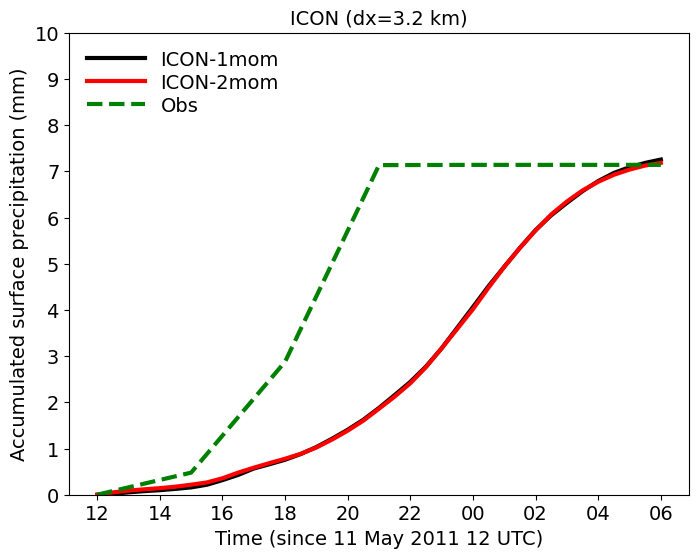

In [293]:
plt.figure(figsize=(8, 6))
#plt.subplot(1,2,1)
plt.plot(time_new_1mom, avg_precip_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(time_new_2mom, avg_precip_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)
plt.plot(data_sgp_subset.time, precip_obs_acc, 'g--', label='Obs', linewidth = lnwdth)
plt.xlabel('Time (since 11 May 2011 12 UTC)', fontsize=14)
plt.ylabel('Accumulated surface precipitation (mm)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 10])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=14)
#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (dx=3.2 km)', fontsize=14)
plt.legend()
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_precip_validation_resol_3200m.jpg', dpi=600, bbox_inches='tight')

plt.show()


In [310]:
#=============================================================================#
#===================== vertical profiles =====================================#
#=============================================================================#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import pandas as pd
import glob
import math
import subprocess
from matplotlib import colormaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [86]:


##====================== Rainfall observation
ds_11may_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")


ds_11may_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")

grid_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain4_DOM04.nc")

data_mc3e_1mom = xr.concat([ds_11may_1mom, ds_12may_1mom], dim="time")
data_mc3e_2mom = xr.concat([ds_11may_2mom, ds_12may_2mom], dim="time")



In [87]:

time_1mom = data_mc3e_1mom['time'];
qv_1mom = data_mc3e_1mom['qv'];
qc_1mom = data_mc3e_1mom['qc'];
qi_1mom = data_mc3e_1mom['qi'];
qs_1mom = data_mc3e_1mom['qs'];
qr_1mom = data_mc3e_1mom['qr'];
prec_1mom = data_mc3e_1mom['tot_prec'];
temp_1mom = data_mc3e_1mom['temp'];
dbz_1mom = data_mc3e_1mom['dbz'];
ht_1mom = data_mc3e_1mom['z_mc'];
rho_1mom = data_mc3e_1mom['rho'];
pres_1mom = data_mc3e_1mom['pres'];
omega_1mom = data_mc3e_1mom['omega'];
vert_vel_1mom = -1.*omega_1mom/(9.8*rho_1mom);

# 2 moment
time_2mom = data_mc3e_2mom['time'];
qv_2mom = data_mc3e_2mom['qv'];
qc_2mom = data_mc3e_2mom['qc'];
qi_2mom = data_mc3e_2mom['qi'];
qs_2mom = data_mc3e_2mom['qs'];
qg_2mom = data_mc3e_2mom['qg'];
qh_2mom = data_mc3e_2mom['qh'];
qr_2mom = data_mc3e_2mom['qr'];

nc_2mom = data_mc3e_2mom['qnc'];
ni_2mom = data_mc3e_2mom['qni'];
ns_2mom = data_mc3e_2mom['qns'];
ng_2mom = data_mc3e_2mom['qng'];
nh_2mom = data_mc3e_2mom['qnh'];
nr_2mom = data_mc3e_2mom['qnr'];

prec_2mom = data_mc3e_2mom['tot_prec'];
temp_2mom = data_mc3e_2mom['temp'];
dbz_2mom = data_mc3e_2mom['dbz'];
ht_2mom = data_mc3e_2mom['z_mc'];
rho_2mom = data_mc3e_2mom['rho'];
pres_2mom = data_mc3e_2mom['pres'];
omega_2mom = data_mc3e_2mom['omega'];
vert_vel_2mom = -1.*omega_2mom/(9.8*rho_2mom);



In [88]:
thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 1.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_1mom = xr.where((qv_1mom > thres_q), qv_1mom, np.nan)
filt_qc_1mom = xr.where((qc_1mom > thres_q) & (vert_vel_1mom > thres_w), qc_1mom, np.nan)
filt_qi_1mom = xr.where((qi_1mom > thres_q) & (vert_vel_1mom > thres_w), qi_1mom, np.nan)
filt_qs_1mom = xr.where((qs_1mom > thres_q) & (vert_vel_1mom > thres_w), qs_1mom, np.nan)
filt_qr_1mom = xr.where((qr_1mom > thres_q) & (vert_vel_1mom > thres_w), qr_1mom, np.nan)
filt_dbz_1mom = xr.where((dbz_1mom > -10.), dbz_1mom, np.nan)

avg_qv_1mom = filt_qv_1mom.mean(dim=('time','ncells'))
avg_qc_1mom = filt_qc_1mom.mean(dim=('time','ncells'))
avg_qi_1mom = filt_qi_1mom.mean(dim=('time','ncells'))
avg_qs_1mom = filt_qs_1mom.mean(dim=('time','ncells'))
avg_qr_1mom = filt_qr_1mom.mean(dim=('time','ncells'))

avg_dbz_1mom = filt_dbz_1mom.mean(dim=('time','ncells'))
avg_temp_1mom = temp_1mom.mean(dim=('time','ncells'))
avg_ht_1mom = ht_1mom.mean(dim=('time','ncells'))
avg_pres_1mom = pres_1mom.mean(dim=('time','ncells'))

lwc_1mom = filt_qc_1mom*rho_1mom*1.e3 # kgperm3 to gperm3
iwc_1mom = (filt_qi_1mom+filt_qs_1mom)*rho_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_1mom = lwc_1mom.mean(dim=('time','ncells'))
avg_iwc_1mom = iwc_1mom.mean(dim=('time','ncells'))
avg_tempc_1mom = avg_temp_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_2mom = xr.where((qv_2mom > thres_q), qv_2mom, np.nan)
filt_qc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom > thres_w), qc_2mom, np.nan)
filt_qi_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom > thres_w), qi_2mom, np.nan)
filt_qs_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom > thres_w), qs_2mom, np.nan)
filt_qg_2mom = xr.where((qg_2mom > thres_q) & (vert_vel_2mom > thres_w), qg_2mom, np.nan)
filt_qh_2mom = xr.where((qh_2mom > thres_q) & (vert_vel_2mom > thres_w), qh_2mom, np.nan)
filt_qr_2mom = xr.where((qr_2mom > thres_q) & (vert_vel_2mom > thres_w), qr_2mom, np.nan)
filt_dbz_2mom = xr.where((dbz_2mom > -10.), dbz_2mom, np.nan)

avg_qv_2mom = filt_qv_2mom.mean(dim=('time','ncells'))
avg_qc_2mom = filt_qc_2mom.mean(dim=('time','ncells'))
avg_qi_2mom = filt_qi_2mom.mean(dim=('time','ncells'))
avg_qs_2mom = filt_qs_2mom.mean(dim=('time','ncells'))
avg_qr_2mom = filt_qr_2mom.mean(dim=('time','ncells'))

avg_dbz_2mom = filt_dbz_2mom.mean(dim=('time','ncells'))
avg_temp_2mom = temp_2mom.mean(dim=('time','ncells'))
avg_ht_2mom = ht_2mom.mean(dim=('time','ncells'))
avg_pres_2mom = pres_2mom.mean(dim=('time','ncells'))

lwc_2mom = filt_qc_2mom*rho_2mom*1.e3 # kgperm3 to gperm3
iwc_2mom = (filt_qi_2mom+filt_qs_2mom+filt_qg_2mom+filt_qh_2mom)*rho_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_2mom = lwc_2mom.mean(dim=('time','ncells'))
avg_iwc_2mom = iwc_2mom.mean(dim=('time','ncells'))
avg_tempc_2mom = avg_temp_2mom-273.16; 


filt_nc_2mom = xr.where((qc_2mom > thres_q) & (vert_vel_2mom > thres_w), nc_2mom, np.nan) 

filt_ni_2mom = xr.where((qi_2mom > thres_q) & (vert_vel_2mom > thres_w), ni_2mom, np.nan) 
filt_ns_2mom = xr.where((qs_2mom > thres_q) & (vert_vel_2mom > thres_w), ns_2mom, np.nan) 
filt_ng_2mom = xr.where((qg_2mom > thres_q) & (vert_vel_2mom > thres_w), ng_2mom, np.nan)
filt_nh_2mom = xr.where((qh_2mom > thres_q) & (vert_vel_2mom > thres_w), nh_2mom, np.nan)

#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



nc_2mom_percm3 = filt_nc_2mom*rho_2mom/1.e6;
ni_2mom_percm3 = filt_ni_2mom*rho_2mom/1.e6;
ns_2mom_percm3 = filt_ns_2mom*rho_2mom/1.e6;
ng_2mom_percm3 = filt_ng_2mom*rho_2mom/1.e6;
nh_2mom_percm3 = filt_nh_2mom*rho_2mom/1.e6;

nc_2mom_perl = nc_2mom_percm3*1.e3;
ni_2mom_perl = ni_2mom_percm3*1.e3;
ns_2mom_perl = ns_2mom_percm3*1.e3;
ng_2mom_perl = ng_2mom_percm3*1.e3;
nh_2mom_perl = nh_2mom_percm3*1.e3;

avg_nc_2mom_percm3 = nc_2mom_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_percm3 = ni_2mom_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_percm3 = ns_2mom_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_percm3 = ng_2mom_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_percm3 = nh_2mom_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_perl = nc_2mom_perl.mean(dim=('time','ncells'))
avg_ni_2mom_perl = ni_2mom_perl.mean(dim=('time','ncells'))
avg_ns_2mom_perl = ns_2mom_perl.mean(dim=('time','ncells'))
avg_ng_2mom_perl = ng_2mom_perl.mean(dim=('time','ncells'))
avg_nh_2mom_perl = nh_2mom_perl.mean(dim=('time','ncells'))

avg_totice_2mom_perl = avg_ni_2mom_perl+avg_ns_2mom_perl+avg_ng_2mom_perl+avg_nh_2mom_perl


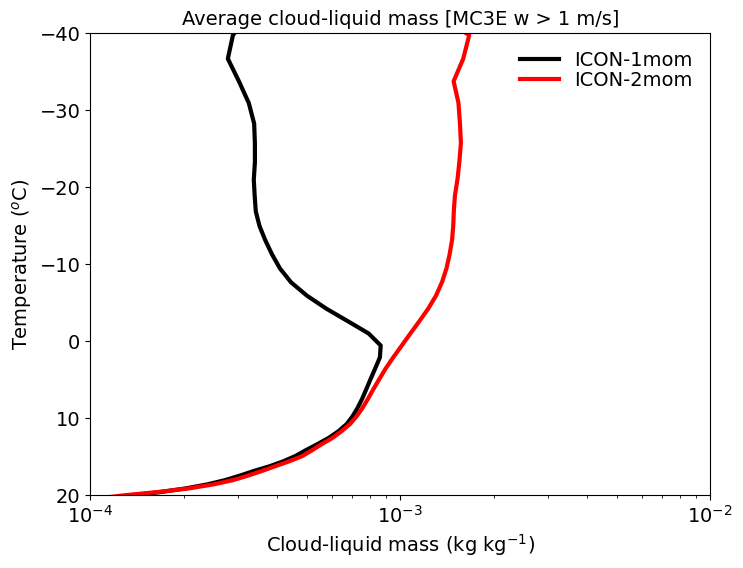

In [10]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_qc_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_qc_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)

# Setting plot limits and labels
plt.xlim(1.e-4, 1.e-2)
plt.xticks([1.e-4,1.e-3,1.e-2], fontsize=fontsize)
plt.ylim(20, -40)
plt.yticks([20,10,0,-10,-20,-30,-40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Cloud-liquid mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average cloud-liquid mass [MC3E w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_cld_liq_mass_updraft_1_2mom.jpg', dpi=400, bbox_inches='tight')

plt.show()

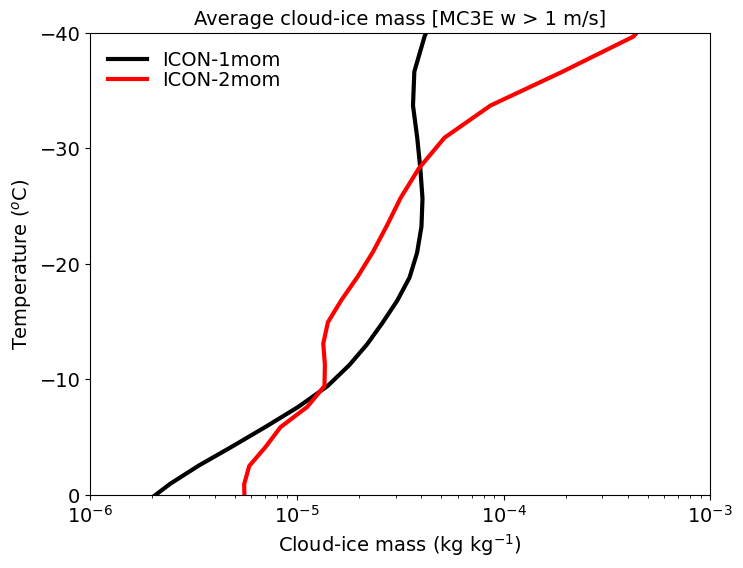

In [12]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_qi_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_qi_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)

# Setting plot limits and labels
plt.xlim(1.e-6, 1.e-3)
plt.xticks([1.e-6,1.e-5,1.e-4,1.e-3], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0,-10,-20,-30,-40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Cloud-ice mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average cloud-ice mass [MC3E w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_cld_ice_mass_updraft_1_2mom.jpg', dpi=400, bbox_inches='tight')

plt.show()

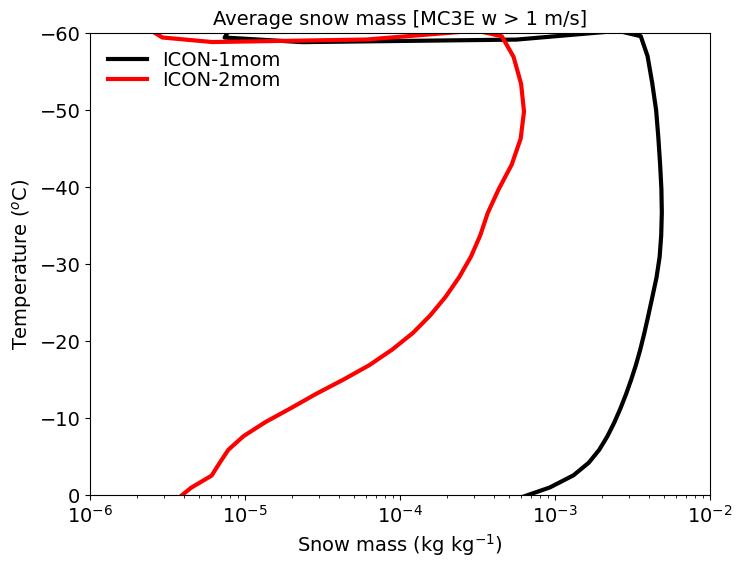

In [89]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_qs_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_qs_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)

# Setting plot limits and labels
plt.xlim(1.e-6, 1.e-2)
plt.xticks([1.e-6,1.e-5,1.e-4,1.e-3,1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0,-10,-20,-30,-40,-50,-60], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Snow mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average snow mass [MC3E w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_snow_mass_updraft_1_2mom.jpg', dpi=400, bbox_inches='tight')

plt.show()

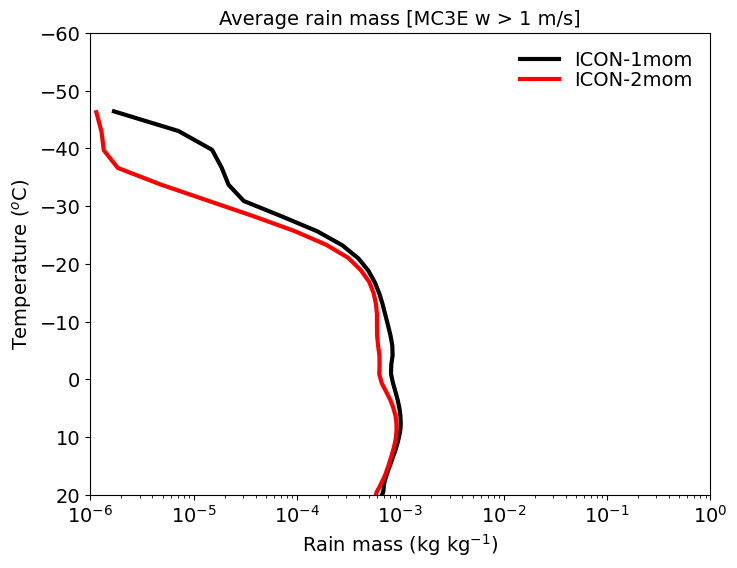

In [90]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_qr_1mom,avg_tempc_1mom, 'k-', label='ICON-1mom', linewidth = lnwdth)
plt.plot(avg_qr_2mom,avg_tempc_2mom, 'r-', label='ICON-2mom', linewidth = lnwdth)

# Setting plot limits and labels
plt.xlim(1.e-6, 1.e0)
plt.xticks([1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1,1.e0], fontsize=fontsize)
plt.ylim(20, -60)
plt.yticks([20, 10, 0,-10,-20,-30,-40,-50,-60], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Rain mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average rain mass [MC3E w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_rain_mass_updraft_1_2mom.jpg', dpi=400, bbox_inches='tight')

plt.show()

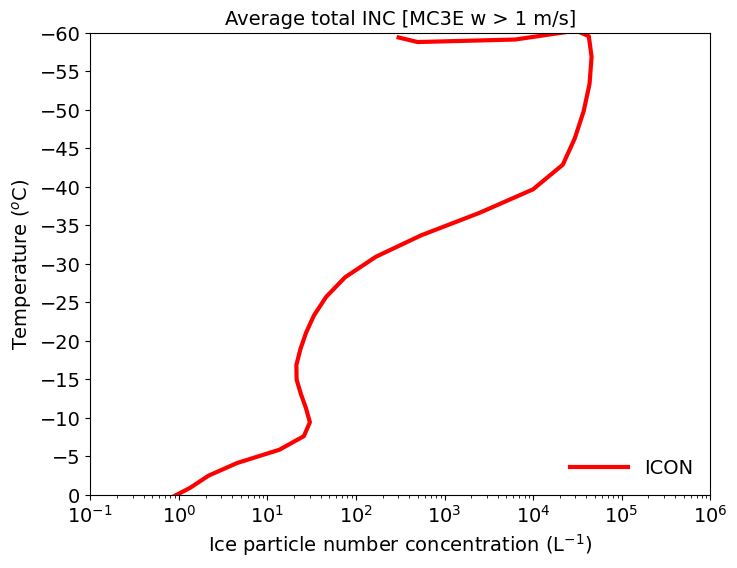

In [91]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
#plt.plot(avg_totice_2mom_perl,avg_tempc_2mom, 'k-', label='ICON', linewidth = lnwdth)
plt.plot(avg_totice_2mom_perl,avg_tempc_2mom, 'r-', label='ICON', linewidth = lnwdth)
# Setting plot limits and labels
plt.xlim(1.e-1, 1.e6)
plt.xticks([1.e-1,1.e0,1.e1,1.e2,1.e3,1.e4,1.e5,1.e6], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice particle number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average total INC [MC3E w > 1 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='lower right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/mc3e_icnc_updraft_2mom.jpg', dpi=600, bbox_inches='tight')

plt.show()

In [96]:
w_bin = [-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20];
temp_bin = [-20., -16., -12., -8., -4., 0., 4., 8., 12., 16., 20., 24., 28., 32., 36., 40., 44., 48., 52., 56., 60.]
print(w_bin)
print(temp_bin)

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
[-20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0, 56.0, 60.0]


In [97]:

w_bin = [float(i) for i in range(-20, 21, 2)]
temp_bin = [float(i) for i in range(-20, 61, 4)]


In [102]:
avg_qi_1mom = np.zeros((len(w_bin)-1,len(temp_bin)-1))
count_qi_1mom = np.zeros_like(avg_qi_1mom)

In [113]:
tempc_1mom = temp_1mom.values-273.16
vel_1mom = vert_vel_1mom.values
cldice_mass_1mom = qi_1mom.values

In [ ]:
#==============================================================================================#
#============================ 1.6 km & 3.2 km comparison ======================================#
#==============================================================================================#

In [133]:
##====================== resolution 1600m
ds_11may_1600m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_1600m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")


ds_11may_1600m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_1600m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")

grid_1600m_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain4_DOM04.nc")

data_mc3e_1600m_1mom = xr.concat([ds_11may_1600m_1mom, ds_12may_1600m_1mom], dim="time")
data_mc3e_1600m_2mom = xr.concat([ds_11may_1600m_2mom, ds_12may_1600m_2mom], dim="time")

In [150]:
##====================== resolution 3200m 
ds_11may_3200m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM03_20110511T*Z.nc")
ds_12may_3200m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM03_20110512T*Z.nc")


ds_11may_3200m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM03_20110511T*Z.nc")
ds_12may_3200m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM03_20110512T*Z.nc")

grid_3200m_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain3_DOM03.nc")

data_mc3e_3200m_1mom = xr.concat([ds_11may_3200m_1mom, ds_12may_3200m_1mom], dim="time")
data_mc3e_3200m_2mom = xr.concat([ds_11may_3200m_2mom, ds_12may_3200m_2mom], dim="time")

In [181]:
##====================== resolution 6500m 
ds_11may_6500m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM02_20110511T*Z.nc")
ds_12may_6500m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM02_20110512T*Z.nc")


ds_11may_6500m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM02_20110511T*Z.nc")
ds_12may_6500m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM02_20110512T*Z.nc")

grid_6500m_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain2_DOM02.nc")

data_mc3e_6500m_1mom = xr.concat([ds_11may_6500m_1mom, ds_12may_6500m_1mom], dim="time")
data_mc3e_6500m_2mom = xr.concat([ds_11may_6500m_2mom, ds_12may_6500m_2mom], dim="time")

In [182]:
##====================== resolution 13000m 
ds_11may_13000m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM01_20110511T*Z.nc")
ds_12may_13000m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM01_20110512T*Z.nc")


ds_11may_13000m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM01_20110511T*Z.nc")
ds_12may_13000m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM01_20110512T*Z.nc")

grid_13000m_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain1_DOM01.nc")

data_mc3e_13000m_1mom = xr.concat([ds_11may_13000m_1mom, ds_12may_13000m_1mom], dim="time")
data_mc3e_13000m_2mom = xr.concat([ds_11may_13000m_2mom, ds_12may_13000m_2mom], dim="time")

In [135]:
clon_deg = np.degrees(grid_mc3e.clon)
clat_deg = np.degrees(grid_mc3e.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

-100.03562402798536
-93.96330271276062
31.965389663179398
38.035332298302436


In [136]:
okla_x, okla_y = np.array([-98., 37.])
okla_x, okla_y = np.array([-98., 37.])
#print(okla_x), print(okla_y)
dx_deg = 1.; dy_deg = 1.0
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)

-99.0
-97.0
38.0
36.0


(None, None)

In [183]:
print('##======================= for 1600 m resolution =======================##')

window_cell_1600m = (
    (grid_1600m_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_1600m_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_1600m_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_1600m_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices_1600m,) = np.where(window_cell_1600m)

print('##======================= for 3200 m resolution =======================##')

window_cell_3200m = (
    (grid_3200m_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_3200m_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_3200m_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_3200m_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices_3200m,) = np.where(window_cell_3200m)

print('##======================= for 6500 m resolution =======================##')

window_cell_6500m = (
    (grid_6500m_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_6500m_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_6500m_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_6500m_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices_6500m,) = np.where(window_cell_6500m)

print('##======================= for 13000 m resolution =======================##')

window_cell_13000m = (
    (grid_13000m_mc3e.clat >= np.deg2rad(bottom_bound))
    & (grid_13000m_mc3e.clat <= np.deg2rad(top_bound))
    & (grid_13000m_mc3e.clon >= np.deg2rad(left_bound))
    & (grid_13000m_mc3e.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices_13000m,) = np.where(window_cell_13000m)

##======================= for 1600 m resolution =======================##
##======================= for 3200 m resolution =======================##
##======================= for 6500 m resolution =======================##
##======================= for 13000 m resolution =======================##


In [184]:
print('##======================= for 1600 m resolution =======================##')

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices_1600m = (np.unique(grid_1600m_mc3e.vertex_of_cell.isel(cell=window_cell_indices_1600m).values) - 1)
print('window_vertex_indices ::',window_vertex_indices_1600m)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices_1600m = (np.unique(grid_1600m_mc3e.edge_of_cell.isel(cell=window_cell_indices_1600m).values) - 1)
print('window_edge_indices ::',window_edge_indices_1600m)


print('##======================= for 3200 m resolution =======================##')
# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices_3200m = (np.unique(grid_3200m_mc3e.vertex_of_cell.isel(cell=window_cell_indices_3200m).values) - 1)
print('window_vertex_indices ::',window_vertex_indices_3200m)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices_3200m = (np.unique(grid_3200m_mc3e.edge_of_cell.isel(cell=window_cell_indices_3200m).values) - 1)
print('window_edge_indices ::',window_edge_indices_3200m)


print('##======================= for 6500 m resolution =======================##')
# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices_6500m = (np.unique(grid_6500m_mc3e.vertex_of_cell.isel(cell=window_cell_indices_6500m).values) - 1)
print('window_vertex_indices ::',window_vertex_indices_6500m)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices_6500m = (np.unique(grid_6500m_mc3e.edge_of_cell.isel(cell=window_cell_indices_6500m).values) - 1)
print('window_edge_indices ::',window_edge_indices_6500m)


print('##======================= for 13000 m resolution =======================##')
# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices_13000m = (np.unique(grid_13000m_mc3e.vertex_of_cell.isel(cell=window_cell_indices_13000m).values) - 1)
print('window_vertex_indices ::',window_vertex_indices_13000m)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices_13000m = (np.unique(grid_13000m_mc3e.edge_of_cell.isel(cell=window_cell_indices_13000m).values) - 1)
print('window_edge_indices ::',window_edge_indices_13000m)


##======================= for 1600 m resolution =======================##
window_vertex_indices :: [   23    67   148 ... 62065 62069 62074]
window_edge_indices :: [   699   1112   1135 ... 175964 175965 175966]
##======================= for 3200 m resolution =======================##
window_vertex_indices :: [ 4490  4543  4569 ... 42863 42864 42868]
window_edge_indices :: [ 13937  13938  13939 ... 120948 120949 120958]
##======================= for 6500 m resolution =======================##
window_vertex_indices :: [ 3133  3247  3289  3291  3294  3367  3372  3538  3539  3540  3627  3628
  3631  3632  3637  3641  3786  3795  3796  4129  4130  4131  4147  4148
  4149  4152  4156  4158  4195  4197  4204  4205  4206  4623  4624  4625
  4626  4627  4628  4798  4799  4800  4805  4806  4807  4808  4817  4818
  4819  4825  5116  5117  5135  5136  5137  5798  5799  5800  5801  5802
  5803  5834  5835  5836  5837  5838  5839  5843  5845  5852  5853  5856
  5857  5931  5934  5948  5950  5952  5

In [187]:

print('##======================= for 1600 m resolution =======================##')
selected_indices_1600m = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices_1600m),
        "vertex": ("vertex", window_vertex_indices_1600m),
        "edge": ("edge", window_edge_indices_1600m),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

mask_1600m=np.isin(data_mc3e_1600m_1mom['ncells'], selected_indices_1600m.cell)

print('##======================= for 3200 m resolution =======================##')
selected_indices_3200m = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices_3200m),
        "vertex": ("vertex", window_vertex_indices_3200m),
        "edge": ("edge", window_edge_indices_3200m),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

mask_3200m=np.isin(data_mc3e_3200m_1mom['ncells'], selected_indices_3200m.cell)


print('##======================= for 6500 m resolution =======================##')
selected_indices_6500m = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices_6500m),
        "vertex": ("vertex", window_vertex_indices_6500m),
        "edge": ("edge", window_edge_indices_6500m),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

mask_6500m=np.isin(data_mc3e_6500m_1mom['ncells'], selected_indices_6500m.cell)


print('##======================= for 13000 m resolution =======================##')
selected_indices_13000m = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices_13000m),
        "vertex": ("vertex", window_vertex_indices_13000m),
        "edge": ("edge", window_edge_indices_13000m),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

mask_13000m=np.isin(data_mc3e_13000m_1mom['ncells'], selected_indices_13000m.cell)

##======================= for 1600 m resolution =======================##
##======================= for 3200 m resolution =======================##
##======================= for 6500 m resolution =======================##
##======================= for 13000 m resolution =======================##


In [166]:
print(mask_1600m.shape)
print(mask_3200m.shape)
print(data_mc3e_3200m_1mom.dims)

(141784,)
(98744,)
Frozen({'time': 37, 'ncells': 98744, 'vertices': 3, 'height': 65, 'bnds': 2, 'height_2': 66, 'plev': 1, 'plev_2': 1, 'plev_3': 1})


In [188]:
aircraft_starttime='2011-05-11T16:30:00.000000000'
aircraft_endtime='2011-05-11T21:00:00.000000000'

ds_mc3e_1600m_1mom = data_mc3e_1600m_1mom.sel(ncells=mask_1600m,time=slice(aircraft_starttime, aircraft_endtime))
ds_mc3e_1600m_2mom = data_mc3e_1600m_2mom.sel(ncells=mask_1600m,time=slice(aircraft_starttime, aircraft_endtime))


ds_mc3e_3200m_1mom = data_mc3e_3200m_1mom.sel(ncells=mask_3200m,time=slice(aircraft_starttime, aircraft_endtime))
ds_mc3e_3200m_2mom = data_mc3e_3200m_2mom.sel(ncells=mask_3200m,time=slice(aircraft_starttime, aircraft_endtime))


ds_mc3e_6500m_1mom = data_mc3e_6500m_1mom.sel(ncells=mask_6500m,time=slice(aircraft_starttime, aircraft_endtime))
ds_mc3e_6500m_2mom = data_mc3e_6500m_2mom.sel(ncells=mask_6500m,time=slice(aircraft_starttime, aircraft_endtime))


ds_mc3e_13000m_1mom = data_mc3e_13000m_1mom.sel(ncells=mask_13000m,time=slice(aircraft_starttime, aircraft_endtime))
ds_mc3e_13000m_2mom = data_mc3e_13000m_2mom.sel(ncells=mask_13000m,time=slice(aircraft_starttime, aircraft_endtime))

In [174]:

time_1600m_1mom = ds_mc3e_1600m_1mom['time'];
qv_1600m_1mom = ds_mc3e_1600m_1mom['qv'];
qc_1600m_1mom = ds_mc3e_1600m_1mom['qc'];
qi_1600m_1mom = ds_mc3e_1600m_1mom['qi'];
qs_1600m_1mom = ds_mc3e_1600m_1mom['qs'];
qr_1600m_1mom = ds_mc3e_1600m_1mom['qr'];
prec_1600m_1mom = ds_mc3e_1600m_1mom['tot_prec'];
temp_1600m_1mom = ds_mc3e_1600m_1mom['temp'];
dbz_1600m_1mom = ds_mc3e_1600m_1mom['dbz'];
ht_1600m_1mom = ds_mc3e_1600m_1mom['z_mc'];
rho_1600m_1mom = ds_mc3e_1600m_1mom['rho'];
pres_1600m_1mom = ds_mc3e_1600m_1mom['pres'];
omega_1600m_1mom = ds_mc3e_1600m_1mom['omega'];
vert_vel_1600m_1mom = -1.*omega_1600m_1mom/(9.8*rho_1600m_1mom);

# 2 moment
time_1600m_2mom = ds_mc3e_1600m_2mom['time'];
qv_1600m_2mom = ds_mc3e_1600m_2mom['qv'];
qc_1600m_2mom = ds_mc3e_1600m_2mom['qc'];
qi_1600m_2mom = ds_mc3e_1600m_2mom['qi'];
qs_1600m_2mom = ds_mc3e_1600m_2mom['qs'];
qg_1600m_2mom = ds_mc3e_1600m_2mom['qg'];
qh_1600m_2mom = ds_mc3e_1600m_2mom['qh'];
qr_1600m_2mom = ds_mc3e_1600m_2mom['qr'];

nc_1600m_2mom = ds_mc3e_1600m_2mom['qnc'];
ni_1600m_2mom = ds_mc3e_1600m_2mom['qni'];
ns_1600m_2mom = ds_mc3e_1600m_2mom['qns'];
ng_1600m_2mom = ds_mc3e_1600m_2mom['qng'];
nh_1600m_2mom = ds_mc3e_1600m_2mom['qnh'];
nr_1600m_2mom = ds_mc3e_1600m_2mom['qnr'];

prec_1600m_2mom = ds_mc3e_1600m_2mom['tot_prec'];
temp_1600m_2mom = ds_mc3e_1600m_2mom['temp'];
dbz_1600m_2mom = ds_mc3e_1600m_2mom['dbz'];
ht_1600m_2mom = ds_mc3e_1600m_2mom['z_mc'];
rho_1600m_2mom = ds_mc3e_1600m_2mom['rho'];
pres_1600m_2mom = ds_mc3e_1600m_2mom['pres'];
omega_1600m_2mom = ds_mc3e_1600m_2mom['omega'];
vert_vel_1600m_2mom = -1.*omega_1600m_2mom/(9.8*rho_1600m_2mom);



In [204]:
thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_1600m_1mom = xr.where((qv_1600m_1mom > thres_q), qv_1600m_1mom, np.nan)
filt_qc_1600m_1mom = xr.where((qc_1600m_1mom > thres_q) & (vert_vel_1600m_1mom > thres_w), qc_1600m_1mom, np.nan)
filt_qi_1600m_1mom = xr.where((qi_1600m_1mom > thres_q) & (vert_vel_1600m_1mom > thres_w), qi_1600m_1mom, np.nan)
filt_qs_1600m_1mom = xr.where((qs_1600m_1mom > thres_q) & (vert_vel_1600m_1mom > thres_w), qs_1600m_1mom, np.nan)
filt_qr_1600m_1mom = xr.where((qr_1600m_1mom > thres_q) & (vert_vel_1600m_1mom > thres_w), qr_1600m_1mom, np.nan)
filt_dbz_1600m_1mom = xr.where((dbz_1600m_1mom > -10.), dbz_1600m_1mom, np.nan)

avg_qv_1600m_1mom = filt_qv_1600m_1mom.mean(dim=('time','ncells'))
avg_qc_1600m_1mom = filt_qc_1600m_1mom.mean(dim=('time','ncells'))
avg_qi_1600m_1mom = filt_qi_1600m_1mom.mean(dim=('time','ncells'))
avg_qs_1600m_1mom = filt_qs_1600m_1mom.mean(dim=('time','ncells'))
avg_qr_1600m_1mom = filt_qr_1600m_1mom.mean(dim=('time','ncells'))

avg_dbz_1600m_1mom = filt_dbz_1600m_1mom.mean(dim=('time','ncells'))
avg_temp_1600m_1mom = temp_1600m_1mom.mean(dim=('time','ncells'))
avg_ht_1600m_1mom = ht_1600m_1mom.mean(dim=('time','ncells'))
avg_pres_1600m_1mom = pres_1600m_1mom.mean(dim=('time','ncells'))

lwc_1600m_1mom = filt_qc_1600m_1mom*rho_1600m_1mom*1.e3 # kgperm3 to gperm3
iwc_1600m_1mom = (filt_qi_1600m_1mom+filt_qs_1600m_1mom)*rho_1600m_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_1600m_1mom = lwc_1600m_1mom.mean(dim=('time','ncells'))
avg_iwc_1600m_1mom = iwc_1600m_1mom.mean(dim=('time','ncells'))
avg_tempc_1600m_1mom = avg_temp_1600m_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_1600m_2mom = xr.where((qv_1600m_2mom > thres_q), qv_1600m_2mom, np.nan)
filt_qc_1600m_2mom = xr.where((qc_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), qc_1600m_2mom, np.nan)
filt_qi_1600m_2mom = xr.where((qi_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), qi_1600m_2mom, np.nan)
filt_qs_1600m_2mom = xr.where((qs_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), qs_1600m_2mom, np.nan)
filt_qg_1600m_2mom = xr.where((qg_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), qg_1600m_2mom, np.nan)
filt_qh_1600m_2mom = xr.where((qh_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), qh_1600m_2mom, np.nan)
filt_qr_1600m_2mom = xr.where((qr_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), qr_1600m_2mom, np.nan)
filt_dbz_1600m_2mom = xr.where((dbz_1600m_2mom > -10.), dbz_1600m_2mom, np.nan)

avg_qv_1600m_2mom = filt_qv_1600m_2mom.mean(dim=('time','ncells'))
avg_qc_1600m_2mom = filt_qc_1600m_2mom.mean(dim=('time','ncells'))
avg_qi_1600m_2mom = filt_qi_1600m_2mom.mean(dim=('time','ncells'))
avg_qs_1600m_2mom = filt_qs_1600m_2mom.mean(dim=('time','ncells'))
avg_qr_1600m_2mom = filt_qr_1600m_2mom.mean(dim=('time','ncells'))

avg_dbz_1600m_2mom = filt_dbz_1600m_2mom.mean(dim=('time','ncells'))
avg_temp_1600m_2mom = temp_1600m_2mom.mean(dim=('time','ncells'))
avg_ht_1600m_2mom = ht_1600m_2mom.mean(dim=('time','ncells'))
avg_pres_1600m_2mom = pres_1600m_2mom.mean(dim=('time','ncells'))

lwc_1600m_2mom = filt_qc_1600m_2mom*rho_1600m_2mom*1.e3 # kgperm3 to gperm3
iwc_1600m_2mom = (filt_qi_1600m_2mom+filt_qs_1600m_2mom+filt_qg_1600m_2mom+filt_qh_1600m_2mom)*rho_1600m_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_1600m_2mom = lwc_1600m_2mom.mean(dim=('time','ncells'))
avg_iwc_1600m_2mom = iwc_1600m_2mom.mean(dim=('time','ncells'))
avg_tempc_1600m_2mom = avg_temp_1600m_2mom-273.16; 


filt_nc_1600m_2mom = xr.where((qc_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), nc_1600m_2mom, np.nan) 

filt_ni_1600m_2mom = xr.where((qi_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), ni_1600m_2mom, np.nan) 
filt_ns_1600m_2mom = xr.where((qs_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), ns_1600m_2mom, np.nan) 
filt_ng_1600m_2mom = xr.where((qg_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), ng_1600m_2mom, np.nan)
filt_nh_1600m_2mom = xr.where((qh_1600m_2mom > thres_q) & (vert_vel_1600m_2mom > thres_w), nh_1600m_2mom, np.nan)

#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



nc_2mom_1600m_percm3 = filt_nc_1600m_2mom*rho_1600m_2mom/1.e6;
ni_2mom_1600m_percm3 = filt_ni_1600m_2mom*rho_1600m_2mom/1.e6;
ns_2mom_1600m_percm3 = filt_ns_1600m_2mom*rho_1600m_2mom/1.e6;
ng_2mom_1600m_percm3 = filt_ng_1600m_2mom*rho_1600m_2mom/1.e6;
nh_2mom_1600m_percm3 = filt_nh_1600m_2mom*rho_1600m_2mom/1.e6;

nc_2mom_1600m_perl = nc_2mom_1600m_percm3*1.e3;
ni_2mom_1600m_perl = ni_2mom_1600m_percm3*1.e3;
ns_2mom_1600m_perl = ns_2mom_1600m_percm3*1.e3;
ng_2mom_1600m_perl = ng_2mom_1600m_percm3*1.e3;
nh_2mom_1600m_perl = nh_2mom_1600m_percm3*1.e3;

avg_nc_2mom_1600m_percm3 = nc_2mom_1600m_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_1600m_percm3 = ni_2mom_1600m_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_1600m_percm3 = ns_2mom_1600m_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_1600m_percm3 = ng_2mom_1600m_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_1600m_percm3 = nh_2mom_1600m_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_1600m_perl = nc_2mom_1600m_perl.mean(dim=('time','ncells'))
avg_ni_2mom_1600m_perl = ni_2mom_1600m_perl.mean(dim=('time','ncells'))
avg_ns_2mom_1600m_perl = ns_2mom_1600m_perl.mean(dim=('time','ncells'))
avg_ng_2mom_1600m_perl = ng_2mom_1600m_perl.mean(dim=('time','ncells'))
avg_nh_2mom_1600m_perl = nh_2mom_1600m_perl.mean(dim=('time','ncells'))

avg_totice_2mom_1600m_perl = avg_ni_2mom_1600m_perl+avg_ns_2mom_1600m_perl+avg_ng_2mom_1600m_perl+avg_nh_2mom_1600m_perl


In [168]:
time_3200m_1mom = ds_mc3e_3200m_1mom['time'];
qv_3200m_1mom = ds_mc3e_3200m_1mom['qv'];
qc_3200m_1mom = ds_mc3e_3200m_1mom['qc'];
qi_3200m_1mom = ds_mc3e_3200m_1mom['qi'];
qs_3200m_1mom = ds_mc3e_3200m_1mom['qs'];
qr_3200m_1mom = ds_mc3e_3200m_1mom['qr'];
prec_3200m_1mom = ds_mc3e_3200m_1mom['tot_prec'];
temp_3200m_1mom = ds_mc3e_3200m_1mom['temp'];
dbz_3200m_1mom = ds_mc3e_3200m_1mom['dbz'];
ht_3200m_1mom = ds_mc3e_3200m_1mom['z_mc'];
rho_3200m_1mom = ds_mc3e_3200m_1mom['rho'];
pres_3200m_1mom = ds_mc3e_3200m_1mom['pres'];
omega_3200m_1mom = ds_mc3e_3200m_1mom['omega'];
vert_vel_3200m_1mom = -1.*omega_3200m_1mom/(9.8*rho_3200m_1mom);

# 2 moment
time_3200m_2mom = ds_mc3e_3200m_2mom['time'];
qv_3200m_2mom = ds_mc3e_3200m_2mom['qv'];
qc_3200m_2mom = ds_mc3e_3200m_2mom['qc'];
qi_3200m_2mom = ds_mc3e_3200m_2mom['qi'];
qs_3200m_2mom = ds_mc3e_3200m_2mom['qs'];
qg_3200m_2mom = ds_mc3e_3200m_2mom['qg'];
qh_3200m_2mom = ds_mc3e_3200m_2mom['qh'];
qr_3200m_2mom = ds_mc3e_3200m_2mom['qr'];

nc_3200m_2mom = ds_mc3e_3200m_2mom['qnc'];
ni_3200m_2mom = ds_mc3e_3200m_2mom['qni'];
ns_3200m_2mom = ds_mc3e_3200m_2mom['qns'];
ng_3200m_2mom = ds_mc3e_3200m_2mom['qng'];
nh_3200m_2mom = ds_mc3e_3200m_2mom['qnh'];
nr_3200m_2mom = ds_mc3e_3200m_2mom['qnr'];

prec_3200m_2mom = ds_mc3e_3200m_2mom['tot_prec'];
temp_3200m_2mom = ds_mc3e_3200m_2mom['temp'];
dbz_3200m_2mom = ds_mc3e_3200m_2mom['dbz'];
ht_3200m_2mom = ds_mc3e_3200m_2mom['z_mc'];
rho_3200m_2mom = ds_mc3e_3200m_2mom['rho'];
pres_3200m_2mom = ds_mc3e_3200m_2mom['pres'];
omega_3200m_2mom = ds_mc3e_3200m_2mom['omega'];
vert_vel_3200m_2mom = -1.*omega_3200m_2mom/(9.8*rho_3200m_2mom);

In [203]:
time_6500m_1mom = ds_mc3e_6500m_1mom['time'];
qv_6500m_1mom = ds_mc3e_6500m_1mom['qv'];
qc_6500m_1mom = ds_mc3e_6500m_1mom['qc'];
qi_6500m_1mom = ds_mc3e_6500m_1mom['qi'];
qs_6500m_1mom = ds_mc3e_6500m_1mom['qs'];
qr_6500m_1mom = ds_mc3e_6500m_1mom['qr'];
prec_6500m_1mom = ds_mc3e_6500m_1mom['tot_prec'];
temp_6500m_1mom = ds_mc3e_6500m_1mom['temp'];
dbz_6500m_1mom = ds_mc3e_6500m_1mom['dbz'];
ht_6500m_1mom = ds_mc3e_6500m_1mom['z_mc'];
rho_6500m_1mom = ds_mc3e_6500m_1mom['rho'];
pres_6500m_1mom = ds_mc3e_6500m_1mom['pres'];
omega_6500m_1mom = ds_mc3e_6500m_1mom['omega'];
vert_vel_6500m_1mom = -1.*omega_6500m_1mom/(9.8*rho_6500m_1mom);

# 2 moment
time_6500m_2mom = ds_mc3e_6500m_2mom['time'];
qv_6500m_2mom = ds_mc3e_6500m_2mom['qv'];
qc_6500m_2mom = ds_mc3e_6500m_2mom['qc'];
qi_6500m_2mom = ds_mc3e_6500m_2mom['qi'];
qs_6500m_2mom = ds_mc3e_6500m_2mom['qs'];
qg_6500m_2mom = ds_mc3e_6500m_2mom['qg'];
qh_6500m_2mom = ds_mc3e_6500m_2mom['qh'];
qr_6500m_2mom = ds_mc3e_6500m_2mom['qr'];

nc_6500m_2mom = ds_mc3e_6500m_2mom['qnc'];
ni_6500m_2mom = ds_mc3e_6500m_2mom['qni'];
ns_6500m_2mom = ds_mc3e_6500m_2mom['qns'];
ng_6500m_2mom = ds_mc3e_6500m_2mom['qng'];
nh_6500m_2mom = ds_mc3e_6500m_2mom['qnh'];
nr_6500m_2mom = ds_mc3e_6500m_2mom['qnr'];

prec_6500m_2mom = ds_mc3e_6500m_2mom['tot_prec'];
temp_6500m_2mom = ds_mc3e_6500m_2mom['temp'];
dbz_6500m_2mom = ds_mc3e_6500m_2mom['dbz'];
ht_6500m_2mom = ds_mc3e_6500m_2mom['z_mc'];
rho_6500m_2mom = ds_mc3e_6500m_2mom['rho'];
pres_6500m_2mom = ds_mc3e_6500m_2mom['pres'];
omega_6500m_2mom = ds_mc3e_6500m_2mom['omega'];
vert_vel_6500m_2mom = -1.*omega_6500m_2mom/(9.8*rho_6500m_2mom);

In [190]:
time_13000m_1mom = ds_mc3e_13000m_1mom['time'];
qv_13000m_1mom = ds_mc3e_13000m_1mom['qv'];
qc_13000m_1mom = ds_mc3e_13000m_1mom['qc'];
qi_13000m_1mom = ds_mc3e_13000m_1mom['qi'];
qs_13000m_1mom = ds_mc3e_13000m_1mom['qs'];
qr_13000m_1mom = ds_mc3e_13000m_1mom['qr'];
prec_13000m_1mom = ds_mc3e_13000m_1mom['tot_prec'];
temp_13000m_1mom = ds_mc3e_13000m_1mom['temp'];
dbz_13000m_1mom = ds_mc3e_13000m_1mom['dbz'];
ht_13000m_1mom = ds_mc3e_13000m_1mom['z_mc'];
rho_13000m_1mom = ds_mc3e_13000m_1mom['rho'];
pres_13000m_1mom = ds_mc3e_13000m_1mom['pres'];
omega_13000m_1mom = ds_mc3e_13000m_1mom['omega'];
vert_vel_13000m_1mom = -1.*omega_13000m_1mom/(9.8*rho_13000m_1mom);

# 2 moment
time_13000m_2mom = ds_mc3e_13000m_2mom['time'];
qv_13000m_2mom = ds_mc3e_13000m_2mom['qv'];
qc_13000m_2mom = ds_mc3e_13000m_2mom['qc'];
qi_13000m_2mom = ds_mc3e_13000m_2mom['qi'];
qs_13000m_2mom = ds_mc3e_13000m_2mom['qs'];
qg_13000m_2mom = ds_mc3e_13000m_2mom['qg'];
qh_13000m_2mom = ds_mc3e_13000m_2mom['qh'];
qr_13000m_2mom = ds_mc3e_13000m_2mom['qr'];

nc_13000m_2mom = ds_mc3e_13000m_2mom['qnc'];
ni_13000m_2mom = ds_mc3e_13000m_2mom['qni'];
ns_13000m_2mom = ds_mc3e_13000m_2mom['qns'];
ng_13000m_2mom = ds_mc3e_13000m_2mom['qng'];
nh_13000m_2mom = ds_mc3e_13000m_2mom['qnh'];
nr_13000m_2mom = ds_mc3e_13000m_2mom['qnr'];

prec_13000m_2mom = ds_mc3e_13000m_2mom['tot_prec'];
temp_13000m_2mom = ds_mc3e_13000m_2mom['temp'];
dbz_13000m_2mom = ds_mc3e_13000m_2mom['dbz'];
ht_13000m_2mom = ds_mc3e_13000m_2mom['z_mc'];
rho_13000m_2mom = ds_mc3e_13000m_2mom['rho'];
pres_13000m_2mom = ds_mc3e_13000m_2mom['pres'];
omega_13000m_2mom = ds_mc3e_13000m_2mom['omega'];
vert_vel_13000m_2mom = -1.*omega_13000m_2mom/(9.8*rho_13000m_2mom);

In [205]:
thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_3200m_1mom = xr.where((qv_3200m_1mom > thres_q), qv_3200m_1mom, np.nan)
filt_qc_3200m_1mom = xr.where((qc_3200m_1mom > thres_q) & (vert_vel_3200m_1mom > thres_w), qc_3200m_1mom, np.nan)
filt_qi_3200m_1mom = xr.where((qi_3200m_1mom > thres_q) & (vert_vel_3200m_1mom > thres_w), qi_3200m_1mom, np.nan)
filt_qs_3200m_1mom = xr.where((qs_3200m_1mom > thres_q) & (vert_vel_3200m_1mom > thres_w), qs_3200m_1mom, np.nan)
filt_qr_3200m_1mom = xr.where((qr_3200m_1mom > thres_q) & (vert_vel_3200m_1mom > thres_w), qr_3200m_1mom, np.nan)
filt_dbz_3200m_1mom = xr.where((dbz_3200m_1mom > -10.), dbz_3200m_1mom, np.nan)

avg_qv_3200m_1mom = filt_qv_3200m_1mom.mean(dim=('time','ncells'))
avg_qc_3200m_1mom = filt_qc_3200m_1mom.mean(dim=('time','ncells'))
avg_qi_3200m_1mom = filt_qi_3200m_1mom.mean(dim=('time','ncells'))
avg_qs_3200m_1mom = filt_qs_3200m_1mom.mean(dim=('time','ncells'))
avg_qr_3200m_1mom = filt_qr_3200m_1mom.mean(dim=('time','ncells'))

avg_dbz_3200m_1mom = filt_dbz_3200m_1mom.mean(dim=('time','ncells'))
avg_temp_3200m_1mom = temp_3200m_1mom.mean(dim=('time','ncells'))
avg_ht_3200m_1mom = ht_3200m_1mom.mean(dim=('time','ncells'))
avg_pres_3200m_1mom = pres_3200m_1mom.mean(dim=('time','ncells'))

lwc_3200m_1mom = filt_qc_3200m_1mom*rho_3200m_1mom*1.e3 # kgperm3 to gperm3
iwc_3200m_1mom = (filt_qi_3200m_1mom+filt_qs_3200m_1mom)*rho_3200m_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_3200m_1mom = lwc_3200m_1mom.mean(dim=('time','ncells'))
avg_iwc_3200m_1mom = iwc_3200m_1mom.mean(dim=('time','ncells'))
avg_tempc_3200m_1mom = avg_temp_3200m_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_3200m_2mom = xr.where((qv_3200m_2mom > thres_q), qv_3200m_2mom, np.nan)
filt_qc_3200m_2mom = xr.where((qc_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), qc_3200m_2mom, np.nan)
filt_qi_3200m_2mom = xr.where((qi_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), qi_3200m_2mom, np.nan)
filt_qs_3200m_2mom = xr.where((qs_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), qs_3200m_2mom, np.nan)
filt_qg_3200m_2mom = xr.where((qg_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), qg_3200m_2mom, np.nan)
filt_qh_3200m_2mom = xr.where((qh_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), qh_3200m_2mom, np.nan)
filt_qr_3200m_2mom = xr.where((qr_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), qr_3200m_2mom, np.nan)
filt_dbz_3200m_2mom = xr.where((dbz_3200m_2mom > -10.), dbz_3200m_2mom, np.nan)

avg_qv_3200m_2mom = filt_qv_3200m_2mom.mean(dim=('time','ncells'))
avg_qc_3200m_2mom = filt_qc_3200m_2mom.mean(dim=('time','ncells'))
avg_qi_3200m_2mom = filt_qi_3200m_2mom.mean(dim=('time','ncells'))
avg_qs_3200m_2mom = filt_qs_3200m_2mom.mean(dim=('time','ncells'))
avg_qr_3200m_2mom = filt_qr_3200m_2mom.mean(dim=('time','ncells'))

avg_dbz_3200m_2mom = filt_dbz_3200m_2mom.mean(dim=('time','ncells'))
avg_temp_3200m_2mom = temp_3200m_2mom.mean(dim=('time','ncells'))
avg_ht_3200m_2mom = ht_3200m_2mom.mean(dim=('time','ncells'))
avg_pres_3200m_2mom = pres_3200m_2mom.mean(dim=('time','ncells'))

lwc_3200m_2mom = filt_qc_3200m_2mom*rho_3200m_2mom*1.e3 # kgperm3 to gperm3
iwc_3200m_2mom = (filt_qi_3200m_2mom+filt_qs_3200m_2mom+filt_qg_3200m_2mom+filt_qh_3200m_2mom)*rho_3200m_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_3200m_2mom = lwc_3200m_2mom.mean(dim=('time','ncells'))
avg_iwc_3200m_2mom = iwc_3200m_2mom.mean(dim=('time','ncells'))
avg_tempc_3200m_2mom = avg_temp_3200m_2mom-273.16; 


filt_nc_3200m_2mom = xr.where((qc_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), nc_3200m_2mom, np.nan) 

filt_ni_3200m_2mom = xr.where((qi_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), ni_3200m_2mom, np.nan) 
filt_ns_3200m_2mom = xr.where((qs_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), ns_3200m_2mom, np.nan) 
filt_ng_3200m_2mom = xr.where((qg_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), ng_3200m_2mom, np.nan)
filt_nh_3200m_2mom = xr.where((qh_3200m_2mom > thres_q) & (vert_vel_3200m_2mom > thres_w), nh_3200m_2mom, np.nan)

#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



nc_2mom_3200m_percm3 = filt_nc_3200m_2mom*rho_3200m_2mom/1.e6;
ni_2mom_3200m_percm3 = filt_ni_3200m_2mom*rho_3200m_2mom/1.e6;
ns_2mom_3200m_percm3 = filt_ns_3200m_2mom*rho_3200m_2mom/1.e6;
ng_2mom_3200m_percm3 = filt_ng_3200m_2mom*rho_3200m_2mom/1.e6;
nh_2mom_3200m_percm3 = filt_nh_3200m_2mom*rho_3200m_2mom/1.e6;

nc_2mom_3200m_perl = nc_2mom_3200m_percm3*1.e3;
ni_2mom_3200m_perl = ni_2mom_3200m_percm3*1.e3;
ns_2mom_3200m_perl = ns_2mom_3200m_percm3*1.e3;
ng_2mom_3200m_perl = ng_2mom_3200m_percm3*1.e3;
nh_2mom_3200m_perl = nh_2mom_3200m_percm3*1.e3;

avg_nc_2mom_3200m_percm3 = nc_2mom_3200m_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_3200m_percm3 = ni_2mom_3200m_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_3200m_percm3 = ns_2mom_3200m_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_3200m_percm3 = ng_2mom_3200m_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_3200m_percm3 = nh_2mom_3200m_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_3200m_perl = nc_2mom_3200m_perl.mean(dim=('time','ncells'))
avg_ni_2mom_3200m_perl = ni_2mom_3200m_perl.mean(dim=('time','ncells'))
avg_ns_2mom_3200m_perl = ns_2mom_3200m_perl.mean(dim=('time','ncells'))
avg_ng_2mom_3200m_perl = ng_2mom_3200m_perl.mean(dim=('time','ncells'))
avg_nh_2mom_3200m_perl = nh_2mom_3200m_perl.mean(dim=('time','ncells'))

avg_totice_2mom_3200m_perl = avg_ni_2mom_3200m_perl+avg_ns_2mom_3200m_perl+avg_ng_2mom_3200m_perl+avg_nh_2mom_3200m_perl

In [206]:

thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_6500m_1mom = xr.where((qv_6500m_1mom > thres_q), qv_6500m_1mom, np.nan)
filt_qc_6500m_1mom = xr.where((qc_6500m_1mom > thres_q) & (vert_vel_6500m_1mom > thres_w), qc_6500m_1mom, np.nan)
filt_qi_6500m_1mom = xr.where((qi_6500m_1mom > thres_q) & (vert_vel_6500m_1mom > thres_w), qi_6500m_1mom, np.nan)
filt_qs_6500m_1mom = xr.where((qs_6500m_1mom > thres_q) & (vert_vel_6500m_1mom > thres_w), qs_6500m_1mom, np.nan)
filt_qr_6500m_1mom = xr.where((qr_6500m_1mom > thres_q) & (vert_vel_6500m_1mom > thres_w), qr_6500m_1mom, np.nan)
filt_dbz_6500m_1mom = xr.where((dbz_6500m_1mom > -10.), dbz_6500m_1mom, np.nan)

avg_qv_6500m_1mom = filt_qv_6500m_1mom.mean(dim=('time','ncells'))
avg_qc_6500m_1mom = filt_qc_6500m_1mom.mean(dim=('time','ncells'))
avg_qi_6500m_1mom = filt_qi_6500m_1mom.mean(dim=('time','ncells'))
avg_qs_6500m_1mom = filt_qs_6500m_1mom.mean(dim=('time','ncells'))
avg_qr_6500m_1mom = filt_qr_6500m_1mom.mean(dim=('time','ncells'))

avg_dbz_6500m_1mom = filt_dbz_6500m_1mom.mean(dim=('time','ncells'))
avg_temp_6500m_1mom = temp_6500m_1mom.mean(dim=('time','ncells'))
avg_ht_6500m_1mom = ht_6500m_1mom.mean(dim=('time','ncells'))
avg_pres_6500m_1mom = pres_6500m_1mom.mean(dim=('time','ncells'))

lwc_6500m_1mom = filt_qc_6500m_1mom*rho_6500m_1mom*1.e3 # kgperm3 to gperm3
iwc_6500m_1mom = (filt_qi_6500m_1mom+filt_qs_6500m_1mom)*rho_6500m_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_6500m_1mom = lwc_6500m_1mom.mean(dim=('time','ncells'))
avg_iwc_6500m_1mom = iwc_6500m_1mom.mean(dim=('time','ncells'))
avg_tempc_6500m_1mom = avg_temp_6500m_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_6500m_2mom = xr.where((qv_6500m_2mom > thres_q), qv_6500m_2mom, np.nan)
filt_qc_6500m_2mom = xr.where((qc_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), qc_6500m_2mom, np.nan)
filt_qi_6500m_2mom = xr.where((qi_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), qi_6500m_2mom, np.nan)
filt_qs_6500m_2mom = xr.where((qs_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), qs_6500m_2mom, np.nan)
filt_qg_6500m_2mom = xr.where((qg_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), qg_6500m_2mom, np.nan)
filt_qh_6500m_2mom = xr.where((qh_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), qh_6500m_2mom, np.nan)
filt_qr_6500m_2mom = xr.where((qr_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), qr_6500m_2mom, np.nan)
filt_dbz_6500m_2mom = xr.where((dbz_6500m_2mom > -10.), dbz_6500m_2mom, np.nan)

avg_qv_6500m_2mom = filt_qv_6500m_2mom.mean(dim=('time','ncells'))
avg_qc_6500m_2mom = filt_qc_6500m_2mom.mean(dim=('time','ncells'))
avg_qi_6500m_2mom = filt_qi_6500m_2mom.mean(dim=('time','ncells'))
avg_qs_6500m_2mom = filt_qs_6500m_2mom.mean(dim=('time','ncells'))
avg_qr_6500m_2mom = filt_qr_6500m_2mom.mean(dim=('time','ncells'))

avg_dbz_6500m_2mom = filt_dbz_6500m_2mom.mean(dim=('time','ncells'))
avg_temp_6500m_2mom = temp_6500m_2mom.mean(dim=('time','ncells'))
avg_ht_6500m_2mom = ht_6500m_2mom.mean(dim=('time','ncells'))
avg_pres_6500m_2mom = pres_6500m_2mom.mean(dim=('time','ncells'))

lwc_6500m_2mom = filt_qc_6500m_2mom*rho_6500m_2mom*1.e3 # kgperm3 to gperm3
iwc_6500m_2mom = (filt_qi_6500m_2mom+filt_qs_6500m_2mom+filt_qg_6500m_2mom+filt_qh_6500m_2mom)*rho_6500m_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_6500m_2mom = lwc_6500m_2mom.mean(dim=('time','ncells'))
avg_iwc_6500m_2mom = iwc_6500m_2mom.mean(dim=('time','ncells'))
avg_tempc_6500m_2mom = avg_temp_6500m_2mom-273.16; 


filt_nc_6500m_2mom = xr.where((qc_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), nc_6500m_2mom, np.nan) 

filt_ni_6500m_2mom = xr.where((qi_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), ni_6500m_2mom, np.nan) 
filt_ns_6500m_2mom = xr.where((qs_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), ns_6500m_2mom, np.nan) 
filt_ng_6500m_2mom = xr.where((qg_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), ng_6500m_2mom, np.nan)
filt_nh_6500m_2mom = xr.where((qh_6500m_2mom > thres_q) & (vert_vel_6500m_2mom > thres_w), nh_6500m_2mom, np.nan)

#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



nc_2mom_6500m_percm3 = filt_nc_6500m_2mom*rho_6500m_2mom/1.e6;
ni_2mom_6500m_percm3 = filt_ni_6500m_2mom*rho_6500m_2mom/1.e6;
ns_2mom_6500m_percm3 = filt_ns_6500m_2mom*rho_6500m_2mom/1.e6;
ng_2mom_6500m_percm3 = filt_ng_6500m_2mom*rho_6500m_2mom/1.e6;
nh_2mom_6500m_percm3 = filt_nh_6500m_2mom*rho_6500m_2mom/1.e6;

nc_2mom_6500m_perl = nc_2mom_6500m_percm3*1.e3;
ni_2mom_6500m_perl = ni_2mom_6500m_percm3*1.e3;
ns_2mom_6500m_perl = ns_2mom_6500m_percm3*1.e3;
ng_2mom_6500m_perl = ng_2mom_6500m_percm3*1.e3;
nh_2mom_6500m_perl = nh_2mom_6500m_percm3*1.e3;

avg_nc_2mom_6500m_percm3 = nc_2mom_6500m_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_6500m_percm3 = ni_2mom_6500m_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_6500m_percm3 = ns_2mom_6500m_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_6500m_percm3 = ng_2mom_6500m_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_6500m_percm3 = nh_2mom_6500m_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_6500m_perl = nc_2mom_6500m_perl.mean(dim=('time','ncells'))
avg_ni_2mom_6500m_perl = ni_2mom_6500m_perl.mean(dim=('time','ncells'))
avg_ns_2mom_6500m_perl = ns_2mom_6500m_perl.mean(dim=('time','ncells'))
avg_ng_2mom_6500m_perl = ng_2mom_6500m_perl.mean(dim=('time','ncells'))
avg_nh_2mom_6500m_perl = nh_2mom_6500m_perl.mean(dim=('time','ncells'))

avg_totice_2mom_6500m_perl = avg_ni_2mom_6500m_perl+avg_ns_2mom_6500m_perl+avg_ng_2mom_6500m_perl+avg_nh_2mom_6500m_perl

In [207]:

thres_q = 1.e-6;
thres_w_min = 2.
thres_w_max = 15.
thres_w = 2.
#(vert_vel_1mom > thres_w_min) & (vert_vel_1mom < thres_w_max)

#################################### 1 moment ######################################

filt_qv_13000m_1mom = xr.where((qv_13000m_1mom > thres_q), qv_13000m_1mom, np.nan)
filt_qc_13000m_1mom = xr.where((qc_13000m_1mom > thres_q) & (vert_vel_13000m_1mom > thres_w), qc_13000m_1mom, np.nan)
filt_qi_13000m_1mom = xr.where((qi_13000m_1mom > thres_q) & (vert_vel_13000m_1mom > thres_w), qi_13000m_1mom, np.nan)
filt_qs_13000m_1mom = xr.where((qs_13000m_1mom > thres_q) & (vert_vel_13000m_1mom > thres_w), qs_13000m_1mom, np.nan)
filt_qr_13000m_1mom = xr.where((qr_13000m_1mom > thres_q) & (vert_vel_13000m_1mom > thres_w), qr_13000m_1mom, np.nan)
filt_dbz_13000m_1mom = xr.where((dbz_13000m_1mom > -10.), dbz_13000m_1mom, np.nan)

avg_qv_13000m_1mom = filt_qv_13000m_1mom.mean(dim=('time','ncells'))
avg_qc_13000m_1mom = filt_qc_13000m_1mom.mean(dim=('time','ncells'))
avg_qi_13000m_1mom = filt_qi_13000m_1mom.mean(dim=('time','ncells'))
avg_qs_13000m_1mom = filt_qs_13000m_1mom.mean(dim=('time','ncells'))
avg_qr_13000m_1mom = filt_qr_13000m_1mom.mean(dim=('time','ncells'))

avg_dbz_13000m_1mom = filt_dbz_13000m_1mom.mean(dim=('time','ncells'))
avg_temp_13000m_1mom = temp_13000m_1mom.mean(dim=('time','ncells'))
avg_ht_13000m_1mom = ht_13000m_1mom.mean(dim=('time','ncells'))
avg_pres_13000m_1mom = pres_13000m_1mom.mean(dim=('time','ncells'))

lwc_13000m_1mom = filt_qc_13000m_1mom*rho_13000m_1mom*1.e3 # kgperm3 to gperm3
iwc_13000m_1mom = (filt_qi_13000m_1mom+filt_qs_13000m_1mom)*rho_13000m_1mom*1.e3 # kgperm3 to gperm3
avg_lwc_13000m_1mom = lwc_13000m_1mom.mean(dim=('time','ncells'))
avg_iwc_13000m_1mom = iwc_13000m_1mom.mean(dim=('time','ncells'))
avg_tempc_13000m_1mom = avg_temp_13000m_1mom-273.16; 

##################################### 2 moment ########################################

filt_qv_13000m_2mom = xr.where((qv_13000m_2mom > thres_q), qv_13000m_2mom, np.nan)
filt_qc_13000m_2mom = xr.where((qc_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), qc_13000m_2mom, np.nan)
filt_qi_13000m_2mom = xr.where((qi_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), qi_13000m_2mom, np.nan)
filt_qs_13000m_2mom = xr.where((qs_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), qs_13000m_2mom, np.nan)
filt_qg_13000m_2mom = xr.where((qg_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), qg_13000m_2mom, np.nan)
filt_qh_13000m_2mom = xr.where((qh_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), qh_13000m_2mom, np.nan)
filt_qr_13000m_2mom = xr.where((qr_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), qr_13000m_2mom, np.nan)
filt_dbz_13000m_2mom = xr.where((dbz_13000m_2mom > -10.), dbz_13000m_2mom, np.nan)

avg_qv_13000m_2mom = filt_qv_13000m_2mom.mean(dim=('time','ncells'))
avg_qc_13000m_2mom = filt_qc_13000m_2mom.mean(dim=('time','ncells'))
avg_qi_13000m_2mom = filt_qi_13000m_2mom.mean(dim=('time','ncells'))
avg_qs_13000m_2mom = filt_qs_13000m_2mom.mean(dim=('time','ncells'))
avg_qr_13000m_2mom = filt_qr_13000m_2mom.mean(dim=('time','ncells'))

avg_dbz_13000m_2mom = filt_dbz_13000m_2mom.mean(dim=('time','ncells'))
avg_temp_13000m_2mom = temp_13000m_2mom.mean(dim=('time','ncells'))
avg_ht_13000m_2mom = ht_13000m_2mom.mean(dim=('time','ncells'))
avg_pres_13000m_2mom = pres_13000m_2mom.mean(dim=('time','ncells'))

lwc_13000m_2mom = filt_qc_13000m_2mom*rho_13000m_2mom*1.e3 # kgperm3 to gperm3
iwc_13000m_2mom = (filt_qi_13000m_2mom+filt_qs_13000m_2mom+filt_qg_13000m_2mom+filt_qh_13000m_2mom)*rho_13000m_2mom*1.e3 # kgperm3 to gperm3
avg_lwc_13000m_2mom = lwc_13000m_2mom.mean(dim=('time','ncells'))
avg_iwc_13000m_2mom = iwc_13000m_2mom.mean(dim=('time','ncells'))
avg_tempc_13000m_2mom = avg_temp_13000m_2mom-273.16; 


filt_nc_13000m_2mom = xr.where((qc_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), nc_13000m_2mom, np.nan) 

filt_ni_13000m_2mom = xr.where((qi_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), ni_13000m_2mom, np.nan) 
filt_ns_13000m_2mom = xr.where((qs_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), ns_13000m_2mom, np.nan) 
filt_ng_13000m_2mom = xr.where((qg_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), ng_13000m_2mom, np.nan)
filt_nh_13000m_2mom = xr.where((qh_13000m_2mom > thres_q) & (vert_vel_13000m_2mom > thres_w), nh_13000m_2mom, np.nan)

#print(filt_nc_2mom.min().values)
#print(filt_nc_2mom.max().values)

#print(filt_ni_2mom.min().values)
#print(filt_ni_2mom.max().values)



nc_2mom_13000m_percm3 = filt_nc_13000m_2mom*rho_13000m_2mom/1.e6;
ni_2mom_13000m_percm3 = filt_ni_13000m_2mom*rho_13000m_2mom/1.e6;
ns_2mom_13000m_percm3 = filt_ns_13000m_2mom*rho_13000m_2mom/1.e6;
ng_2mom_13000m_percm3 = filt_ng_13000m_2mom*rho_13000m_2mom/1.e6;
nh_2mom_13000m_percm3 = filt_nh_13000m_2mom*rho_13000m_2mom/1.e6;

nc_2mom_13000m_perl = nc_2mom_13000m_percm3*1.e3;
ni_2mom_13000m_perl = ni_2mom_13000m_percm3*1.e3;
ns_2mom_13000m_perl = ns_2mom_13000m_percm3*1.e3;
ng_2mom_13000m_perl = ng_2mom_13000m_percm3*1.e3;
nh_2mom_13000m_perl = nh_2mom_13000m_percm3*1.e3;

avg_nc_2mom_13000m_percm3 = nc_2mom_13000m_percm3.mean(dim=('time','ncells'))
avg_ni_2mom_13000m_percm3 = ni_2mom_13000m_percm3.mean(dim=('time','ncells'))
avg_ns_2mom_13000m_percm3 = ns_2mom_13000m_percm3.mean(dim=('time','ncells'))
avg_ng_2mom_13000m_percm3 = ng_2mom_13000m_percm3.mean(dim=('time','ncells'))
avg_nh_2mom_13000m_percm3 = nh_2mom_13000m_percm3.mean(dim=('time','ncells'))

avg_nc_2mom_13000m_perl = nc_2mom_13000m_perl.mean(dim=('time','ncells'))
avg_ni_2mom_13000m_perl = ni_2mom_13000m_perl.mean(dim=('time','ncells'))
avg_ns_2mom_13000m_perl = ns_2mom_13000m_perl.mean(dim=('time','ncells'))
avg_ng_2mom_13000m_perl = ng_2mom_13000m_perl.mean(dim=('time','ncells'))
avg_nh_2mom_13000m_perl = nh_2mom_13000m_perl.mean(dim=('time','ncells'))

avg_totice_2mom_13000m_perl = avg_ni_2mom_13000m_perl+avg_ns_2mom_13000m_perl+avg_ng_2mom_13000m_perl+avg_nh_2mom_13000m_perl

In [170]:
# Observations
# Initialize empty lists for each column for droplet mean diameter

temp_obs_cdp = []
num_drop_cdp = []
std_dev_num_drop_cdp = []
std_err_num_drop_cdp = []

temp_obs_cdp = []
lwc_cdp = []
std_dev_lwc_cdp = []
std_err_lwc_cdp = []

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/drop_num_conc_cdp_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_cdp.append(float(columns[0]))
        num_drop_cdp.append(float(columns[1]))
        std_dev_num_drop_cdp.append(float(columns[2]))
        std_err_num_drop_cdp.append(float(columns[3]))

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/lwc_cdp_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        #temp_obs_cdp.append(float(columns[0]))
        lwc_cdp.append(float(columns[1]))
        std_dev_lwc_cdp.append(float(columns[2]))
        std_err_lwc_cdp.append(float(columns[3]))
        
#### CDP CDNC
temp_obs_cdp = np.array(temp_obs_cdp)
num_drop_cdp = np.array(num_drop_cdp)
std_dev_num_drop_cdp = np.array(std_dev_num_drop_cdp)
std_err_num_drop_cdp = np.array(std_err_num_drop_cdp)

num_drop_cdp[(num_drop_cdp <= 0)] = np.nan

#### CDP CDNC
temp_obs_cdp = np.array(temp_obs_cdp)
lwc_cdp = np.array(lwc_cdp)
std_dev_lwc_cdp = np.array(std_dev_lwc_cdp)
std_err_lwc_cdp = np.array(std_err_lwc_cdp)

lwc_cdp[(lwc_cdp <= 0)] = np.nan

#####################################################################
temp_obs = []
num_ice_cip = []
std_dev_num_ice_cip = []
std_err_num_ice_cip = []

num_ice_comb = []
std_dev_num_ice_comb = []
std_err_num_ice_comb = []

num_ice_hvps = []
std_dev_num_ice_hvps = []
std_err_num_ice_hvps = []
# Open the text file
with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/ice_num_conc_cip_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs.append(float(columns[0]))
        num_ice_cip.append(float(columns[1]))
        std_dev_num_ice_cip.append(float(columns[2]))
        std_err_num_ice_cip.append(float(columns[3]))

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/ice_num_conc_comb_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        #temp_obs.append(float(columns[0]))
        num_ice_comb.append(float(columns[1]))
        std_dev_num_ice_comb.append(float(columns[2]))
        std_err_num_ice_comb.append(float(columns[3]))

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/ice_num_conc_hvps_percm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        #temp_obs.append(float(columns[0]))
        num_ice_hvps.append(float(columns[1]))
        std_dev_num_ice_hvps.append(float(columns[2]))
        std_err_num_ice_hvps.append(float(columns[3]))

#### CIP
temp_obs = np.array(temp_obs)
num_ice_cip = np.array(num_ice_cip)
std_dev_num_ice_cip = np.array(std_dev_num_ice_cip)
std_err_num_ice_cip = np.array(std_err_num_ice_cip)

num_ice_cip = num_ice_cip*1.e3;     # percm3 to perl
std_dev_num_ice_cip = std_dev_num_ice_cip*1.e3;
std_err_num_ice_cip = std_err_num_ice_cip*1.e3;

num_ice_cip[(num_ice_cip <= 0)] = np.nan

#### COMB SPECTRUM
num_ice_comb = np.array(num_ice_comb)
std_dev_num_ice_comb = np.array(std_dev_num_ice_comb)
std_err_num_ice_comb = np.array(std_err_num_ice_comb)

num_ice_comb = num_ice_comb*1.e3;     # percm3 to perl
std_dev_num_ice_comb = std_dev_num_ice_comb*1.e3;
std_err_num_ice_comb = std_err_num_ice_comb*1.e3;

num_ice_comb[(num_ice_comb <= 0)] = np.nan

#### HVPS
num_ice_hvps = np.array(num_ice_hvps)
std_dev_num_ice_hvps = np.array(std_dev_num_ice_hvps)
std_err_num_ice_hvps = np.array(std_err_num_ice_hvps)

num_ice_hvps = num_ice_hvps*1.e3;     # percm3 to perl
std_dev_num_ice_hvps = std_dev_num_ice_hvps*1.e3;
std_err_num_ice_hvps = std_err_num_ice_hvps*1.e3;

num_ice_hvps[(num_ice_hvps <= 0)] = np.nan


In [171]:
# Observations
# Initialize empty lists for each column for droplet mean diameter

temp_obs_cip = []
iwc_cip = []
std_dev_iwc_cip = []
std_err_iwc_cip = []

temp_obs_comb = []
iwc_comb = []
std_dev_iwc_comb = []
std_err_iwc_comb = []

temp_obs_hvps = []
iwc_hvps = []
std_dev_iwc_hvps = []
std_err_iwc_hvps = []

with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/iwc_cip_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_cip.append(float(columns[0]))
        iwc_cip.append(float(columns[1]))
        std_dev_iwc_cip.append(float(columns[2]))
        std_err_iwc_cip.append(float(columns[3]))

#### CIP IWC
temp_obs_cip = np.array(temp_obs_cip)
iwc_cip = np.array(iwc_cip)
std_dev_iwc_cip = np.array(std_dev_iwc_cip)
std_err_iwc_cip = np.array(std_err_iwc_cip)

iwc_cip[(iwc_cip <= 0)] = np.nan


with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/iwc_comb_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_comb.append(float(columns[0]))
        iwc_comb.append(float(columns[1]))
        std_dev_iwc_comb.append(float(columns[2]))
        std_err_iwc_comb.append(float(columns[3]))

#### COMB IWC
temp_obs_comb = np.array(temp_obs_comb)
iwc_comb = np.array(iwc_comb)
std_dev_iwc_comb = np.array(std_dev_iwc_comb)
std_err_iwc_comb = np.array(std_err_iwc_comb)

iwc_comb[(iwc_comb <= 0)] = np.nan


with open('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/ICE_CONC_VERTICAL_PROFILE/UPDRAFT/OUTPUT/iwc_hvps_gperm3', 'r') as file:
    # Read each line
    for line in file:
        # Split the line into columns (assuming columns are separated by whitespace)
        columns = line.split()
        # Store each column in its corresponding list
        temp_obs_hvps.append(float(columns[0]))
        iwc_hvps.append(float(columns[1]))
        std_dev_iwc_hvps.append(float(columns[2]))
        std_err_iwc_hvps.append(float(columns[3]))

#### HVPS IWC
temp_obs_hvps = np.array(temp_obs_hvps)
iwc_hvps = np.array(iwc_hvps)
std_dev_iwc_hvps = np.array(std_dev_iwc_hvps)
std_err_iwc_hvps = np.array(std_err_iwc_hvps)

iwc_hvps[(iwc_hvps <= 0)] = np.nan


In [172]:
import netCDF4 as nc

data_kazr_obs = xr.open_dataset('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/RADAR_KAZR/sgpkazrcormdC1.c1.20110511.000000.nc')

ht_kazr_obs = data_kazr_obs['range'];
time_kazr_obs = data_kazr_obs['time'];
zrefl_kazr_obs = data_kazr_obs['reflectivity_copol'];
alt_kazr_obs = data_kazr_obs['alt'];

# Open the NetCDF file
#with nc.Dataset(data_kazr_obs, 'r') as file:
#    # Read the variables
#    ht_kazr_obs = file.variables['range'][:]
#    time_kazr_obs = file.variables['time'][:]
#    zrefl_kazr_obs = file.variables['reflectivity_copol'][:]
#    alt_kazr_obs = file.variables['alt'][:]

#print(data_kazr_obs)
print(time_kazr_obs.values)
print(data_kazr_obs.lat.values)
print(len(time_kazr_obs))
print(zrefl_kazr_obs.shape)
print(len(ht_kazr_obs))

##################################################
zrefl_kazr_obs_filtered = np.where(zrefl_kazr_obs > -10., zrefl_kazr_obs, np.nan)
print(zrefl_kazr_obs_filtered.shape)
#avg_qv = filtered_qv.mean(dim=('time','ncells'))
zrefl_kazr_ob_mean = np.nanmean(zrefl_kazr_obs_filtered, axis=0)
print(zrefl_kazr_ob_mean.shape)


#### Average over height bins
ht_bin = 40.*np.arange(0, 401, 10)

sum_11 = np.zeros(len(ht_bin)-1)
sum_22 = np.zeros(len(ht_bin)-1)
count_1 = np.zeros(len(ht_bin)-1)
refl_kazr_obs = np.zeros(len(ht_bin)-1)
alt_kazr_obs = np.zeros(len(ht_bin)-1)

for ii in range(len(ht_bin)-1):
    sum_11[ii] = 0.
    sum_22[ii] = 0.
    count_1[ii] = 0
    for i in range(len(ht_kazr_obs)):
        if (ht_kazr_obs[i] >= ht_bin[ii]) and (ht_kazr_obs[i] <= ht_bin[ii+1]):
            sum_11[ii] += zrefl_kazr_ob_mean[i]
            sum_22[ii] += ht_kazr_obs[i]
            count_1[ii] += 1

    refl_kazr_obs[ii] = sum_11[ii]/count_1[ii]
    alt_kazr_obs[ii] = sum_22[ii]/count_1[ii]

dev_11 = np.zeros(len(ht_bin)-1)
std_22 = np.zeros(len(ht_bin)-1)
se_22 = np.zeros(len(ht_bin)-1)

for ii in range(len(ht_bin)-1):
    dev_11[ii] = 0.
    std_22[ii] = 0.
    for i in range(len(ht_kazr_obs)):
        if (ht_kazr_obs[i] >= ht_bin[ii]) and (ht_kazr_obs[i] <= ht_bin[ii+1]):
            dev_11[ii] += (zrefl_kazr_ob_mean[i] - refl_kazr_obs[ii])**2
            std_22[ii] += np.sqrt(dev_11[ii]/count_1[ii])
            se_22[ii] = std_22[ii]/np.sqrt(count_1[ii])
         

std_dev_refl_kazr_obs = std_22;
std_err_refl_kazr_obs = se_22;
#print(std_err_refl_kazr_obs.shape)


['2011-05-11T00:00:00.749755000' '2011-05-11T00:00:04.444345000'
 '2011-05-11T00:00:08.138932000' ... '2011-05-11T23:59:51.395209000'
 '2011-05-11T23:59:55.089804000' '2011-05-11T23:59:58.784397000']
36.605
23386
(23386, 560)
560
(23386, 560)
(560,)


/tmp/ipykernel_2002725/2301414619.py:29: RuntimeWarning: Mean of empty slice
  zrefl_kazr_ob_mean = np.nanmean(zrefl_kazr_obs_filtered, axis=0)
/tmp/ipykernel_2002725/2301414619.py:52: RuntimeWarning: invalid value encountered in double_scalars
  refl_kazr_obs[ii] = sum_11[ii]/count_1[ii]
/tmp/ipykernel_2002725/2301414619.py:53: RuntimeWarning: invalid value encountered in double_scalars
  alt_kazr_obs[ii] = sum_22[ii]/count_1[ii]


In [201]:
print(avg_lwc_6500m_1mom.values)
print(avg_lwc_13000m_1mom.values)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]


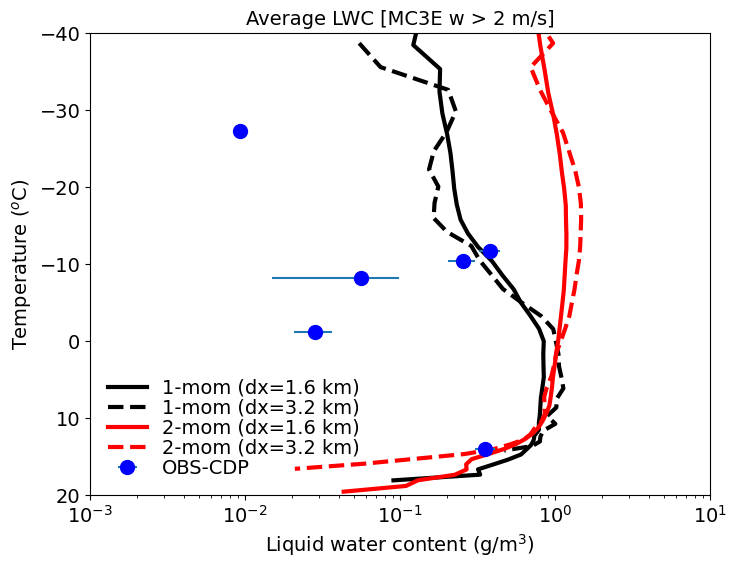

In [213]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_lwc_1600m_1mom,avg_tempc_1600m_1mom, 'k-', label='1-mom (dx=1.6 km)', linewidth = lnwdth)
plt.plot(avg_lwc_3200m_1mom,avg_tempc_3200m_1mom, 'k--', label='1-mom (dx=3.2 km)', linewidth = lnwdth)
#plt.plot(avg_lwc_6500m_1mom,avg_tempc_6500m_1mom, 'k-.', label='1-mom (dx=6.5 km)', linewidth = lnwdth)
#plt.plot(avg_lwc_13000m_1mom,avg_tempc_13000m_1mom, 'k:', label='1-mom (dx=13 km)', linewidth = lnwdth)
plt.plot(avg_lwc_1600m_2mom,avg_tempc_1600m_2mom, 'r-', label='2-mom (dx=1.6 km)', linewidth = lnwdth)
plt.plot(avg_lwc_3200m_2mom,avg_tempc_3200m_2mom, 'r--', label='2-mom (dx=3.2 km)', linewidth = lnwdth)
#plt.plot(avg_lwc_6500m_2mom,avg_tempc_6500m_2mom, 'r-.', label='2-mom (dx=6.5 km)', linewidth = lnwdth)
#plt.plot(avg_lwc_13000m_2mom,avg_tempc_13000m_2mom, 'r:', label='2-mom (dx=13 km)', linewidth = lnwdth)
plt.errorbar(lwc_cdp, temp_obs_cdp, xerr=std_err_lwc_cdp, fmt='o' , label='OBS-CDP', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(20, -40)
plt.yticks([20,10,0,-10,-20,-30,-40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Liquid water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average LWC [MC3E w > 2 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/other_analysis/mc3e_lwc_resolution_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

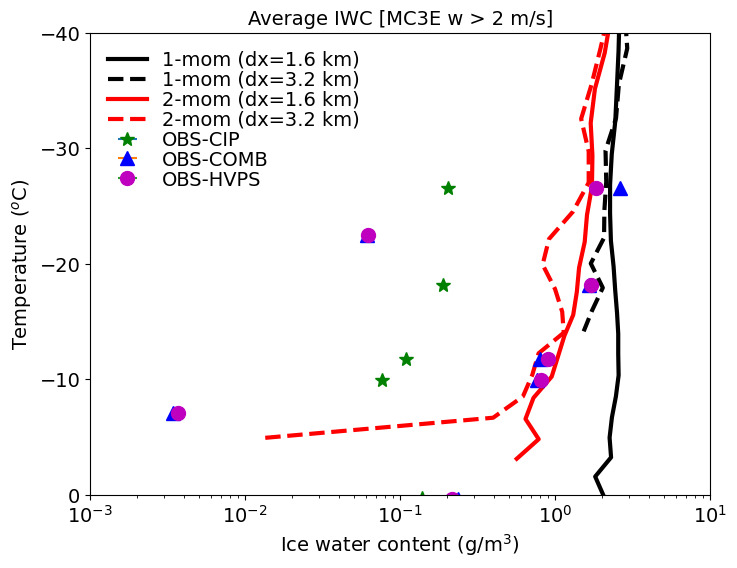

In [228]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_iwc_1600m_1mom,avg_tempc_1600m_1mom, 'k-', label='1-mom (dx=1.6 km)', linewidth = lnwdth)
plt.plot(avg_iwc_3200m_1mom,avg_tempc_3200m_1mom, 'k--', label='1-mom (dx=3.2 km)', linewidth = lnwdth)
#plt.plot(avg_iwc_6500m_1mom,avg_tempc_6500m_1mom, 'k-.', label='1-mom (dx=6.5 km)', linewidth = lnwdth)
#plt.plot(avg_iwc_13000m_1mom,avg_tempc_13000m_1mom, 'k:', label='1-mom (dx=13 km)', linewidth = lnwdth)
plt.plot(avg_iwc_1600m_2mom,avg_tempc_1600m_2mom, 'r-', label='2-mom (dx=1.6 km)', linewidth = lnwdth)
plt.plot(avg_iwc_3200m_2mom,avg_tempc_3200m_2mom, 'r--', label='2-mom (dx=3.2 km)', linewidth = lnwdth)
#plt.plot(avg_iwc_6500m_2mom,avg_tempc_6500m_2mom, 'r-.', label='2-mom (dx=6.5 km)', linewidth = lnwdth)
#plt.plot(avg_iwc_13000m_2mom,avg_tempc_13000m_2mom, 'r:', label='2-mom (dx=13 km)', linewidth = lnwdth)
plt.errorbar(iwc_cip, temp_obs_cip, xerr=std_err_iwc_cip, fmt='*' , label='OBS-CIP', markersize=10,
             markeredgecolor='g', markerfacecolor='g', capsize=0)
plt.errorbar(iwc_comb, temp_obs_comb, xerr=std_err_iwc_comb, fmt='^' , label='OBS-COMB', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)
plt.errorbar(iwc_hvps, temp_obs_hvps, xerr=std_err_iwc_hvps, fmt='o' , label='OBS-HVPS', markersize=10,
             markeredgecolor='m', markerfacecolor='m', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0,-10,-20,-30,-40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average IWC [MC3E w > 2 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/other_analysis/mc3e_iwc_resolution_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

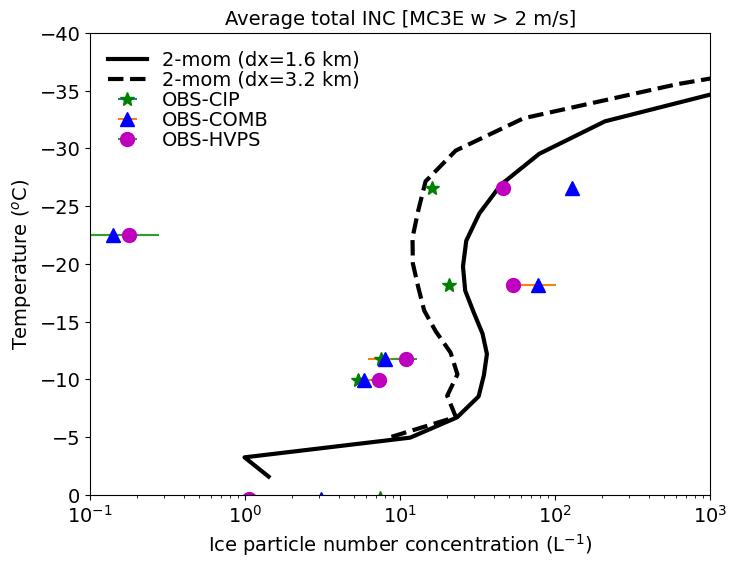

In [229]:
# Plotting
plt.figure(figsize=(8, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.plot(avg_totice_2mom_1600m_perl,avg_tempc_1600m_1mom, 'k-', label='2-mom (dx=1.6 km)', linewidth = lnwdth)
plt.plot(avg_totice_2mom_3200m_perl,avg_tempc_3200m_1mom, 'k--', label='2-mom (dx=3.2 km)', linewidth = lnwdth)
plt.errorbar(num_ice_cip, temp_obs_cip, xerr=std_err_num_ice_cip, fmt='*' , label='OBS-CIP', markersize=10,
             markeredgecolor='g', markerfacecolor='g', capsize=0)
plt.errorbar(num_ice_comb, temp_obs_comb, xerr=std_err_num_ice_comb, fmt='^' , label='OBS-COMB', markersize=10,
             markeredgecolor='b', markerfacecolor='b', capsize=0)
plt.errorbar(num_ice_hvps, temp_obs_hvps, xerr=std_err_num_ice_hvps, fmt='o' , label='OBS-HVPS', markersize=10,
             markeredgecolor='m', markerfacecolor='m', capsize=0)

# Setting plot limits and labels
plt.xlim(1.e-1, 1.e3)
plt.xticks([1.e-1,1.e0,1.e1,1.e2,1.e3], fontsize=fontsize)
plt.ylim(0, -40)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40], fontsize=fontsize)
# Set x-axis to logarithmic scale
plt.xscale('log')
plt.xlabel('Ice particle number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average total INC [MC3E w > 2 m/s]', fontsize=fontsize)
plt.legend()
# Increase the length of dashes in the legend
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/other_analysis/mc3e_total_inc_resolution_updraft.jpg', dpi=600, bbox_inches='tight')

plt.show()

In [219]:
import netCDF4 as nc

data_kazr_obs = xr.open_dataset('/work/bb1163/b382718/output/mc3e/observations/FORTRAN_CODE/RADAR_KAZR/sgpkazrcormdC1.c1.20110511.000000.nc')

ht_kazr_obs = 1.e-3*data_kazr_obs['range'];
time_kazr_obs = data_kazr_obs['time'];
zrefl_kazr_obs = data_kazr_obs['reflectivity_copol'];
alt_kazr_obs = data_kazr_obs['alt'];

print(time_kazr_obs)

filtered_zrefl_kazr_obs = xr.where((data_kazr_obs.reflectivity_copol > -10.), data_kazr_obs.reflectivity_copol, np.nan)
print(filtered_zrefl_kazr_obs.min())
print(filtered_zrefl_kazr_obs.max())


#start_time_obs = next((i for i, t in enumerate(time_kazr_obs) if t.hour == 6), None)
time_kazr_obs_datetime = pd.to_datetime(time_kazr_obs)

# Find the index corresponding to 06 UTC
start_time_obs = np.argmax(time_kazr_obs_datetime.hour == 12)


<xarray.DataArray 'time' (time: 23386)>
array(['2011-05-11T00:00:00.749755000', '2011-05-11T00:00:04.444345000',
       '2011-05-11T00:00:08.138932000', ..., '2011-05-11T23:59:51.395209000',
       '2011-05-11T23:59:55.089804000', '2011-05-11T23:59:58.784397000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2011-05-11T00:00:00.749755 ... 2011-05-11T...
Attributes:
    long_name:            Time offset from midnight
    ancillary_variables:  base_time
<xarray.DataArray 'reflectivity_copol' ()>
array(-9.99995041)
<xarray.DataArray 'reflectivity_copol' ()>
array(36.90934372)


In [221]:
import netCDF4 as nc


#============================================================================#
#================================= 1-moment =================================#
#============================================================================#

ds_11may_1600m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_1600m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")
grid_1600m_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain4_DOM04.nc")

data_mc3e_1600m_1mom = xr.concat([ds_11may_1600m_1mom, ds_12may_1600m_1mom], dim="time")

mask_1600m_cell=np.isin(data_mc3e_1600m_1mom['ncells'], selected_indices_1600m.cell)
ds_new_1600m_1mom = data_mc3e_1600m_1mom.sel(ncells=mask_1600m_cell)
grid_1600m_new = grid_1600m_mc3e.sel(cell=mask_1600m_cell)

filtered_dbz_1600m_1mom = xr.where((ds_new_1600m_1mom.dbz > -10.), ds_new_1600m_1mom.dbz, np.nan)

time_new_1600m_1mom = ds_new_1600m_1mom["time"];
dbz_new_1600m_1mom = ds_new_1600m_1mom["dbz"];
ht_new_1600m_1mom = ds_new_1600m_1mom["z_mc"];

avg_dbz_new_1600m_1mom = filtered_dbz_1600m_1mom.mean("ncells")
avg_ht_new_1600m_1mom = 1.e-3*ht_new_1600m_1mom.mean(dim=('time','ncells'))

#============================================================================#
#================================= 2-moment =================================#
#============================================================================#

ds_11may_1600m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110511T*Z.nc")
ds_12may_1600m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM04_20110512T*Z.nc")

data_mc3e_1600m_2mom = xr.concat([ds_11may_1600m_2mom, ds_12may_1600m_2mom], dim="time")

mask_1600m_cell=np.isin(data_mc3e_1600m_2mom['ncells'], selected_indices_1600m.cell)
ds_new_1600m_2mom = data_mc3e_1600m_2mom.sel(ncells=mask_1600m_cell)

filtered_dbz_1600m_2mom = xr.where((ds_new_1600m_2mom.dbz > -10.), ds_new_1600m_2mom.dbz, np.nan)

time_new_1600m_2mom = ds_new_1600m_2mom["time"];
dbz_new_1600m_2mom = ds_new_1600m_2mom["dbz"];
ht_new_1600m_2mom = ds_new_1600m_2mom["z_mc"];

print(ht_new_1600m_2mom.shape)
avg_dbz_new_1600m_2mom = filtered_dbz_1600m_2mom.mean("ncells")
avg_ht_new_1600m_2mom = 1.e-3*ht_new_1600m_2mom.mean(dim=('time','ncells'))

print(filtered_dbz_1600m_2mom.dims)
print(avg_dbz_new_1600m_2mom.dims)


(37, 65, 15051)
('time', 'height', 'ncells')
('time', 'height')


In [222]:
import netCDF4 as nc


#============================================================================#
#================================= 1-moment =================================#
#============================================================================#

ds_11may_3200m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM03_20110511T*Z.nc")
ds_12may_3200m_1mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/NWP_LAM_icongrid_DOM03_20110512T*Z.nc")
grid_3200m_mc3e = xr.open_dataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/1mom/domain3_DOM03.nc")

data_mc3e_3200m_1mom = xr.concat([ds_11may_3200m_1mom, ds_12may_3200m_1mom], dim="time")

mask_3200m_cell=np.isin(data_mc3e_3200m_1mom['ncells'], selected_indices_3200m.cell)
ds_new_3200m_1mom = data_mc3e_3200m_1mom.sel(ncells=mask_3200m_cell)
grid_3200m_new = grid_3200m_mc3e.sel(cell=mask_3200m_cell)

filtered_dbz_3200m_1mom = xr.where((ds_new_3200m_1mom.dbz > -10.), ds_new_3200m_1mom.dbz, np.nan)

time_new_3200m_1mom = ds_new_3200m_1mom["time"];
dbz_new_3200m_1mom = ds_new_3200m_1mom["dbz"];
ht_new_3200m_1mom = ds_new_3200m_1mom["z_mc"];

avg_dbz_new_3200m_1mom = filtered_dbz_3200m_1mom.mean("ncells")
avg_ht_new_3200m_1mom = 1.e-3*ht_new_3200m_1mom.mean(dim=('time','ncells'))

#============================================================================#
#================================= 2-moment =================================#
#============================================================================#

ds_11may_3200m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM03_20110511T*Z.nc")
ds_12may_3200m_2mom = xr.open_mfdataset("/work/bb1163/b382718/output/mc3e/nested_run/icon_output/lower_ccn/resol_1600m/2mom/NWP_LAM_icongrid_DOM03_20110512T*Z.nc")

data_mc3e_3200m_2mom = xr.concat([ds_11may_3200m_2mom, ds_12may_3200m_2mom], dim="time")

mask_3200m_cell=np.isin(data_mc3e_3200m_2mom['ncells'], selected_indices_3200m.cell)
ds_new_3200m_2mom = data_mc3e_3200m_2mom.sel(ncells=mask_3200m_cell)

filtered_dbz_3200m_2mom = xr.where((ds_new_3200m_2mom.dbz > -10.), ds_new_3200m_2mom.dbz, np.nan)

time_new_3200m_2mom = ds_new_3200m_2mom["time"];
dbz_new_3200m_2mom = ds_new_3200m_2mom["dbz"];
ht_new_3200m_2mom = ds_new_3200m_2mom["z_mc"];

print(ht_new_3200m_2mom.shape)
avg_dbz_new_3200m_2mom = filtered_dbz_3200m_2mom.mean("ncells")
avg_ht_new_3200m_2mom = 1.e-3*ht_new_3200m_2mom.mean(dim=('time','ncells'))

print(filtered_dbz_3200m_2mom.dims)
print(avg_dbz_new_3200m_2mom.dims)


(37, 65, 3759)
('time', 'height', 'ncells')
('time', 'height')


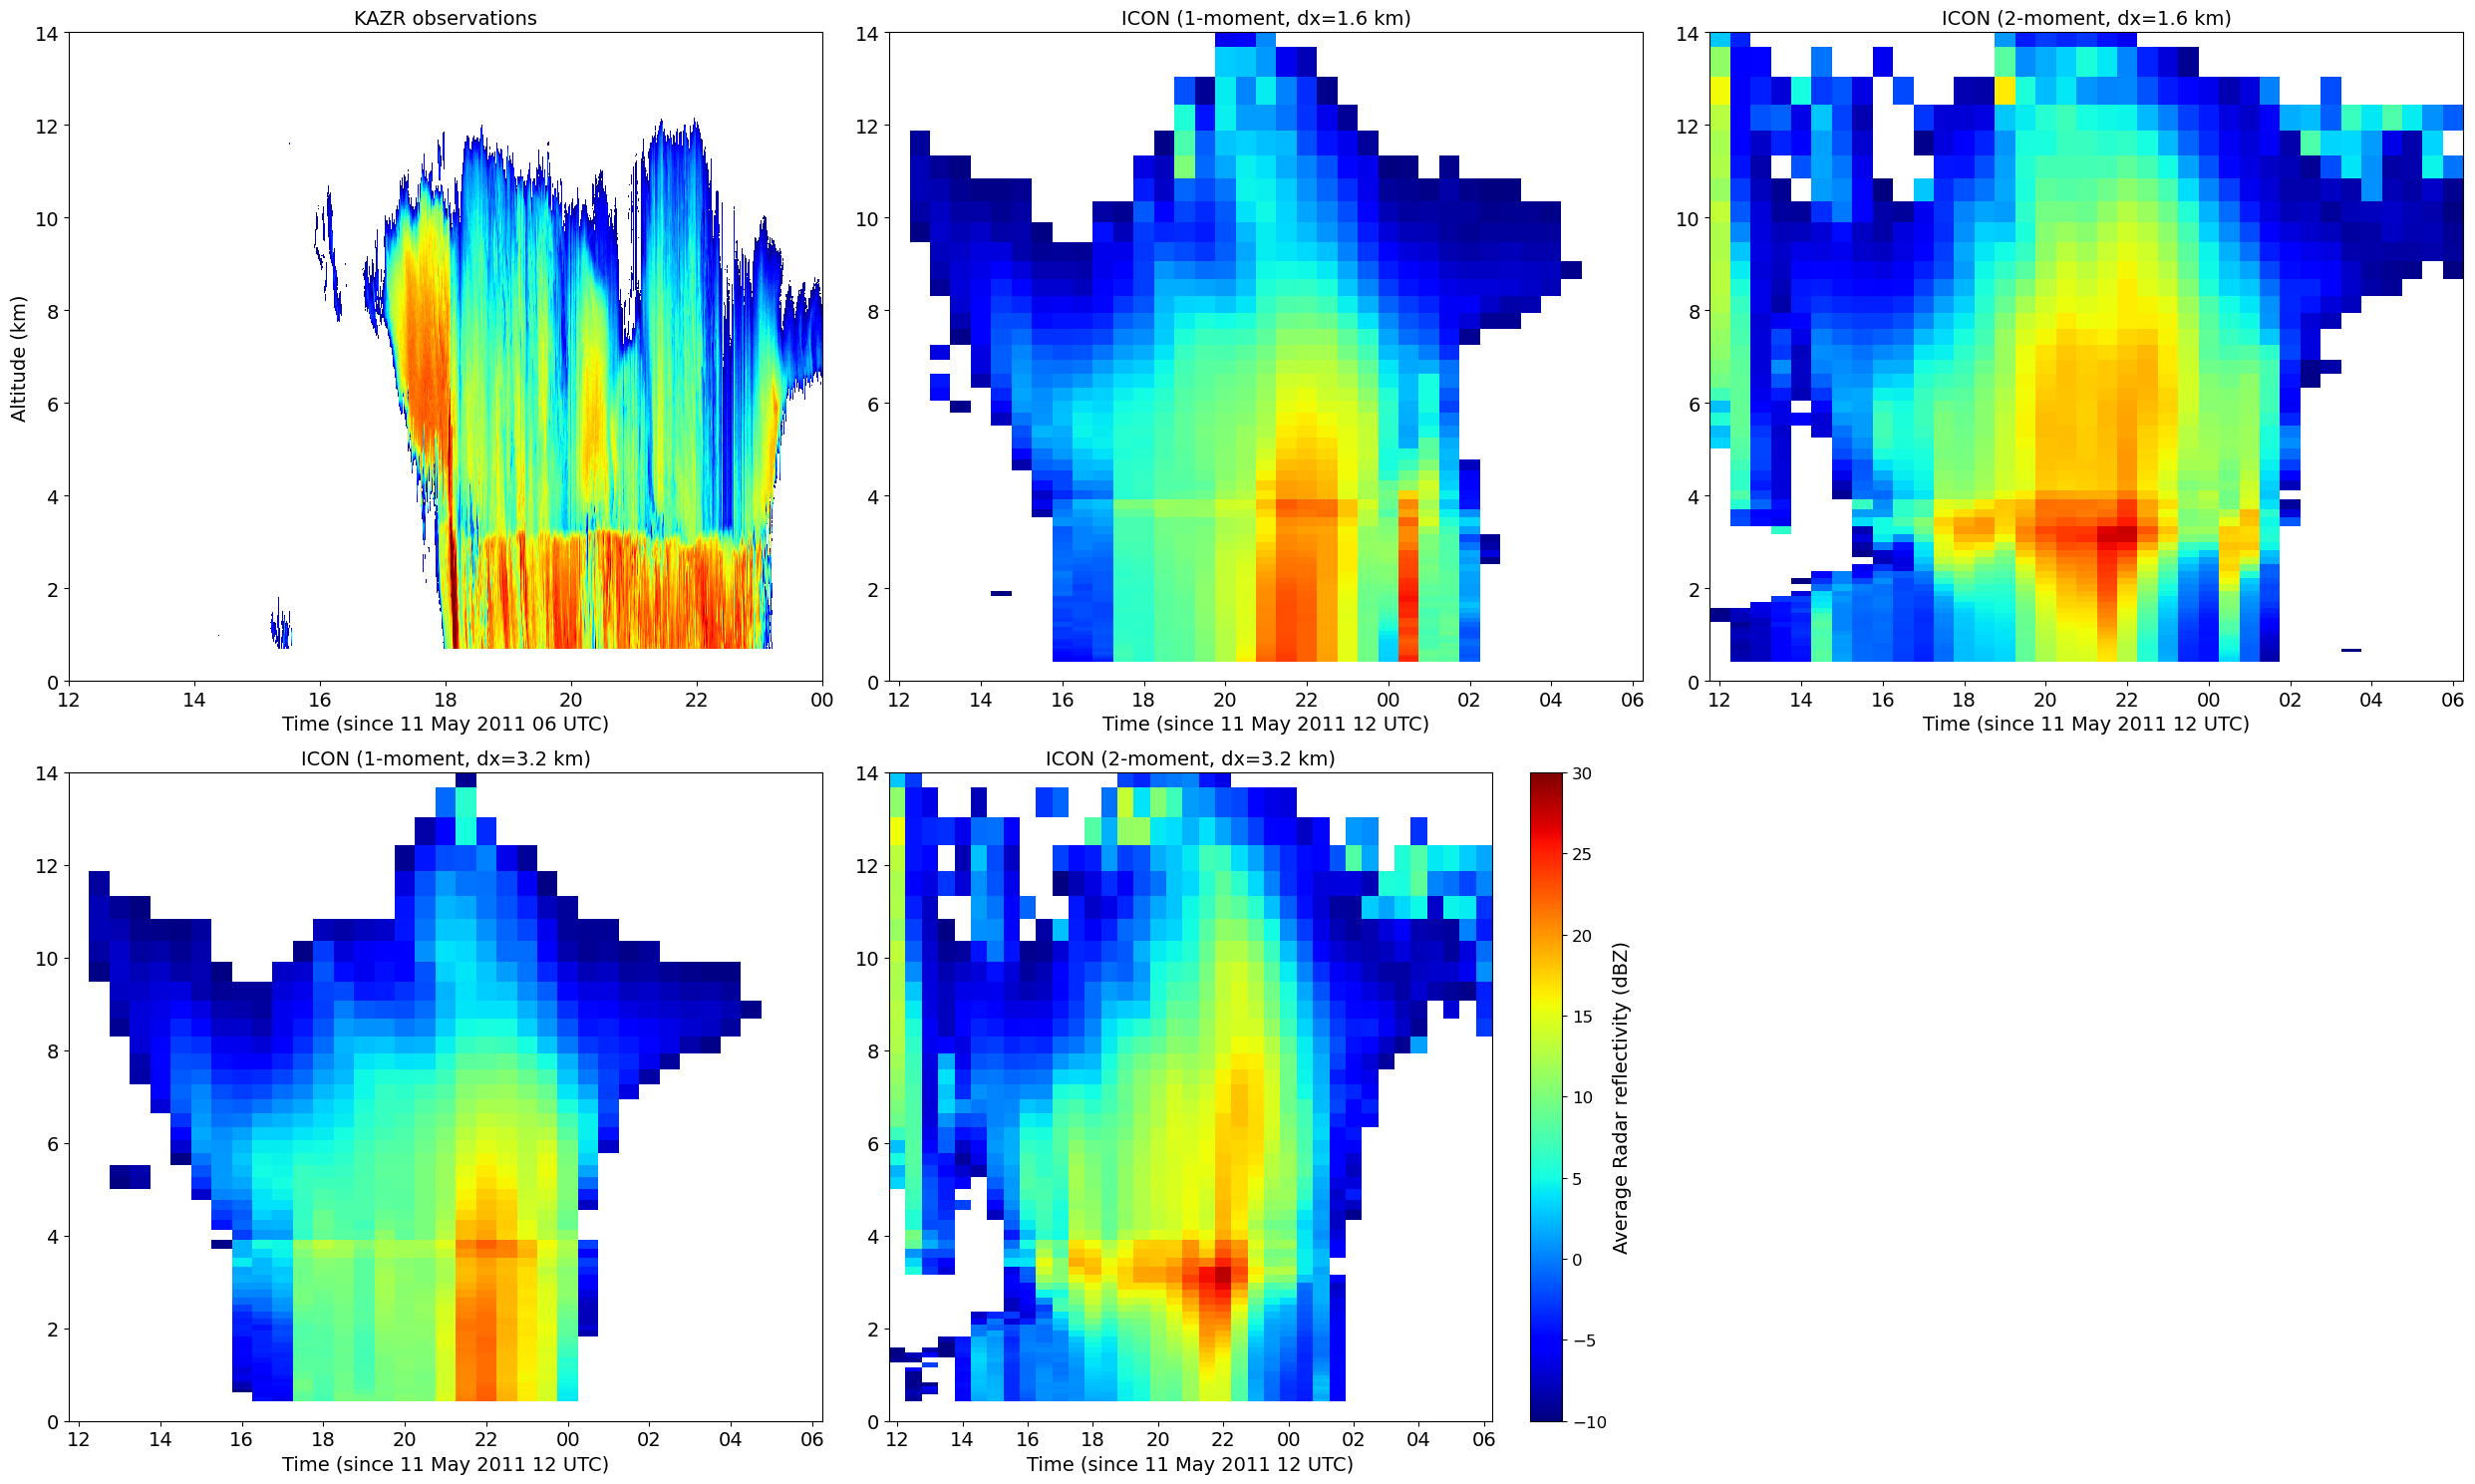

In [231]:
plt.figure(figsize=(25, 15))

# First subplot
plt.subplot(2, 3, 1)
contour = plt.pcolormesh(time_kazr_obs[start_time_obs:], ht_kazr_obs, filtered_zrefl_kazr_obs[start_time_obs:].T, cmap='jet', vmin=-10, vmax=30)
#colorbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40], label='Average Radar reflectivity (dBZ)')
#colorbar.ax.tick_params(labelsize=12)
#colorbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)
plt.xlabel('Time (since 11 May 2011 06 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 14])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14], fontsize=14)
plt.ylabel('Altitude (km)', fontsize=14)
plt.title('KAZR observations', fontsize=14)

# Second subplot
plt.subplot(2, 3, 2)
contour = plt.pcolormesh(time_new_1600m_1mom, avg_ht_new_1600m_1mom, avg_dbz_new_1600m_1mom.T, cmap='jet', vmin=-10, vmax=30)
plt.xlabel('Time (since 11 May 2011 12 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 14])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14], fontsize=14)
#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (1-moment, dx=1.6 km)', fontsize=14)

# Third subplot
plt.subplot(2, 3, 3)
contour=plt.pcolormesh(time_new_1600m_2mom, avg_ht_new_1600m_2mom, avg_dbz_new_1600m_2mom.T, cmap='jet', vmin=-10, vmax=30)
plt.xlabel('Time (since 11 May 2011 12 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 14]); 
plt.yticks([0,2,4,6,8,10,12,14], fontsize=14)
#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (2-moment, dx=1.6 km)', fontsize=14)

# Second subplot
plt.subplot(2, 3, 4)
contour = plt.pcolormesh(time_new_3200m_1mom, avg_ht_new_3200m_1mom, avg_dbz_new_3200m_1mom.T, cmap='jet', vmin=-10, vmax=30)
plt.xlabel('Time (since 11 May 2011 12 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 14])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14], fontsize=14)
#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (1-moment, dx=3.2 km)', fontsize=14)

# Third subplot
plt.subplot(2, 3, 5)
contour=plt.pcolormesh(time_new_3200m_2mom, avg_ht_new_3200m_2mom, avg_dbz_new_3200m_2mom.T, cmap='jet', vmin=-10, vmax=30)
plt.xlabel('Time (since 11 May 2011 12 UTC)', fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format to show only hours
plt.xticks(fontsize=14)
plt.ylim([0, 14]); 
plt.yticks([0,2,4,6,8,10,12,14], fontsize=14)
#plt.ylabel('Altitude (km)', fontsize=14)
plt.title('ICON (2-moment, dx=3.2 km)', fontsize=14)

# Create a colorbar
cbar = plt.colorbar(contour, ticks=[-10, -5, 0, 5, 10, 15, 20, 25, 30], label='Average Radar reflectivity (dBZ)', orientation='vertical')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='Average Radar reflectivity (dBZ)', size=14)

# Adjust colorbar position
plt.subplots_adjust(bottom=0.2, right=0.5, top=0.9)  # Adjust the position of the colorbar

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig('/work/bb1163/b382718/ICON_ANALYSIS/mc3e/plots/lower_ccn/resol_1600m/continental_ccn/other_analysis/mc3e_refl_validation_time_ht.jpg', dpi=600, bbox_inches='tight')

plt.show()


/tmp/ipykernel_1030598/3408865942.py:13: RuntimeWarning: divide by zero encountered in log
  logD = np.log(D)


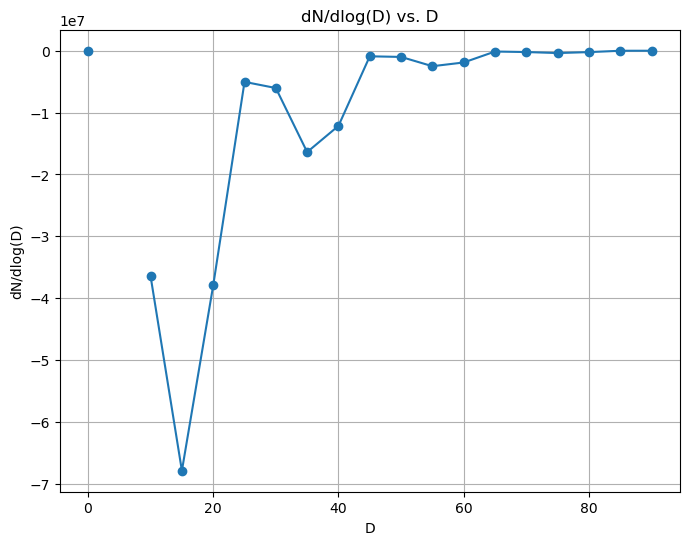

In [28]:
drop_num_conc = [20343320., 4533320., 2433234., 423238., 222343., 435634., 544346., 34536., 345623., 934645.44, 59843., 65945., 43533., 16342., 15138., 422., 543., 121., 57.];
drop_diam = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90];


import numpy as np
import matplotlib.pyplot as plt

# Given data
N = np.array([70343320., 60343320., 50343320., 30343320., 7034332., 6034332., 5034332., 4034332., 703433., 603433., 503433., 403433., 70343., 60343., 50343., 30343., 703., 303., 132.])
D = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90])

# Compute log(D)
logD = np.log(D)

# Compute dN/dlog(D)
dN_dlogD = np.gradient(N, logD)

# Plot dN/dlog(D) against D
plt.figure(figsize=(8, 6))
plt.plot(D, dN_dlogD, marker='o', linestyle='-')
plt.xlabel('D')
plt.ylabel('dN/dlog(D)')
plt.title('dN/dlog(D) vs. D')
plt.grid(True)
plt.show()
